In [4]:
import wikipedia
import urllib
from urllib.error import HTTPError
import difflib
import spacy
import datetime
import numpy as np

nlp = spacy.load("en_core_web_md")

In [3]:
def get_sets(words_set, mode):
    good = set()
    bad = set()
    very_bad = set()
    
    for i, word in enumerate(words_set):
        try:
            url_suffix = (word.replace(" ", "_").replace("-", "_")).capitalize()
            url = "https://en.wikipedia.org/wiki/" + url_suffix
            status = 0
            try:
                code = urllib.request.urlopen(url).getcode()
                if code == 200:
                    good.add(word)
                    status = 1
            except HTTPError:
                if status == 0 and word[-1] == 's' and len(word.split(" ")) > 1:
                    url = url[:-1]
                    try:
                        code = urllib.request.urlopen(url).getcode()
                        if code == 200:
                            good.add(word)
                            status = 1
                    except HTTPError:
                        bad.add(word)
            print("Ran " + str(i + 1) + "... Keyword: " + word + " URL: " + url + " Status: " + str(status))
        except:
            very_bad.add(word)
    
    probably_good = set()
    for word in words_set.difference(good):
        query = word.replace("-", " ").lower()
        query_tok = nlp(query)
        values = []
        for result in wikipedia.search(query):
            result_tok = nlp(result.lower().replace("-", " "))
            d = result_tok.similarity(query_tok) * 100 
            values.append(d)
        if len(values) != 0:
            print("Rechecking... " + "Keyword: " + word + " Max Similarity: " + str(max(values)))
            if max(values) > 80.0:
                probably_good.add(word)

    return good, probably_good

def get_precision(words_set, mode, good=None, probably_good=None):
    if good is None or probably_good is None:
        good, probably_good = get_sets(words_set, mode)
    precision = ((len(good) + len(probably_good)) / len(words_set)) * 100.0
    return precision, good, probably_good

def get_recall(prdr_good_set, ap_good_set):
    if prdr_good_set is None or ap_good_set is None:
        return None
    prdr_recall = (len(prdr_good_set))/(len(prdr_good_set.union(ap_good_set))) * 100.0
    ap_recall = (len(prdr_good_set))/(len(prdr_good_set.union(ap_good_set))) * 100.0
    return prdr_recall, ap_recall

In [33]:
def get_precision_and_recall_values(prdr_words, autophrase_words, combined_words, upper_limit, step_size):
    
    num_doc_values = np.arange(100, upper_limit, step_size)
    
    prdr_precision = []
    ap_precision = []
    combined_precision = []

    prdr_recall = []
    ap_recall = []
    combined_recall = []
    
    for threshold in num_doc_values:
        x1, prdr_s1, prdr_s2 = get_precision(set(prdr_words[0:threshold]), 0, None, None)
        x2, ap_s1, ap_s2 = get_precision(set(autophrase_words[0:threshold]), 1, None, None)
        x3, c_s1, c_s2 = get_precision(set(combined_words[0:threshold]), 1, None, None)

        prdr_precision.append(x1)
        ap_precision.append(x2)
        combined_precision.append(x3)

        y1 = (len(prdr_s1.union(prdr_s2))/ len(prdr_s1.union(prdr_s2).union(ap_s1).union(ap_s2).union(c_s1).union(c_s2))) * 100
        y2 = (len(ap_s1.union(ap_s2))/ len(prdr_s1.union(prdr_s2).union(ap_s1).union(ap_s2).union(c_s1).union(c_s2))) * 100
        y3 = (len(c_s1.union(c_s2))/ len(prdr_s1.union(prdr_s2).union(ap_s1).union(ap_s2).union(c_s1).union(c_s2))) * 100

        prdr_recall.append(y1)
        ap_recall.append(y2)
        combined_recall.append(x3)
    
    return num_doc_values, prdr_precision, ap_precision, combined_precision, prdr_recall, ap_recall, combined_recall


In [34]:
prdr = [('constraint programming', 4.146975864728949e+25), ('natural language processing', 4.146975864728949e+25), ('distributed database systems', 4.146975864728949e+25), ('machine learning', 4.146975864728949e+25), ('artificial intelligence', 4.146975864728949e+25), ('interface applications', 4.146975864728949e+20), ('signal processing', 7.801448871916868e+19), ('stimulation technique', 5.1837198309111865e+19), ('case study', 8.321502256481229e+17), ('home networks', 5.2042799622007046e+17), ('rights management', 4.439690260366325e+17), ('game design', 2.6021399811003523e+17), ('tv systems', 2.6021399811003523e+17), ('mathematica package', 2.545212638425329e+17), ('simulation study', 2.540560872677103e+17), ('power control', 2.4803804714475952e+17), ('disclosure limitation', 1.5775712572730557e+17), ('machine translation', 1.4000060192602195e+17), ('camera image', 1.2987600175767061e+17), ('array systems', 1.2548697218931867e+17), ('streaming applications', 1.2548697218931867e+17), ('processor systems', 1.2548697218931867e+17), ('space-time modeling', 1.0517141715153706e+17), ('query learning', 1.0517141715153706e+17), ('quality control', 9.881291478995437e+16), ('data management', 9.837665555071701e+16), ('road networks', 9.616125210490646e+16), ('field experiment', 8.908206908248026e+16), ('process control', 7.925987258757995e+16), ('circuit simulation', 7.097577955355297e+16), ('cinema projection', 6.4938000878835304e+16), ('terrain model', 6.4938000878835304e+16), ('python package', 6.481525691957897e+16), ('library service', 6.186887469774107e+16), ('software package', 6.174765001635647e+16), ('data mining', 5.636449655447166e+16), ('system dynamics', 5.5487845978839656e+16), ('equilibrium wealth', 5.258570857576853e+16), ('data editing', 5.258570857576853e+16), ('disclosure control', 5.258570857576853e+16), ('web object', 5.258570857576853e+16), ('learning approaches', 5.258570857576853e+16), ('decision techniques', 5.258570857576853e+16), ('metadata modeling', 5.258570857576853e+16), ('timing analysis', 5.258570857576853e+16), ('data compression', 5.076214002495956e+16), ('shape analysis', 4.9048069065256584e+16), ('software tool', 4.69189104861279e+16), ('social network', 4.649469946357993e+16), ('matlab package', 4.558343332599733e+16), ('literature review', 4.547785577502325e+16), ('pattern recognition', 4.14101689808442e+16), ('hash table', 3.722568392448135e+16), ('file systems', 3.722568392448135e+16), ('decision support', 3.4537047979068336e+16), ('computer program', 3.4110888449327976e+16), ('maple package', 3.4090964598516756e+16), ('simulation model', 3.340069895444041e+16), ('program suite', 3.2407628459789484e+16), ('simulation language', 3.2407628459789484e+16), ('simulation computer', 3.2407628459789484e+16), ('python framework', 3.2407628459789484e+16), ('business perspective', 3.2407628459789484e+16), ('network perspective', 3.2407628459789484e+16), ('program package', 3.2407628459789484e+16), ('laboratory investigation', 3.2407628459789484e+16), ('market design', 3.2407628459789484e+16), ('pilot study', 3.2090170950077896e+16), ('query language', 3.2090170950077896e+16), ('simulation case', 2.9672844363433548e+16), ('bond graph', 2.7939677773919044e+16), ('mechanism design', 2.6514916821990324e+16), ('deadlock management', 2.4817122616320904e+16), ('database design', 2.4817122616320904e+16), ('transaction management', 2.4817122616320904e+16), ('concurrency control', 2.4817122616320904e+16), ('query processing', 2.4011261679991492e+16), ('process mining', 2.364765747728131e+16), ('query optimization', 2.3168687405627544e+16), ('simulation environment', 2.212681484515002e+16), ('simulation approach', 2.212681484515002e+16), ('computer simulation', 2.0958994202749604e+16), ('data streams', 2.0882917222524676e+16), ('information systems', 2.0734150621758416e+16), ('database systems', 2.064943126497752e+16), ('knowledge management', 1.9739853448521136e+16), ('software architecture', 1.9181990370728348e+16), ('performance analysis', 1.8109499328898976e+16), ('software development', 1.748625028830727e+16), ('mathematica interface', 1.7261431393205096e+16), ('scheduling perspective', 1.7261431393205096e+16), ('design methodology', 1.7261431393205096e+16), ('modeling strategy', 1.7261431393205096e+16), ('software environment', 1.7261431393205096e+16), ('duality approach', 1.7261431393205096e+16), ('computer code', 1.7261431393205096e+16), ('comparison study', 1.7261431393205096e+16), ('matlab program', 1.7261431393205096e+16), ('simulation tool', 1.7261431393205096e+16), ('computer algebra', 1.6939341276923666e+16), ('research model', 1.6203814229894742e+16), ('nanotube application', 1.6203814229894742e+16), ('python tool', 1.6203814229894742e+16), ('particle approach', 1.6203814229894742e+16), ('stepwise approach', 1.6203814229894742e+16), ('market experiment', 1.6203814229894742e+16), ('database support', 1.6203814229894742e+16), ('research note', 1.6203814229894742e+16), ('safety climate', 1.6203814229894742e+16), ('naturalization proposal', 1.6203814229894742e+16), ('prototyping toolkit', 1.6203814229894742e+16), ('microcomputer system', 1.6203814229894742e+16), ('contest theory', 1.6203814229894742e+16), ('www bibliography', 1.6203814229894742e+16), ('defense system', 1.6203814229894742e+16), ('model specification', 1.6203814229894742e+16), ('survey approach', 1.6203814229894742e+16), ('search agent', 1.6203814229894742e+16), ('piecewise sqp', 1.6203814229894742e+16), ('grid simulation', 1.6203814229894742e+16), ('user interaction', 1.6203814229894742e+16), ('postmortem analysis', 1.6203814229894742e+16), ('compensation perspective', 1.6203814229894742e+16), ('journal pivotal', 1.6203814229894742e+16), ('modeling method', 1.6203814229894742e+16), ('simulation engine', 1.6203814229894742e+16), ('search formulation', 1.6203814229894742e+16), ('parallelization strategy', 1.6203814229894742e+16), ('stakeholder analysis', 1.6203814229894742e+16), ('lyapunov approach', 1.6203814229894742e+16), ('threat index', 1.6203814229894742e+16), ('coverage analysis', 1.6203814229894742e+16), ('field study', 1.6203814229894742e+16), ('disturbance estimation', 1.6203814229894742e+16), ('database workload', 1.6203814229894742e+16), ('cascade code', 1.6203814229894742e+16), ('learning approach', 1.6203814229894742e+16), ('graph theoretic', 1.6203814229894742e+16), ('matlab code', 1.6203814229894742e+16), ('grid middleware', 1.6203814229894742e+16), ('technology diffusion', 1.6203814229894742e+16), ('software code', 1.6203814229894742e+16), ('simulation toolkit', 1.6203814229894742e+16), ('contingency perspective', 1.6203814229894742e+16), ('welfare analysis', 1.6203814229894742e+16), ('gamification approach', 1.6203814229894742e+16), ('grid framework', 1.6203814229894742e+16), ('survival analysis', 1.6203814229894742e+16), ('hostless resource', 1.6203814229894742e+16), ('data structure', 1.6203814229894742e+16), ('color image', 1.6203814229894742e+16), ('laboratory experiment', 1.6203814229894742e+16), ('queueing optimization', 1.6203814229894742e+16), ('python interface', 1.6203814229894742e+16), ('packet classification', 1.6203814229894742e+16), ('research tool', 1.6203814229894742e+16), ('cssl/multiprocessor software', 1.6203814229894742e+16), ('network theory', 1.6203814229894742e+16), ('network optimization', 1.6203814229894742e+16), ('tool chain', 1.6203814229894742e+16), ('form library', 1.6203814229894742e+16), ('cournot convergence', 1.6203814229894742e+16), ('model system', 1.6203814229894742e+16), ('trade benefit', 1.6203814229894742e+16), ('management framework', 1.6203814229894742e+16), ('relax-and-fix method', 1.6203814229894742e+16), ('data plane', 1.6203814229894742e+16), ('python toolkit', 1.6203814229894742e+16), ('mupad program', 1.6203814229894742e+16), ('multiagent rhythm', 1.6203814229894742e+16), ('satisfaction equilibrium', 1.6203814229894742e+16), ('simulation package', 1.6203814229894742e+16), ('map framework', 1.6203814229894742e+16), ('target acquisition', 1.6203814229894742e+16), ('diffusion approach', 1.6203814229894742e+16), ('branch-and-merge approach', 1.6203814229894742e+16), ('level scheme', 1.6203814229894742e+16), ('topic modeling', 1.6203814229894742e+16), ('multiagent simulation', 1.6203814229894742e+16), ('coupling algorithm', 1.6203814229894742e+16), ('database retrieval', 1.6203814229894742e+16), ('glauber model', 1.6203814229894742e+16), ('posix model', 1.6203814229894742e+16), ('saddle-point strategy', 1.6203814229894742e+16), ('gpu implementation', 1.6203814229894742e+16), ('maple implementation', 1.6203814229894742e+16), ('training perspective', 1.6203814229894742e+16), ('transfer pricing', 1.6203814229894742e+16), ('household view', 1.6203814229894742e+16), ('supply chain', 1.5958215572474752e+16), ('cluster analysis', 1.5425903462509652e+16), ('systems analysis', 1.532318886473928e+16), ('laboratory study', 1.4938370913886908e+16), ('web mining', 1.4866988287857634e+16), ('manufacturing simulation', 1.4831513030241284e+16), ('learning analytics', 1.4831474044763326e+16), ('systems engineering', 1.4774405162628016e+16), ('fault diagnosis', 1.4110663490813078e+16), ('monte carlo', 1.3955840322667078e+16), ('tracking control', 1.3701225018593568e+16), ('video coding', 1.2455485285943146e+16), ('logic languages', 1.2408561308160452e+16), ('localization algorithms', 1.2408561308160452e+16), ('channel access', 1.2408561308160452e+16), ('utility estimation', 1.2408561308160452e+16), ('agent software', 1.2408561308160452e+16), ('object management', 1.2408561308160452e+16), ('memory computers', 1.2408561308160452e+16), ('database management', 1.2408561308160452e+16), ('inference making', 1.2408561308160452e+16), ('actuator selection', 1.2408561308160452e+16), ('path planning', 1.2408561308160452e+16), ('parameter model', 1.2408561308160452e+16), ('source coding', 1.2408561308160452e+16), ('response time', 1.2408561308160452e+16), ('averaging control', 1.2408561308160452e+16), ('commit protocol', 1.2408561308160452e+16), ('data aggregation', 1.2408561308160452e+16), ('batch processes', 1.2314940903779054e+16), ('life cycle', 1.2282764209614874e+16), ('storage systems', 1.2159837440569202e+16), ('consensus control', 1.2095960554198706e+16), ('chemical processes', 1.188709160872741e+16), ('process management', 1.1832213266362068e+16), ('computer science', 1.1810483194532302e+16), ('project management', 1.1738708106926798e+16), ('sensor fusion', 1.1578607564220364e+16), ('channel allocation', 1.1573424883274308e+16), ('approximation algorithms', 1.1335300531519736e+16), ('image authentication', 1.1170932661770594e+16), ('crime analysis', 1.1008096269817066e+16), ('query evaluation', 1.1008096269817066e+16), ('science ethics', 1.1008096269817066e+16), ('air separation', 1.1008096269817066e+16), ('engineering students', 1.0755869658686628e+16), ('systems approach', 1.0632109707802062e+16), ('decomposition method', 1.0632109707802062e+16), ('graph theory', 9706385548179472.0), ('game theory', 9624695683931166.0), ('wastewater treatment', 9368211027190742.0), ('business process', 9157173797942294.0), ('information technology', 8715943127460352.0), ('engineering ethics', 8612370798574149.0), ('hydrogen production', 8346529623574833.0), ('intrusion detection', 8346529623574833.0), ('web services', 7984390299556386.0), ('simulation framework', 7974082280851547.0), ('mathematica program', 7974082280851547.0), ('semiconductor manufacturing', 7764783671820566.0), ('emergency management', 7336068345670391.0), ('multiphase flow', 7127442472902311.0), ('process systems', 7036506021182821.0), ('water network', 6931342964915463.0), ('power systems', 6919507954618045.0), ('pressure swing', 6655977831721785.0), ('dimensionality reduction', 6497468087823932.0), ('web service', 6377659671012108.0), ('logic programs', 6212293886701298.0), ('hardware/software codesign', 6146946058630208.0), ('population balance', 6071128380153048.0), ('ethics education', 6061952353788462.0), ('information retrieval', 6060789660701414.0), ('service composition', 6027555057986805.0), ('gas dynamics', 6027555057986805.0), ('feynman integrals', 6027555057986805.0), ('portfolio optimization', 6027555057986805.0), ('task analysis', 6027555057986805.0), ('ambiguity aversion', 6027555057986805.0), ('sequence alignment', 6027555057986805.0), ('pipeline scheduling', 6027555057986805.0), ('option pricing', 6027555057986805.0), ('mobility data', 6027555057986805.0), ('gasoline blend', 6027555057986805.0), ('biomass supply', 5897966637544113.0), ('information aggregation', 5818303953753644.0), ('protein folding', 5787419034383682.0), ('knowledge discovery', 5780508015237102.0), ('communication networks', 5725179094142733.0), ('vehicle routing', 5690950245603535.0), ('user experience', 5673455716845826.0), ('time inconsistency', 5668030482570784.0), ('web users', 5668030482570784.0), ('devs models', 5668030482570784.0), ('ethics training', 5668030482570784.0), ('membrane separation', 5668030482570784.0), ('process design', 5664636602552027.0), ('bose-einstein condensates', 5603912221884363.0), ('optimization problems', 5544367003427009.0), ('protein production', 5504048134908533.0), ('software integration', 5504048134908533.0), ('intention recognition', 5504048134908533.0), ('transport time', 5504048134908533.0), ('safety evaluation', 5504048134908533.0), ('drug substance', 5504048134908533.0), ('control threats', 5504048134908533.0), ('vanilla extract', 5504048134908533.0), ('instruction retargeting', 5504048134908533.0), ('development theory', 5504048134908533.0), ('aircraft simulation', 5504048134908533.0), ('strategy formulation', 5504048134908533.0), ('region detection', 5504048134908533.0), ('connection admission', 5504048134908533.0), ('information services', 5504048134908533.0), ('audience reactions', 5504048134908533.0), ('queueing conflicts', 5504048134908533.0), ('box office', 5504048134908533.0), ('supply disruptions', 5504048134908533.0), ('grid resources', 5504048134908533.0), ('game playing', 5504048134908533.0), ('performance modelling', 5504048134908533.0), ('quality competition', 5504048134908533.0), ('memory deduplication', 5504048134908533.0), ('commodity chemicals', 5504048134908533.0), ('high-resolution displays', 5504048134908533.0), ('hospital wards', 5504048134908533.0), ('theory formation', 5504048134908533.0), ('insurance fraud', 5504048134908533.0), ('computer animation', 5504048134908533.0), ('knowledge system', 5504048134908533.0), ('network evolution', 5504048134908533.0), ('unit activity', 5504048134908533.0), ('communication loss', 5504048134908533.0), ('truss structures', 5504048134908533.0), ('kidney exchange', 5504048134908533.0), ('task allocation', 5504048134908533.0), ('currency crises', 5504048134908533.0), ('replay attacks', 5504048134908533.0), ('align competences', 5504048134908533.0), ('cell formation', 5504048134908533.0), ('pyrolysis reaction', 5504048134908533.0), ('interval map', 5504048134908533.0), ('technology transfer', 5504048134908533.0), ('text representation', 5504048134908533.0), ('uncertainty analysis', 5504048134908533.0), ('2d test', 5504048134908533.0), ('text indexing', 5504048134908533.0), ('electricity technologies', 5504048134908533.0), ('web semantics', 5504048134908533.0), ('mineral processing', 5504048134908533.0), ('noise ratio', 5504048134908533.0), ('renewables integration', 5504048134908533.0), ('signal quality', 5504048134908533.0), ('optimization modeling', 5504048134908533.0), ('occupancy modeling', 5504048134908533.0), ('security risk', 5504048134908533.0), ('state stability', 5504048134908533.0), ('board independence', 5504048134908533.0), ('density matrices', 5504048134908533.0), ('building blocks', 5504048134908533.0), ('"configuration interactions', 5504048134908533.0), ('virtue ethics', 5504048134908533.0), ('finance matter', 5504048134908533.0), ('decision assessment', 5504048134908533.0), ('power plants', 5504048134908533.0), ('admission control', 5504048134908533.0), ('web design', 5504048134908533.0), ('opportunity costs', 5504048134908533.0), ('distillation modelling', 5504048134908533.0), ('credit defaults', 5504048134908533.0), ('deuterium anneal', 5504048134908533.0), ('activity modeling', 5504048134908533.0), ('power production', 5504048134908533.0), ('market microstructure', 5504048134908533.0), ('legacy infrastructures', 5504048134908533.0), ('media analysis', 5504048134908533.0), ('probability densities', 5504048134908533.0), ('model building', 5504048134908533.0), ('traffic performance', 5504048134908533.0), ('junk science', 5504048134908533.0), ('merger announcements', 5504048134908533.0), ('staff plagiarism', 5504048134908533.0), ('equidistribution methods', 5504048134908533.0), ('author reviews', 5504048134908533.0), ('trace curves', 5504048134908533.0), ('sensitivity generation', 5504048134908533.0), ('model world', 5504048134908533.0), ('job outcomes', 5504048134908533.0), ('pavement engineering', 5504048134908533.0), ('model network', 5504048134908533.0), ('skin layer', 5504048134908533.0), ('knowledge resources', 5504048134908533.0), ('localization problems', 5504048134908533.0), ('text translation', 5504048134908533.0), ('gas-compressor stations', 5504048134908533.0), ('image indexing', 5504048134908533.0), ('technology strategy', 5504048134908533.0), ('resolution changes', 5504048134908533.0), ('database scalability', 5504048134908533.0), ('liquid (cbgtl', 5504048134908533.0), ('uncertainty quantification', 5504048134908533.0), ('market leadership', 5504048134908533.0), ('radiation symmetry', 5504048134908533.0), ('music piracy', 5504048134908533.0), ('information structure', 5504048134908533.0), ('university spin-offs', 5504048134908533.0), ('public-key cryptography', 5504048134908533.0), ('student emotion', 5504048134908533.0), ('technology development', 5476199211056763.0), ('water management', 5388934942370120.0), ('electricity markets', 5388934942370120.0), ('service systems', 5371920580766520.0), ('sensor network', 5329421476034746.0), ('performance indicators', 5326811301489212.0), ('simulation methodology', 5316054853901031.0), ('prototype implementation', 5316054853901031.0), ('decomposition framework', 5316054853901031.0), ('branch-and-bound algorithm', 5316054853901031.0), ('branch-and-price approach', 5316054853901031.0), ('modeling methodology', 5316054853901031.0), ('security framework', 5316054853901031.0), ('branch-and-price algorithm', 5316054853901031.0), ('drug development', 5310776420562424.0), ('fusion plasmas', 5310776420562424.0), ('chemical reaction', 5299461896653306.0), ('face recognition', 5259007359802913.0), ('supply chains', 5256920668570229.0), ('materials science', 5217272043163270.0), ('congestion games', 5217272043163270.0), ('customer relationship', 5217272043163270.0), ('ethics instruction', 5217272043163270.0), ('product engineering', 5217272043163270.0), ('web search', 5156319544965788.0), ('knowledge sharing', 5078180531264852.0), ('data integration', 5066844029712758.0), ('stock returns', 4843261732958137.0), ('team performance', 4835550468387056.0), ('graph clustering', 4826016983868558.0), ('data warehouse', 4812603202577221.0), ('recommender systems', 4716604149744044.0), ('stock market', 4702496504361925.0), ('data warehouses', 4656167977223047.0), ('web data', 4573690556457487.0), ('business processes', 4541111331191427.0), ('parameter estimation', 4532002342248952.0), ('sensor networks', 4468157187213417.0), ('batch plants', 4370063388441570.5), ('business intelligence', 4344152345944858.5), ('data disclosure', 4248078338780198.5), ('product design', 4241409638087951.0), ('life science', 4159413519398056.5), ('service (qos', 4093141043131257.0), ('interval matrices', 4093141043131257.0), ('lattice boltzmann', 4077741364557443.5), ('heat exchanger', 4052820477018002.5), ('web portals', 3924606194323102.0), ('state estimation', 3919403256319973.0), ('information security', 3901202326927628.5), ('fraud detection', 3884010617103637.5), ('stream ciphers', 3884010617103637.5), ('chaos analysis', 3884010617103637.5), ('performance evaluation', 3830896524027836.0), ('power quality', 3799889143256223.0), ('information goods', 3799889143256223.0), ('user interface', 3799889143256223.0), ('simulation analysis', 3788958582785692.0), ('simulation modeling', 3773129962849929.5), ('space station', 3642060588065440.0), ('data distribution', 3605160916371511.5), ('research misconduct', 3564958187265575.0), ('multipurpose batch', 3399900960353954.0), ('performance comparison', 3341575642088473.0), ('web usage', 3341575642088473.0), ('time petri', 3341575642088473.0), ('injection molding', 3304908738210504.0), ('chemical process', 3263962841120726.5), ('chemical production', 3255625940331223.5), ('process monitoring', 3246915201881870.5), ('data reconciliation', 3236835725947947.0), ('perturbed oscillators', 3219122282640070.5), ('process simulation', 3195410324487431.5), ('web information', 3194319864734234.0), ('simulation models', 3155728513060164.5), ('energy systems', 3120501316844016.0), ('fault detection', 3065598073033689.0), ('data stream', 2991868336438139.5), ('web applications', 2970398786238740.5), ('batch process', 2932405970271757.0), ('systems management', 2925105303528808.0), ('computer systems', 2915965522027454.5), ('data privacy', 2913007962827728.0), ('spam filtering', 2913007962827728.0), ('application development', 2913007962827728.0), ('performance improvement', 2913007962827728.0), ('internet applications', 2913007962827728.0), ('multistage stochastic', 2913007962827728.0), ('quality assurance', 2913007962827728.0), ('sentiment analysis', 2913007962827728.0), ('probability measures', 2896101563963239.0), ('process scheduling', 2804865594696407.5), ('particle simulations', 2804865594696407.5), ('community detection', 2803431995349140.0), ('production scheduling', 2792666513253378.5), ('process synthesis', 2749349483077157.0), ('biodiesel production', 2733755438549824.5), ('water distribution', 2732043169287164.5), ('multimedia content', 2731972916144101.5), ('stability analysis', 2730361623836988.5), ('resource allocation', 2728118135275922.5), ('rheed intensity', 2722895299693708.5), ('water networks', 2666984100722302.0), ('tool support', 2658027426950515.5), ('programming model', 2658027426950515.5), ('web navigation', 2658027426950515.5), ('convex relaxation', 2658027426950515.5), ('controller architecture', 2658027426950515.5), ('reference implementation', 2658027426950515.5), ('hybrid ga-sqp', 2658027426950515.5), ('decomposition algorithm', 2658027426950515.5), ('model elimination', 2658027426950515.5), ('prolog simulator', 2658027426950515.5), ('modeling tool', 2658027426950515.5), ('transport simulation', 2658027426950515.5), ('transmission matrix', 2658027426950515.5), ('paradigm shift', 2658027426950515.5), ('parallelization scheme', 2658027426950515.5), ('utility threshold', 2658027426950515.5), ('maturity model', 2658027426950515.5), ('cluster algorithm', 2658027426950515.5), ('port simulation', 2658027426950515.5), ('multicomputer software', 2658027426950515.5), ('perturbation method', 2658027426950515.5), ('bargaining framework', 2658027426950515.5), ('content-incentive-usability framework', 2658027426950515.5), ('test electron', 2658027426950515.5), ('classification scheme', 2658027426950515.5), ('simulation method', 2658027426950515.5), ('capability maturity', 2658027426950515.5), ('management system', 2658027426950515.5), ('decomposition approach', 2658027426950515.5), ('matrix method', 2658027426950515.5), ('method engineering', 2658027426950515.5), ('usability study', 2658027426950515.5), ('framework analysis', 2658027426950515.5), ('value co-creation', 2658027426950515.5), ('bifurcation approach', 2658027426950515.5), ('multiscale systems', 2658027426950515.5), ('motion cueing', 2658027426950515.5), ('college admissions', 2658027426950515.5), ('multisensor technique', 2658027426950515.5), ('tool box', 2658027426950515.5), ('particle scale', 2658027426950515.5), ('transistor level', 2658027426950515.5), ('state action', 2658027426950515.5), ('postponement model', 2658027426950515.5), ('simulation assistant', 2658027426950515.5), ('tutor agent', 2658027426950515.5), ('knowledge process', 2658027426950515.5), ('bargaining model', 2658027426950515.5), ('calculation procedure', 2658027426950515.5), ('proposal model', 2658027426950515.5), ('regression approach', 2658027426950515.5), ('monitoring system', 2658027426950515.5), ('limit characterization', 2658027426950515.5), ('superspace module', 2658027426950515.5), ('graph partitioning', 2658027426950515.5), ('branch-and-cut method', 2658027426950515.5), ('video presentation', 2658027426950515.5), ('performance study', 2658027426950515.5), ('citation analysis', 2658027426950515.5), ('reduce program', 2658027426950515.5), ('domain-decomposition method', 2658027426950515.5), ('pomdp framework', 2658027426950515.5), ('factorization algorithm', 2658027426950515.5), ('time stamp', 2658027426950515.5), ('software stimulator', 2658027426950515.5), ('scheduling algorithm', 2658027426950515.5), ('low-dissipation finite-volume', 2658027426950515.5), ('software interface', 2658027426950515.5), ('state event', 2658027426950515.5), ('committee machine', 2658027426950515.5), ('fractiles perspective', 2658027426950515.5), ('threshold inventory', 2658027426950515.5), ('co-simulation method', 2658027426950515.5), ('robot model', 2658027426950515.5), ('codesign case', 2658027426950515.5), ('majority vote', 2658027426950515.5), ('pdp approach', 2658027426950515.5), ('market discovery', 2658027426950515.5), ('nonequilibrium model', 2658027426950515.5), ('supplier portal', 2658027426950515.5), ('network model', 2658027426950515.5), ('queueing analysis', 2658027426950515.5), ('visualization method', 2658027426950515.5), ('particle motion', 2658027426950515.5), ('performance simulation', 2658027426950515.5), ('calibration procedure', 2658027426950515.5), ('biomolecular electrostatics', 2658027426950515.5), ('fdtd analysis', 2658027426950515.5), ('multistream heat', 2658027426950515.5), ('coherence analysis', 2658027426950515.5), ('cokosnut code', 2658027426950515.5), ('separation principle', 2658027426950515.5), ('branch-and-bound decomposition', 2658027426950515.5), ('shortcut method', 2658027426950515.5), ('semantic-syntax model', 2658027426950515.5), ('two-stage algorithm', 2658027426950515.5), ('feature logic', 2658027426950515.5), ('forest canopy', 2658027426950515.5), ('modal µ-calculus', 2658027426950515.5), ('search algorithm', 2658027426950515.5), ('haar wavelet', 2658027426950515.5), ('sustainability root', 2658027426950515.5), ('particle localization', 2658027426950515.5), ('pdevs simulator', 2658027426950515.5), ('coherence space', 2658027426950515.5), ('phase space', 2658027426950515.5), ('process simulator', 2658027426950515.5), ('no-arbitrage analysis', 2658027426950515.5), ('multiechelon inventory', 2658027426950515.5), ('comparison framework', 2658027426950515.5), ('simulator design', 2658027426950515.5), ('perturbation approach', 2658027426950515.5), ('correspondence principle', 2658027426950515.5), ('gesture learning', 2658027426950515.5), ('decomposition methodology', 2658027426950515.5), ('multiprocessor system', 2658027426950515.5), ('point-of-interest recommendation', 2658027426950515.5), ('simulation procedure', 2658027426950515.5), ('default extension', 2658027426950515.5), ('splitting integration', 2658027426950515.5), ('multiagent architecture', 2658027426950515.5), ('phase transition', 2658027426950515.5), ('linearization method', 2658027426950515.5), ('java application', 2658027426950515.5), ('cell population', 2658027426950515.5), ('modeling framework', 2658027426950515.5), ('methodology proposal', 2658027426950515.5), ('cat tool', 2658027426950515.5), ('multiprocessor soc', 2658027426950515.5), ('state task', 2658027426950515.5), ('construction method', 2658027426950515.5), ('privacy service', 2658027426950515.5), ('likelihood approach', 2658027426950515.5), ('functional-pca approach', 2658027426950515.5), ('product theorem', 2658027426950515.5), ('band factorization', 2658027426950515.5), ('machine state', 2658027426950515.5), ('model library', 2658027426950515.5), ('tool kit', 2658027426950515.5), ('mediation layer', 2658027426950515.5), ('knowledge level', 2658027426950515.5), ('system architecture', 2658027426950515.5), ('bottom-up search', 2658027426950515.5), ('software program', 2658027426950515.5), ('simulation technique', 2658027426950515.5), ('metadata approach', 2658027426950515.5), ('block jacobi', 2658027426950515.5), ('document retrieval', 2658027426950515.5), ('parallelization method', 2658027426950515.5), ('design space', 2645959436313292.0), ('data analysis', 2640857750023457.5), ('carbon dioxide', 2582305569630185.0), ('energy efficiency', 2571273471297375.5), ('process networks', 2544973712440475.5), ('search model', 2542316909638781.0), ('production planning', 2536577186651073.0), ('software security', 2536577186651073.0), ('robot control', 2536577186651073.0), ('data centers', 2509804940465406.0), ('folk theorem', 2488248443923839.5), ('hand gesture', 2474371663808861.0), ('web portal', 2460469976090952.0), ('meshless method', 2459782346435282.5), ('demand estimation', 2459782346435282.5), ('task scheduling', 2435378610715940.0), ('marksmanship performance', 2424896615423622.5), ('drug delivery', 2395241950519070.0), ('network security', 2351838361220071.5), ('gait recognition', 2351838361220071.5), ('data quality', 2351838361220071.5), ('dimension reduction', 2351838361220071.5), ('capacity planning', 2351838361220071.5), ('information products', 2351838361220071.5), ('market share', 2351838361220071.5), ('devs simulation', 2351838361220071.5), ('time series', 2312479481684550.0), ('enterprise transformation', 2286845278228743.5), ('particle swarm', 2282188683158764.5), ('process engineering', 2275075281382343.5), ('ion channels', 2270555665595713.5), ('blast furnace', 2242578210286727.5), ('information acquisition', 2213859520696177.5), ('recommender system', 2180310099057627.0), ('convex optimization', 2107650421424648.5), ('simulation output', 2088078754649849.8), ('power law', 2042571364934493.0), ('crystallization processes', 2037861862986912.8), ('process innovation', 2017310538648711.0), ('controller design', 2017310538648711.0), ('document analysis', 1994578890958759.5), ('data collection', 1992313984412772.0), ('feature terms', 1992313984412772.0), ('oil production', 1992313984412772.0), ('association rules', 1992313984412772.0), ('pedestrian flow', 1992313984412772.0), ('one-loop amplitudes', 1992313984412772.0), ('decision trees', 1992313984412772.0), ('engineering education', 1988528817954705.5), ('chemical engineering', 1985189447474480.8), ('process operations', 1950601163463814.2), ('team collaboration', 1942005308551818.8), ('user authentication', 1942005308551818.8), ('gap closing', 1942005308551818.8), ('multivariate change', 1942005308551818.8), ('process supervision', 1942005308551818.8), ('social networks', 166442316947702.34), ('semantic web', 33660871370888.72), ('peer-to-peer lending', 27942545126935.89), ('social media', 23491704887496.727), ('open collaboration', 13971272563467.945), ('instructional contexts', 13971272563467.945), ('semantic interoperability', 8910320480749.889), ('social web', 8605879051779.148), ('semantic integration', 8305177624691.756), ('analytical processing', 8003429569667.955), ('visual query', 6418043370846.457), ('class-based image', 6418043370846.457), ('geospatial web', 6418043370846.457), ('medical image', 6019276465113.701), ('financial advice', 5973132605714.152), ('social networking', 5767302525212.944), ('human computation', 5665771640282.618), ('social services', 4227050350949.8926), ('spatial data', 2894369693337.2695), ('preemptive scheduling', 2667809856555.985), ('node-weighted problems', 2667809856555.985), ('average-based system', 2667809856555.985), ('cross-modal adaptation', 2667809856555.985), ('self-help groups', 2667809856555.985), ('soft sensor', 2367765928392.7275), ('wireless sensor', 2258397564125.3584), ('private value', 2022805689604.8196), ('virtual reality', 1707046228970.4333), ('wireless networks', 1704909649034.9812), ('virtual environments', 1613301801457.299), ('complex systems', 1490838195323.0337), ('big data', 1294977818491.6472), ('cellular automata', 1255257841551.428), ('complex networks', 1218154652656.1187), ('temporal databases', 1190817168183.8518), ('digital libraries', 1179774598316.509), ('scientific computing', 1170466657520.6636), ('cloud computing', 1149599724408.6956), ('molecular dynamics', 1078008484352.1521), ('financial markets', 1062762501902.7056), ('higher education', 1062691086463.1687), ('location-based services', 1062691086463.1687), ('new product', 1038377184609.778), ('continuous time', 1021784572556.9065), ('special issue', 955048583507.1715), ('discrete event', 950469478654.5276), ('scale-free networks', 910878074111.2874), ('online markets', 910878074111.2874), ('common agency', 910094656296.5695), ('porous media', 880182544111.3273), ('multi-objective optimization', 836344044809.9512), ('optimal control', 834357776468.344), ('mobile computing', 810802349892.3123), ('linear systems', 808630243047.0992), ('transitional growth', 803153957746.7622), ('objective programming', 803153957746.7622), ('independent levels', 803153957746.7622), ('statistical decision', 803153957746.7622), ('adaptive mechanisms', 803153957746.7622), ('first authors', 803153957746.7622), ('elastic scattering', 779664979324.0371), ('molecular simulations', 759065061759.406), ('quaternionic quantum', 759065061759.406), ('real-time optimization', 746258580277.8562), ('global games', 738494868454.3799), ('high energy', 724872107255.7177), ('eco-industrial parks', 722993539805.1978), ('mobile environments', 722993539805.1978), ('combinatorial optimization', 722993539805.1978), ('nonlinear systems', 720938869491.1893), ('dynamic games', 710151409100.752), ('dynamical systems', 682638649461.0066), ('general equilibrium', 665069410806.6764), ('global optimization', 659449648273.7114), ('crude oil', 641820645692.4982), ('structured text', 627711689115.3004), ('random intersection', 607252049407.5248), ('parallel database', 607252049407.5248), ('neural networks', 606534375053.6312), ('wireless multi-hop', 605584883202.7867), ('spatio-temporal databases', 602868622120.2666), ('experimental evidence', 600419643584.475), ('multi-agent systems', 594817123702.2528), ('two-sided markets', 568700732516.2888), ('magnetic fields', 565638122525.7678), ('spatial analysis', 564061067450.3289), ('geometric networks', 545288976457.73016), ('open source', 543914400167.51843), ('online games', 523041705674.6519), ('adverse selection', 509918259491.9673), ('dynamic systems', 493566457982.2222), ('large networks', 485176005090.7857), ('optical lattices', 484186485850.6748), ('online auctions', 484186485850.6748), ('evolutionary games', 484186485850.6748), ('real time', 481905969185.1223), ('reactive distillation', 480409360247.2284), ('wireless video', 468728512915.7951), ('dynamic networks', 468477702085.37067), ('electronic markets', 467557226130.9875), ('stochastic games', 466555836494.1554), ('human-machine systems', 460745728785.42035), ('scientific writing', 455439037055.6437), ('general relativity', 455439037055.6437), ('principal-agent models', 455439037055.6437), ('financial networks', 455439037055.6437), ('dynamic environments', 455439037055.6437), ('magnetized plasmas', 455439037055.6437), ('common-value auctions', 455439037055.6437), ('real space', 455439037055.6437), ('metabolic networks', 455439037055.6437), ('spatio-temporal data', 455439037055.6437), ('serial supply', 455439037055.6437), ('computational neuroscience', 455439037055.6437), ('spatial databases', 454173350830.4342), ('biometric systems', 454173350830.4342), ('computational biology', 454173350830.4342), ('scientific data', 453948817667.47406), ('differential games', 446690875679.2116), ('biomedical research', 440304037288.63666), ('economic environments', 439618188728.73865), ('relational contracts', 432122178689.7599), ('relational databases', 431925486502.51184), ('neural population', 431624714728.90216), ('cellular networks', 431624714728.90216), ('bayesian games', 425546862018.87415), ('chemical plants', 425463485118.5832), ('hybrid wireless', 424293091203.8898), ('networked control', 419286049764.55597), ('agent-based simulation', 409203138963.62335), ('discrete time', 398161587766.9295), ('genetic algorithms', 384426870234.65106), ('unstructured grids', 380090249975.1778), ('remote sensing', 373544812303.85516), ('linear programming', 370094375233.2399), ('intelligent transportation', 362938730431.3957), ('real-time systems', 362054627990.0187), ('ubiquitous computing', 357408687413.58923), ('dissipative particle', 355811470379.59485), ('human-computer interaction', 354385371627.61847), ('discrete element', 353967852166.9663), ('fluid flow', 349095835822.23926), ('large-scale systems', 343488327672.122), ('extractive distillation', 343488327672.122), ('mobile devices', 340726310016.37445), ('natural gas', 340009811604.887), ('natural language', 338158667758.72375), ('industrial processes', 335649169936.48267), ('collaborative filtering', 335649169936.48267), ('wireless mesh', 334765067383.086), ('large scale', 332334573884.2017), ('computational physics', 327040837344.25916), ('cheap talk', 322920269532.33777), ('chemical supply', 322755081379.81177), ('nonlinear model', 322641901818.2602), ('spatiotemporal databases', 319493270883.9326), ('online labor', 319493270883.9326), ('multiple data', 318723336877.64307), ('statistical inference', 317110205988.37427), ('mutual fund', 316681472028.2853), ('multi-echelon supply', 316244512729.742), ('deductive databases', 313431840829.2021), ('large graphs', 313431840829.2021), ('nuclear power', 313431840829.2021), ('production-inventory systems', 313431840829.2021), ('safety-critical systems', 313431840829.2021), ('complex product', 313431840829.2021), ('adaptive systems', 313431840829.2021), ('random graphs', 313431840829.2021), ('electronic commerce', 313431840829.2021), ('complex reaction', 313431840829.2021), ('asynchronous transfer', 312661910425.52313), ('statistical databases', 312485675277.1967), ('numerical simulations', 312485675277.1967), ('automotive applications', 312485675277.1967), ('large data', 312485675277.1967), ('hybrid systems', 310684521659.4113), ('complex environments', 307475506756.16797), ('nonlinear control', 307475506756.16797), ('biopharmaceutical manufacturing', 307475506756.16797), ('mathematical programming', 306555999745.38165), ('uncertain data', 304532104856.7376), ('organizational structures', 303626024703.7624), ('virtual restoration', 303626024703.7624), ('optimal auctions', 303626024703.7624), ('heterogeneous network', 303626024703.7624), ('structured populations', 303626024703.7624), ('artificial vision', 303626024703.7624), ('public health', 303626024703.7624), ('computer-aided design', 303626024703.7624), ('electronic retailing', 303626024703.7624), ('spatiotemporal data', 303626024703.7624), ('hierarchical memory', 303626024703.7624), ('urban areas', 303626024703.7624), ('academic settings', 303626024703.7624), ('free surface', 303626024703.7624), ('medical geography', 303626024703.7624), ('unstructured radio', 303626024703.7624), ('crystalline materials', 303626024703.7624), ('general geometry', 303626024703.7624), ('biometric fusion', 303626024703.7624), ('homogeneous solids', 303626024703.7624), ('neuronal signaling', 303626024703.7624), ('scientific database', 303626024703.7624), ('hardware-software codesign', 303626024703.7624), ('single buffer', 303626024703.7624), ('competitive search', 303626024703.7624), ('spherical geometry', 303626024703.7624), ('academic research', 303626024703.7624), ('industrial symbiosis', 303626024703.7624), ('small network', 303626024703.7624), ('strategic market', 303626024703.7624), ('huge networks', 303626024703.7624), ('higher dimensions', 303626024703.7624), ('scientific databases', 303626024703.7624), ('multi-radio wireless', 303626024703.7624), ('large markets', 303626024703.7624), ('geometric radio', 303626024703.7624), ('dynamic markets', 303626024703.7624), ('weighted digraphs', 303626024703.7624), ('speculative markets', 303626024703.7624), ('process-aware information', 303626024703.7624), ('small networks', 303626024703.7624), ('online algorithms', 303626024703.7624), ('discrete simulation', 303626024703.7624), ('molecular crystals', 303626024703.7624), ('common value', 303626024703.7624), ('anaerobic digestion', 303626024703.7624), ('large populations', 303626024703.7624), ('structured domains', 303626024703.7624), ('complex organizations', 303626024703.7624), ('contemporary science', 303626024703.7624), ('different countries', 303626024703.7624), ('biomolecular systems', 303626024703.7624), ('social psychology', 303626024703.7624), ('rural sociology', 303626024703.7624), ('german hospitals', 303626024703.7624), ('random media', 303626024703.7624), ('sequential auctions', 303626024703.7624), ('ergodic theory', 303626024703.7624), ('hazardous applications', 303626024703.7624), ('french engineering', 303626024703.7624), ('active databases', 303626024703.7624), ('solid state', 303626024703.7624), ('compact spaces', 303626024703.7624), ('evolutionary learning', 303626024703.7624), ('spatial prediction', 303626024703.7624), ('complex engineering', 303626024703.7624), ('heterogeneous networks', 303626024703.7624), ('computational convexity', 303626024703.7624), ('pharmaceutical manufacturing', 303626024703.7624), ('dynamic settings', 303626024703.7624), ('large-scale service', 303626024703.7624), ('multi agent', 303626024703.7624), ('french sociology', 303626024703.7624), ('professional service', 303626024703.7624), ('large economies', 303626024703.7624), ('two-dimensional traffic', 303626024703.7624), ('lulc classification', 303626024703.7624), ('educational settings', 303626024703.7624), ('economic networks', 303626024703.7624), ('philosophical logic', 303626024703.7624), ('bilateral trade', 303626024703.7624), ('sublinear time', 303626024703.7624), ('geospatial domains', 303626024703.7624), ('multilateral bargaining', 303626024703.7624), ('heterogeneous clusters', 303626024703.7624), ('finite fields', 303626024703.7624), ('numerical solution', 303362430142.9759), ('large domains', 302792441601.3934), ('multiple lossy', 302792441601.3934), ('multi-dimensional space', 302792441601.3934), ('infinite intervals', 302792441601.3934), ('deterministic discrete-time', 302792441601.3934), ('hybrid networks', 302792441601.3934), ('heterogeneous terrain', 302792441601.3934), ('special fields', 302792441601.3934), ('variable terrain', 302792441601.3934), ('large solution', 302792441601.3934), ('dl-lite ontologies', 302792441601.3934), ('efficient sets', 302792441601.3934), ('multiobjective optimization', 302474569701.59814), ('multiple gpus', 302178984438.4002), ('user-generated content', 300953521403.88165), ('nearest neighbor', 300826348446.9064), ('numerical simulation', 299855252917.2505), ('reverse osmosis', 298967643513.40845), ('social interaction', 298967643513.40845), ('empirical study', 298824929562.12335), ('complex geometry', 297930513187.8186), ('qualitative simulation', 297930513187.8186), ('online communities', 297930513187.8186), ('cultural heritage', 297930513187.8186), ('pervasive computing', 297930513187.8186), ('virtual communities', 297930513187.8186), ('human-robot collaboration', 297930513187.8186), ('liquid chromatography', 297930513187.8186), ('scientific applications', 297925345914.2037), ('multiple time', 295728793751.75323), ('turbulent flows', 294206072348.23285), ('rough set', 289937039133.75476), ('boolean functions', 289880807440.77594), ('continuous action', 289167103779.6638), ('incomplete data', 289167103779.6638), ('stochastic overlapping', 288855068269.7653), ('genetic programming', 287847476200.58734), ('large games', 287743939371.24603), ('social science', 287743939371.24603), ('synthetic biology', 287341597809.9785), ('plant-wide control', 285037130666.7978), ('public sector', 279473963532.5036), ('relational database', 276305505834.19617), ('magnetized plasma', 271855909159.60236), ('private information', 267777101507.4878), ('incomplete information', 266025710576.44476), ('endogenous growth', 261913607802.20395), ('clinical trials', 259167945201.51056), ('short-term scheduling', 256735318628.41162), ('neural network', 254333669506.19843), ('critical index', 253668358692.92517), ('finite elements', 253393499983.45187), ('human behavior', 231857128613.58002), ('differential-algebraic equations', 231857128613.58002), ('liquid crystals', 231857128613.58002), ('new ventures', 231857128613.58002), ('linear equations', 229407301143.94647), ('experimental investigation', 228169154725.9175), ('random access', 227662317199.07944), ('conceptual design', 225735661734.63718), ('medical devices', 222113425467.88345), ('finite populations', 222113425467.88345), ('evolutionary algorithms', 220921569830.59766), ('shale gas', 219216925191.31418), ('nonlinear process', 216465415065.7024), ('dynamic contracts', 216429052262.05823), ('industrial engineering', 216429052262.05823), ('self-optimizing control', 216211437954.60062), ('coalitional equilibrium', 216061089344.87994), ('thermal management', 216061089344.87994), ('approximate all-pairs', 216061089344.87994), ('unstructured bargaining', 216061089344.87994), ('variational preferences', 216061089344.87994), ('conditional beta', 216061089344.87994), ('model-based fault', 216061089344.87994), ('rational inattention', 216061089344.87994), ('noncooperative games', 216061089344.87994), ('legislative policy', 216061089344.87994), ('haptic interaction', 216061089344.87994), ('greedy algorithms', 216061089344.87994), ('metabolic modeling', 216061089344.87994), ('predictive scheduling', 216061089344.87994), ('legislative decision', 216061089344.87994), ('potential games', 216061089344.87994), ('mixed duopoly', 216061089344.87994), ('strategic information', 216061089344.87994), ('logical partitioning', 216061089344.87994), ('topological logic', 216061089344.87994), ('solid oxide', 215753743419.18314), ('high performance', 213627000591.2061), ('hydraulic fracturing', 211358667756.8799), ('elementary particle', 210907374876.97394), ('economic applications', 210907374876.97394), ('econometric inferences', 210907374876.97394), ('car-parrinello calculations', 210907374876.97394), ('strategic complexity', 210907374876.97394), ('molecular genetics', 210907374876.97394), ('open issues', 210907374876.97394), ('empirical support', 210907374876.97394), ('hartree-fock method', 210907374876.97394), ('empirical evidence', 210907374876.97394), ('random variables', 208416370424.67276), ('human factors', 206127508118.27515), ('biological networks', 205418491334.39908), ('electronic structure', 204628917711.31805), ('embedded system', 204422853888.42673), ('two-phase flow', 202820634694.8271), ('social learning', 202820634694.8271), ('discontinuous games', 202820634694.8271), ('continuous system', 201936535586.8089), ('ambient intelligence', 201800647608.91095), ('organizational learning', 201800647608.91095), ('new technologies', 201800647608.91095), ('large systems', 201800647608.91095), ('forward osmosis', 201800647608.91095), ('social groups', 201800647608.91095), ('tubular reactors', 201800647608.91095), ('scientific work', 201800647608.91095), ('free energy', 201800647608.91095), ('optical networks', 201800647608.91095), ('parallel programs', 201800647608.91095), ('optical spectra', 201800647608.91095), ('human effectiveness', 200811134775.32187), ('sterile filling', 200811134775.32187), ('large-scale computer', 200811134775.32187), ('online movie', 200811134775.32187), ('computational forensics', 200811134775.32187), ('dark matter', 199739844607.47803), ('robust control', 198585235199.5915), ('sequential patterns', 197127333875.25818), ('time-evolving graphs', 197127333875.25818), ('dynamic modeling', 195861033724.57718), ('random number', 195837117209.64706), ('nonlinear equations', 194894005905.64407), ('interval computations', 193534897059.26126), ('dynamic data', 193270471892.81165), ('wavelet transform', 190045124987.5889), ('relational data', 189562934535.67282), ('autonomous vehicles', 188291755339.41028), ('high-performance computing', 188291755339.41028), ('asymmetric information', 187619479646.65576), ('robust counterpart', 185353161718.9161), ('enterprise-wide optimization', 185353161718.9161), ('closed-loop supply', 183784591150.71716), ('automotive industry', 180184457902.7725), ('complex chemical', 179392699163.71167), ('numerical methods', 178359890106.16788), ('social interactions', 178359890106.16788), ('discrete-event simulation', 178203904606.64902), ('epidemic simulations', 177971050068.54117), ('retail banking', 177805595070.13324), ('numerical modeling', 176491593647.30005), ('medical applications', 174646975091.97528), ('low temperature', 174646975091.97528), ('global software', 174646975091.97528), ('high power', 174646975091.97528), ('intelligent agents', 174646975091.97528), ('inertial confinement', 174646975091.97528), ('cumulative prospect', 174646975091.97528), ('human motion', 174646975091.97528), ('limited commitment', 174496109293.57858), ('human-robot interaction', 173785742991.33044), ('molecular simulation', 172414931479.67258), ('fed-batch cultures', 171744163836.061), ('dynamic models', 171744163836.061), ('biopharmaceutical processes', 171744163836.061), ('introductory programming', 171744163836.061), ('networked systems', 171744163836.061), ('online feedback', 171744163836.061), ('parallel tasks', 171744163836.061), ('neural data', 171744163836.061), ('cartesian coordinates', 171744163836.061), ('medical imaging', 171744163836.061), ('nuclear track', 171744163836.061), ('statistical data', 171744163836.061), ('discrete-time mip', 171744163836.061), ('sustainable supply', 171744163836.061), ('virtual worlds', 171744163836.061), ('risky decision', 171744163836.061), ('electronic transport', 171744163836.061), ('slow-fast systems', 171744163836.061), ('high density', 171744163836.061), ('continuous casting', 171744163836.061), ('concurrent design', 171744163836.061), ('heavy oil', 171744163836.061), ('overall process', 171744163836.061), ('intense laser', 171744163836.061), ('mobile middleware', 171744163836.061), ('dynamic graphs', 171744163836.061), ('atomic gases', 171744163836.061), ('autonomous robotics', 171744163836.061), ('scientific journals', 171744163836.061), ('clinical laboratories', 171744163836.061), ('mobile access', 171744163836.061), ('high-frequency data', 171744163836.061), ('global manufacturing', 171744163836.061), ('professional codes', 171744163836.061), ('different geometries', 171744163836.061), ('single neurons', 171744163836.061), ('spherical quantum', 171744163836.061), ('global supply', 171744163836.061), ('indoor environments', 171744163836.061), ('robust implementation', 171744163836.061), ('biometric system', 171744163836.061), ('ecological systems', 171744163836.061), ('intertemporal choice', 171744163836.061), ('neural systems', 171744163836.061), ('technological design', 171744163836.061), ('fluid mechanics', 171744163836.061), ('online game', 171190721817.23083), ('industrial applications', 170797999695.9289), ('mobile networks', 170797999695.9289), ('smart city', 170797999695.9289), ('embedded systems', 170797999695.9289), ('public policy', 170797999695.9289), ('service-oriented software', 170797999695.9289), ('markov decision', 170797999695.9289), ('open innovation', 170797999695.9289), ('secure software', 170797999695.9289), ('atomistic simulations', 170797999695.9289), ('longitudinal networks', 170797999695.9289), ('conceptual modeling', 169649401820.6587), ('digital library', 169649401820.6587), ('biological resources', 168466706739.05746), ('linear models', 168146313561.01566), ('semi-infinite optimization', 167728237111.05038), ('optimal design', 166507206515.40686), ('parallel computers', 166316937964.00687), ('adaptive control', 165928800199.34076), ('robust optimization', 163283157050.74393), ('semicontinuous distillation', 162560181217.00378), ('complex data', 162405263096.29474), ('differential equations', 161044893022.65332), ('positive responsibility', 161044893022.65332), ('large-scale chemical', 160697235520.21103), ('electron-positron annihilation', 159089720821.9271), ('first principles', 159026830451.65994), ('porous materials', 158333033697.59152), ('total site', 158229275867.54282), ('finite difference', 157585817600.6909), ('fibrous media', 156242837638.59836), ('numerical renormalization', 156242837638.59836), ('electrostatic problems', 156242837638.59836), ('object-oriented software', 156242837638.59836), ('industrial automation', 156242837638.59836), ('social robotics', 156242837638.59836), ('social robots', 156242837638.59836), ('infinite games', 156242837638.59836), ('knowledge-based systems', 156242837638.59836), ('chaotic time', 156242837638.59836), ('magnetic confinement', 156242837638.59836), ('multi-purpose batch', 156242837638.59836), ('retail assortment', 156242837638.59836), ('heterogeneous parallel', 156242837638.59836), ('personalized web', 156242837638.59836), ('normal-form games', 156242837638.59836), ('cooperative games', 156242837638.59836), ('electrical engineering', 156242837638.59836), ('binary systems', 156242837638.59836), ('flash-based storage', 156242837638.59836), ('top management', 156242837638.59836), ('agent-based systems', 156242837638.59836), ('combinatorial auctions', 156242837638.59836), ('magnetohydrodynamic turbulence', 156242837638.59836), ('electronic marketplaces', 156242837638.59836), ('atomic calculations', 156242837638.59836), ('electronic systems', 156242837638.59836), ('discrete-event modeling', 156242837638.59836), ('incompressible flows', 156242837638.59836), ('visual flight', 156242837638.59836), ('mutual funds', 156242837638.59836), ('strategic consumers', 155207784807.48306), ('complex geometries', 154811050674.62198), ('network-level characteristics', 154575861026.30847), ('stochastic programming', 153860149254.81412), ('evolutionary computation', 152867263719.32782), ('smart cities', 152742229317.96893), ('biomedical sciences', 152742229317.96893), ('architectural design', 152742229317.96893), ('hard disk', 152742229317.96893), ('operational test', 152742229317.96893), ('retail stores', 152742229317.96893), ('fuzzy systems', 152672157716.57678), ('incomplete markets', 152623646011.0711), ('chemical reactions', 152623646011.0711), ('agent-based modeling', 152623646011.0711), ('diagnostic rhyme', 151813012351.8812), ('biomedical systems', 151813012351.8812), ('nonlinear programs', 151813012351.8812), ('smart mobility', 151813012351.8812), ('online engineering', 151813012351.8812), ('complex projects', 151813012351.8812), ('multimodal research', 151813012351.8812), ('fast networks', 151813012351.8812), ('mesoscopic conductors', 151813012351.8812), ('ising-type lattice', 151813012351.8812), ('peer-based systems', 151813012351.8812), ('temporal discounting', 151813012351.8812), ('large team', 151813012351.8812), ('economic model', 151813012351.8812), ('two-armed bandits', 151813012351.8812), ('large-scale evacuation', 151813012351.8812), ('social communication', 151813012351.8812), ('optimal production', 151813012351.8812), ('islamic communities', 151813012351.8812), ('manual tracking', 151813012351.8812), ('micro-patterned fluidic', 151813012351.8812), ('continuous models', 151813012351.8812), ('spatial risk', 151813012351.8812), ('geometric constraint', 151813012351.8812), ('infrastructure-based networks', 151813012351.8812), ('artistic sketching', 151813012351.8812), ('ethical risk', 151813012351.8812), ('different layouts', 151813012351.8812), ('visual interfaces', 151813012351.8812), ('immersive technologies', 151813012351.8812), ('competitive environments', 151813012351.8812), ('cfd simulations', 151813012351.8812), ('legal practice', 151813012351.8812), ('general readership', 151813012351.8812), ('passive microwave', 151813012351.8812), ('small firms', 151813012351.8812), ('spherical film', 151813012351.8812), ('electoral competition', 151813012351.8812), ('modular robots', 151813012351.8812), ('systematic reviews', 151813012351.8812), ('dynamic dispatching', 151813012351.8812), ('multi-organization environments', 151813012351.8812), ('parliamentary democracies', 151813012351.8812), ('active microrheology', 151813012351.8812), ('upper ionosphere', 151813012351.8812), ('dynamic endowment', 151813012351.8812), ('unsegregated airspace', 151813012351.8812), ('lexicographical order', 151813012351.8812), ('social collaboration', 151813012351.8812), ('random line', 151813012351.8812), ('plain view', 151813012351.8812), ('finite-dimensional vector', 151813012351.8812), ('retail services', 151813012351.8812), ('non-circular cross-section', 151813012351.8812), ('tight oil', 151813012351.8812), ('serial lines', 151813012351.8812), ('multitier supply', 151813012351.8812), ('windshear conditions', 151813012351.8812), ('primary education', 151813012351.8812), ('ubiquitous platforms', 151813012351.8812), ('biotechnological processing', 151813012351.8812), ('elastic pipes', 151813012351.8812), ('sozio-technischen systemen', 151813012351.8812), ('transient regime', 151813012351.8812), ('sine-gordon model', 151813012351.8812), ('antennal lobe', 151813012351.8812), ('biopharmaceutical bioreactors', 151813012351.8812), ('high-throughput discovery', 151813012351.8812), ('binary choices', 151813012351.8812), ('manual control', 151813012351.8812), ('spherical vessels', 151813012351.8812), ('live broadcasting', 151813012351.8812), ('analytical domains', 151813012351.8812), ('medical information', 151813012351.8812), ('open ocean', 151813012351.8812), ('global supplier', 151813012351.8812), ('diverse environments', 151813012351.8812), ('model-based parameter', 151813012351.8812), ('hylleraas basis', 151813012351.8812), ('molten steel', 151813012351.8812), ('mean-field oscillator', 151813012351.8812), ('underdense plasmas', 151813012351.8812), ('malaysian universities', 151813012351.8812), ('biomedical publishing', 151813012351.8812), ('differential proteomics', 151813012351.8812), ('ims-based networks', 151813012351.8812), ('adaptive learning', 151813012351.8812), ('isi-indexed journals', 151813012351.8812), ('collaborative networks', 151813012351.8812), ('em-pic simulations', 151813012351.8812), ('m-business applications', 151813012351.8812), ('wireless computing', 151813012351.8812), ('quantum wells', 151813012351.8812), ('organizational decision', 151813012351.8812), ('economic domains', 151813012351.8812), ('interactive art', 151813012351.8812), ('modular software', 151813012351.8812), ('performance-based advertising', 151813012351.8812), ('real-time simulation', 151813012351.8812), ('prosocial activities', 151813012351.8812), ('magnetic coordinates', 151813012351.8812), ('off-line adp', 151813012351.8812), ('technology-mediated communication', 151813012351.8812), ('myopic economies', 151813012351.8812), ('online travel', 151813012351.8812), ('non-biomedical sciences', 151813012351.8812), ('principal-multi-agent problems', 151813012351.8812), ('three-player games', 151813012351.8812), ('under-vaccinated communities', 151813012351.8812), ('one-dimensional cavities', 151813012351.8812), ('ionic homeostasis', 151813012351.8812), ('minimum cost', 151813012351.8812), ('intracranial aneurysms', 151813012351.8812), ('isoelastic adoption', 151813012351.8812), ('cortical networks', 151813012351.8812), ('networked communities', 151813012351.8812), ('online groups', 151813012351.8812), ('periodic potentials', 151813012351.8812), ('strategy-proof object', 151813012351.8812), ('agent-directed simulations', 151813012351.8812), ('cooperative multirobot', 151813012351.8812), ('sender-receiver games', 151813012351.8812), ('hydrologic models', 151813012351.8812), ('undergraduate chemical', 151813012351.8812), ('persuasive telehealth', 151813012351.8812), ('consolidated supply', 151813012351.8812), ('mobile robotics', 151813012351.8812), ('private-value auctions', 151813012351.8812), ('corporate finance', 151813012351.8812), ('landslide-prone areas', 151813012351.8812), ('scheduling multiprocessor systems', 44523.69543991805), ('relational models', 35524.845005649266), ('moving objects databases', 22261.847719959023), ('scientific misconduct', 16892.57174339246), ('nonlinear processes', 16792.410217260545), ('dynamic optimization', 16704.243512633806), ('smoothed particle hydrodynamics', 15492.7611931971), ('distributed sensor systems', 14841.231813306013), ('simulating emergency events', 14841.231813306013), ('learning object repositories', 14841.231813306013), ('responsible research', 14143.917466500992), ('public goods', 14143.917466500992), ('electric vehicles', 14043.755944745359), ('spatial constraint', 14043.755944745359), ('high speed', 13947.088692099938), ('future research', 13920.202927194838), ('hadronic production', 13920.202927194838), ('embedded systems design', 12293.662990893605), ('simulation-based optimization', 12125.408896027455), ('infinite horizon', 12125.408896027455), ('physical design', 12125.408896027455), ('particle-in-cell simulations', 12125.408896027455), ('pharmaceutical product', 12125.408896027455), ('hybrid system', 12125.408896027455), ('multicomponent distillation', 11542.042331120681), ('social systems', 11542.042331120681), ('discrete-event systems', 11542.042331120681), ('computational intelligence', 11498.918893797532), ('renewable energy', 11498.918893797532), ('strategic customers', 11479.311271163007), ('genetic algorithm', 11465.794911319124), ('stationary equilibrium', 11295.101669408155), ('large numbers', 11295.101669408155), ('global sensitivity', 11295.101669408155), ('optical tweezers', 11295.101669408155), ('industrial process', 11295.101669408155), ('linear interval', 11295.101669408155), ('biological sequences', 11194.940144840364), ('second order', 11194.940144840364), ('stochastic processes', 11194.940144840364), ('continuous media', 11194.940144840364), ('hamiltonian systems', 11194.940144840364), ('unmanned aircraft', 11194.940144840364), ('diatomic molecules', 11194.940144840364), ('continuous processes', 11194.940144840364), ('geographic data', 11194.940144840364), ('new products', 11194.940144840364), ('dynamic system', 11194.940144840364), ('spatial access', 11136.162341755873), ('content-based image', 11136.162341755873), ('heavy quarkonium', 11136.162341755873), ('sustainable design', 11094.778610748619), ('dynamic simulation', 11094.778610748619), ('least squares', 11094.778610748619), ('higher order', 10501.690369374168), ('vintage capital', 10354.37656487111), ('secondary market', 10354.37656487111), ('segmented markets', 10354.37656487111), ('military simulations', 10354.37656487111), ('after-sales service', 10354.37656487111), ('case-based reasoning', 10354.37656487111), ('cloud services', 10354.37656487111), ('molecular biology', 10354.37656487111), ('mixed precision', 10354.37656487111), ('surrogate models', 10354.37656487111), ('dynamical overlap', 10354.37656487111), ('crystal growth', 10238.323952475846), ('interval analysis', 10238.323952475846), ('virtual environment', 9738.571522416989), ('fuzzy sets', 9681.446955300771), ('mixed membership', 9524.069115072389), ('public transportation', 9497.487785717474), ('unified modeling', 9497.487785717474), ('public administration', 9497.487785717474), ('workflow management', 9497.487785717474), ('intellectual property', 9497.487785717474), ('early-stage equity', 9497.487785717474), ('multi-tenant data', 9497.487785717474), ('high-frequency microrheology', 9497.487785717474), ('multi-item inventory', 9497.487785717474), ('general hospitals', 9497.487785717474), ('duplex pressure', 9497.487785717474), ('emotional computation', 9497.487785717474), ('portal information', 9497.487785717474), ('thermal sorption', 9497.487785717474), ('indo-china languages', 9497.487785717474), ('strategic asset', 9497.487785717474), ('financial services', 9497.487785717474), ('tubular photobioreactors', 9497.487785717474), ('network-creation games', 9497.487785717474), ('non-compact spaces', 9497.487785717474), ('incompressible flow', 9497.487785717474), ('open agent', 9497.487785717474), ('non-destructive testing', 9497.487785717474), ('interval branch', 9497.487785717474), ('corporate bond', 9497.487785717474), ('isoperibolic batch', 9497.487785717474), ('extended regularizations', 9497.487785717474), ('macro-finance models', 9497.487785717474), ('extensive air', 9497.487785717474), ('trickle-bed reactors', 9497.487785717474), ('oil-rim reservoirs', 9497.487785717474), ('global transmissions', 9497.487785717474), ('heterogeneous catalysis', 9497.487785717474), ('non-rectangular domains', 9497.487785717474), ('continuous operating', 9497.487785717474), ('portal design', 9497.487785717474), ('exploratory search', 9497.487785717474), ('elastic ep-scattering', 9497.487785717474)]
prdr_words = [elem[0] for elem in prdr]

In [35]:
with open("../final_stuff/data/AutoPhrase.txt", "r") as f:
    ap_words = []
    for i, line in enumerate(f.readlines()):
        ap_words.append(line[:-1].split('\t')[1])
        if i > 1500:
            break

In [36]:
combined_words = []

for i in range(1499):
    combined_words.append(prdr_words[i])
    combined_words.append(ap_words[i])

In [37]:
y, p1, p2, p3, r1, r2, r3 = get_precision_and_recall_values(prdr_words, ap_words, combined_words, 600, 100)

Ran 1... Keyword: query processing URL: https://en.wikipedia.org/wiki/Query_processing Status: 0
Ran 2... Keyword: timing analysis URL: https://en.wikipedia.org/wiki/Timing_analysis Status: 1
Ran 3... Keyword: learning approaches URL: https://en.wikipedia.org/wiki/Learning_approache Status: 0
Ran 4... Keyword: machine learning URL: https://en.wikipedia.org/wiki/Machine_learning Status: 1
Ran 5... Keyword: laboratory investigation URL: https://en.wikipedia.org/wiki/Laboratory_investigation Status: 1
Ran 6... Keyword: process control URL: https://en.wikipedia.org/wiki/Process_control Status: 1
Ran 7... Keyword: matlab package URL: https://en.wikipedia.org/wiki/Matlab_package Status: 0
Ran 8... Keyword: matlab program URL: https://en.wikipedia.org/wiki/Matlab_program Status: 0
Ran 9... Keyword: performance analysis URL: https://en.wikipedia.org/wiki/Performance_analysis Status: 1
Ran 10... Keyword: simulation computer URL: https://en.wikipedia.org/wiki/Simulation_computer Status: 0
Ran 11

Ran 84... Keyword: field experiment URL: https://en.wikipedia.org/wiki/Field_experiment Status: 1
Ran 85... Keyword: artificial intelligence URL: https://en.wikipedia.org/wiki/Artificial_intelligence Status: 1
Ran 86... Keyword: computer program URL: https://en.wikipedia.org/wiki/Computer_program Status: 1
Ran 87... Keyword: game design URL: https://en.wikipedia.org/wiki/Game_design Status: 1
Ran 88... Keyword: decision support URL: https://en.wikipedia.org/wiki/Decision_support Status: 1
Ran 89... Keyword: disclosure control URL: https://en.wikipedia.org/wiki/Disclosure_control Status: 0
Ran 90... Keyword: signal processing URL: https://en.wikipedia.org/wiki/Signal_processing Status: 1
Ran 91... Keyword: pattern recognition URL: https://en.wikipedia.org/wiki/Pattern_recognition Status: 1
Ran 92... Keyword: interface applications URL: https://en.wikipedia.org/wiki/Interface_application Status: 0
Ran 93... Keyword: market design URL: https://en.wikipedia.org/wiki/Market_design Status: 1

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: learning approaches Max Similarity: 90.21715186740427
Rechecking... Keyword: comparison study Max Similarity: 81.53461967601496
Rechecking... Keyword: web object Max Similarity: 82.2641649658746
Rechecking... Keyword: disclosure limitation Max Similarity: 77.72216816191924
Rechecking... Keyword: distributed database systems Max Similarity: 93.02433026069437
Rechecking... Keyword: stimulation technique Max Similarity: 83.56276463075427


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: query learning Max Similarity: 74.02299975821478
Rechecking... Keyword: space-time modeling Max Similarity: 83.9667718582016
Rechecking... Keyword: business perspective Max Similarity: 86.27670646022426
Rechecking... Keyword: scheduling perspective Max Similarity: 72.12523471386764
Rechecking... Keyword: camera image Max Similarity: 88.54722732428544
Rechecking... Keyword: matlab package Max Similarity: 81.59024177013164


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation approach Max Similarity: 86.65712328123942
Rechecking... Keyword: library service Max Similarity: 87.28179769370617
Rechecking... Keyword: cinema projection Max Similarity: 80.51199669740114


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: matlab program Max Similarity: 80.1126816049524
Rechecking... Keyword: simulation computer Max Similarity: 100.0000040759387
Rechecking... Keyword: transaction management Max Similarity: 95.03403666351915
Rechecking... Keyword: disclosure control Max Similarity: 89.89012325554684
Rechecking... Keyword: deadlock management Max Similarity: 78.45586789222612
Rechecking... Keyword: program suite Max Similarity: 83.05244686811302


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: interface applications Max Similarity: 91.45400997232306
Rechecking... Keyword: modeling strategy Max Similarity: 81.3107408559275
Rechecking... Keyword: simulation model Max Similarity: 88.9904084101937
Rechecking... Keyword: network perspective Max Similarity: 85.91696085454139
Rechecking... Keyword: mathematica package Max Similarity: 63.793684052722945
Rechecking... Keyword: streaming applications Max Similarity: 93.88605709892761


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation study Max Similarity: 83.62006403485316
Rechecking... Keyword: simulation environment Max Similarity: 88.63487698607956
Rechecking... Keyword: python framework Max Similarity: 68.44797646223986


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: duality approach Max Similarity: 81.98980147918606
Rechecking... Keyword: mathematica interface Max Similarity: 70.78819482333833
Rechecking... Keyword: python package Max Similarity: 89.02691684816364


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation tool Max Similarity: 86.23150418572877
Rechecking... Keyword: processor systems Max Similarity: 85.46158841641237
Rechecking... Keyword: maple package Max Similarity: 74.97377116976875


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: program package Max Similarity: 82.9240400567501
Rechecking... Keyword: array systems Max Similarity: 82.10099061815777
Ran 1... Keyword: prostate cancer URL: https://en.wikipedia.org/wiki/Prostate_cancer Status: 1
Ran 2... Keyword: anisotropic diffusion URL: https://en.wikipedia.org/wiki/Anisotropic_diffusion Status: 1
Ran 3... Keyword: referring expression URL: https://en.wikipedia.org/wiki/Referring_expression Status: 1
Ran 4... Keyword: skip gram URL: https://en.wikipedia.org/wiki/Skip_gram Status: 0
Ran 5... Keyword: collision avoidance URL: https://en.wikipedia.org/wiki/Collision_avoidance Status: 1
Ran 6... Keyword: dl lite URL: https://en.wikipedia.org/wiki/Dl_lite Status: 0
Ran 7... Keyword: variational autoencoders URL: https://en.wikipedia.org/wiki/Variational_autoencoder Status: 1
Ran 8... Keyword: hough transform URL: https://en.wikipedia.org/wiki/Hough_transform Status: 1
Ran 9... Keyword: symmetry breaking URL: https://en.wikipedia.org/wiki/Symmetr

Ran 85... Keyword: land cover URL: https://en.wikipedia.org/wiki/Land_cover Status: 1
Ran 86... Keyword: stick breaking URL: https://en.wikipedia.org/wiki/Stick_breaking Status: 1
Ran 87... Keyword: kl divergence URL: https://en.wikipedia.org/wiki/Kl_divergence Status: 0
Ran 88... Keyword: reading comprehension URL: https://en.wikipedia.org/wiki/Reading_comprehension Status: 1
Ran 89... Keyword: nonmonotonic reasoning URL: https://en.wikipedia.org/wiki/Nonmonotonic_reasoning Status: 1
Ran 90... Keyword: preference elicitation URL: https://en.wikipedia.org/wiki/Preference_elicitation Status: 1
Ran 91... Keyword: filter bank URL: https://en.wikipedia.org/wiki/Filter_bank Status: 1
Ran 92... Keyword: power law URL: https://en.wikipedia.org/wiki/Power_law Status: 1
Ran 93... Keyword: super resolution URL: https://en.wikipedia.org/wiki/Super_resolution Status: 1
Ran 94... Keyword: shortest paths URL: https://en.wikipedia.org/wiki/Shortest_paths Status: 1
Ran 95... Keyword: bregman divergenc

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: question answering qa Max Similarity: 84.2636559876247
Rechecking... Keyword: abstractive summarization Max Similarity: 79.73029717740567
Rechecking... Keyword: catastrophic forgetting Max Similarity: 71.86051452255117


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: max margin Max Similarity: 69.78884775124381
Rechecking... Keyword: skip gram Max Similarity: 72.07523086180605
Rechecking... Keyword: alternating minimization Max Similarity: 80.82644488415191


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: late fusion Max Similarity: 77.0881197021148
Rechecking... Keyword: privacy preserving Max Similarity: 72.95627716734916
Rechecking... Keyword: lp relaxation Max Similarity: 50.06757587219428


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dl lite Max Similarity: 35.04297819613596
Rechecking... Keyword: slot filling Max Similarity: 65.98236437029854
Rechecking... Keyword: ego motion Max Similarity: 58.68078267214294
Rechecking... Keyword: infinite horizon Max Similarity: 81.98163940713674
Rechecking... Keyword: tensor factorization Max Similarity: 75.68221316065498
Rechecking... Keyword: covariate shift Max Similarity: 61.6134675056906
Rechecking... Keyword: extractive summarization Max Similarity: 67.90322609913895
Ran 1... Keyword: prostate cancer URL: https://en.wikipedia.org/wiki/Prostate_cancer Status: 1
Ran 2... Keyword: anisotropic diffusion URL: https://en.wikipedia.org/wiki/Anisotropic_diffusion Status: 1
Ran 3... Keyword: referring expression URL: https://en.wikipedia.org/wiki/Referring_expression Status: 1
Ran 4... Keyword: learning approaches URL: https://en.wikipedia.org/wiki/Learning_approache Status: 0
Ran 5... Keyword: timing analysis URL: https://en.wikipedia.org/wiki/Timing_analys

Ran 82... Keyword: artificial intelligence URL: https://en.wikipedia.org/wiki/Artificial_intelligence Status: 1
Ran 83... Keyword: constraint satisfaction URL: https://en.wikipedia.org/wiki/Constraint_satisfaction Status: 1
Ran 84... Keyword: cosine similarity URL: https://en.wikipedia.org/wiki/Cosine_similarity Status: 1
Ran 85... Keyword: game design URL: https://en.wikipedia.org/wiki/Game_design Status: 1
Ran 86... Keyword: land cover URL: https://en.wikipedia.org/wiki/Land_cover Status: 1
Ran 87... Keyword: disclosure control URL: https://en.wikipedia.org/wiki/Disclosure_control Status: 0
Ran 88... Keyword: signal processing URL: https://en.wikipedia.org/wiki/Signal_processing Status: 1
Ran 89... Keyword: interface applications URL: https://en.wikipedia.org/wiki/Interface_application Status: 0
Ran 90... Keyword: reading comprehension URL: https://en.wikipedia.org/wiki/Reading_comprehension Status: 1
Ran 91... Keyword: preference elicitation URL: https://en.wikipedia.org/wiki/Prefer

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: web object Max Similarity: 82.2641649658746
Rechecking... Keyword: disclosure limitation Max Similarity: 77.72216816191924
Rechecking... Keyword: distributed database systems Max Similarity: 93.02433026069437


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dl lite Max Similarity: 35.04297819613596
Rechecking... Keyword: query learning Max Similarity: 74.02299975821478
Rechecking... Keyword: stimulation technique Max Similarity: 83.56276463075427
Rechecking... Keyword: space-time modeling Max Similarity: 83.9667718582016
Rechecking... Keyword: camera image Max Similarity: 88.54722732428544
Rechecking... Keyword: extractive summarization Max Similarity: 67.90322609913895


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dependency parsing Max Similarity: 82.38434451239274
Rechecking... Keyword: matlab package Max Similarity: 81.59024177013164
Rechecking... Keyword: cinema projection Max Similarity: 80.51199669740114
Rechecking... Keyword: library service Max Similarity: 87.28179769370617
Rechecking... Keyword: late fusion Max Similarity: 77.0881197021148
Rechecking... Keyword: disclosure control Max Similarity: 89.89012325554684
Rechecking... Keyword: interface applications Max Similarity: 91.45400997232306
Rechecking... Keyword: max margin Max Similarity: 69.78884775124381
Rechecking... Keyword: mathematica package Max Similarity: 63.793684052722945


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: streaming applications Max Similarity: 93.88605709892761
Rechecking... Keyword: simulation study Max Similarity: 83.62006403485316
Rechecking... Keyword: python package Max Similarity: 89.02691684816364
Rechecking... Keyword: processor systems Max Similarity: 85.46158841641237
Rechecking... Keyword: array systems Max Similarity: 82.10099061815777
Ran 1... Keyword: multiagent simulation URL: https://en.wikipedia.org/wiki/Multiagent_simulation Status: 0
Ran 2... Keyword: query processing URL: https://en.wikipedia.org/wiki/Query_processing Status: 0
Ran 3... Keyword: timing analysis URL: https://en.wikipedia.org/wiki/Timing_analysis Status: 1
Ran 4... Keyword: learning approaches URL: https://en.wikipedia.org/wiki/Learning_approache Status: 0
Ran 5... Keyword: machine learning URL: https://en.wikipedia.org/wiki/Machine_learning Status: 1
Ran 6... Keyword: laboratory investigation URL: https://en.wikipedia.org/wiki/Laboratory_investigation Status: 1
Ran 7... Keyword:

Ran 81... Keyword: data compression URL: https://en.wikipedia.org/wiki/Data_compression Status: 1
Ran 82... Keyword: simulation environment URL: https://en.wikipedia.org/wiki/Simulation_environment Status: 0
Ran 83... Keyword: query language URL: https://en.wikipedia.org/wiki/Query_language Status: 1
Ran 84... Keyword: information systems URL: https://en.wikipedia.org/wiki/Information_systems Status: 1
Ran 85... Keyword: simulation tool URL: https://en.wikipedia.org/wiki/Simulation_tool Status: 0
Ran 86... Keyword: case study URL: https://en.wikipedia.org/wiki/Case_study Status: 1
Ran 87... Keyword: computer algebra URL: https://en.wikipedia.org/wiki/Computer_algebra Status: 1
Ran 88... Keyword: database workload URL: https://en.wikipedia.org/wiki/Database_workload Status: 0
Ran 89... Keyword: color image URL: https://en.wikipedia.org/wiki/Color_image Status: 1
Ran 90... Keyword: topic modeling URL: https://en.wikipedia.org/wiki/Topic_modeling Status: 1
Ran 91... Keyword: map framework

Ran 163... Keyword: cascade code URL: https://en.wikipedia.org/wiki/Cascade_code Status: 0
Ran 164... Keyword: graph theoretic URL: https://en.wikipedia.org/wiki/Graph_theoretic Status: 0
Ran 165... Keyword: learning analytics URL: https://en.wikipedia.org/wiki/Learning_analytics Status: 1
Ran 166... Keyword: game design URL: https://en.wikipedia.org/wiki/Game_design Status: 1
Ran 167... Keyword: piecewise sqp URL: https://en.wikipedia.org/wiki/Piecewise_sqp Status: 0
Ran 168... Keyword: manufacturing simulation URL: https://en.wikipedia.org/wiki/Manufacturing_simulation Status: 1
Ran 169... Keyword: decision support URL: https://en.wikipedia.org/wiki/Decision_support Status: 1
Ran 170... Keyword: journal pivotal URL: https://en.wikipedia.org/wiki/Journal_pivotal Status: 0
Ran 171... Keyword: disclosure control URL: https://en.wikipedia.org/wiki/Disclosure_control Status: 0
Ran 172... Keyword: signal processing URL: https://en.wikipedia.org/wiki/Signal_processing Status: 1
Ran 173... K

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multiagent simulation Max Similarity: 77.26711489247748
Rechecking... Keyword: query processing Max Similarity: 77.29927722159033
Rechecking... Keyword: learning approaches Max Similarity: 90.21715186740427


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: particle approach Max Similarity: 84.29321300681458
Rechecking... Keyword: research model Max Similarity: 82.6223406803196
Rechecking... Keyword: matlab package Max Similarity: 81.59024177013164


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: prototyping toolkit Max Similarity: 78.98718413779123
Rechecking... Keyword: matlab program Max Similarity: 80.1126816049524
Rechecking... Keyword: python interface Max Similarity: 80.33504120409603


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: coverage analysis Max Similarity: 79.48311529939144
Rechecking... Keyword: simulation computer Max Similarity: 100.0000040759387
Rechecking... Keyword: laboratory study Max Similarity: 86.40445770832184


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: research tool Max Similarity: 84.83353901346771
Rechecking... Keyword: simulation model Max Similarity: 88.9904084101937
Rechecking... Keyword: network perspective Max Similarity: 85.91696085454139


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: mathematica package Max Similarity: 63.793684052722945
Rechecking... Keyword: management framework Max Similarity: 92.90842590684365
Rechecking... Keyword: program package Max Similarity: 82.9240400567501
Rechecking... Keyword: posix model Max Similarity: 72.85614574827511
Rechecking... Keyword: grid framework Max Similarity: 77.29143352466468
Rechecking... Keyword: threat index Max Similarity: 69.79213346433474


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: python framework Max Similarity: 68.44797646223986
Rechecking... Keyword: simulation engine Max Similarity: 82.80662575201339
Rechecking... Keyword: duality approach Max Similarity: 81.98980147918606


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: python package Max Similarity: 89.02691684816364
Rechecking... Keyword: modeling method Max Similarity: 80.06736594355282
Rechecking... Keyword: array systems Max Similarity: 82.10099061815777
Rechecking... Keyword: tv systems Max Similarity: 82.64582567385376
Rechecking... Keyword: equilibrium wealth Max Similarity: 85.69051643526565
Rechecking... Keyword: cournot convergence Max Similarity: 54.63927155781477


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: relax-and-fix method Max Similarity: 60.43080404222327
Rechecking... Keyword: simulation case Max Similarity: 87.34544375034802
Rechecking... Keyword: matlab code Max Similarity: 85.57975795167894


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: web object Max Similarity: 82.2641649658746
Rechecking... Keyword: gamification approach Max Similarity: 88.23916145604444
Rechecking... Keyword: query learning Max Similarity: 74.02299975821478


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: disturbance estimation Max Similarity: 56.9674609048505
Rechecking... Keyword: packet classification Max Similarity: 68.96980728837566
Rechecking... Keyword: network optimization Max Similarity: 83.85126590817818


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation approach Max Similarity: 86.65712328123942
Rechecking... Keyword: library service Max Similarity: 87.28179769370617
Rechecking... Keyword: transaction management Max Similarity: 95.03403666351915
Rechecking... Keyword: deadlock management Max Similarity: 78.45586789222612
Rechecking... Keyword: program suite Max Similarity: 83.05244686811302
Rechecking... Keyword: python tool Max Similarity: 76.4477737126247
Rechecking... Keyword: survey approach Max Similarity: 78.10337564298968
Rechecking... Keyword: stepwise approach Max Similarity: 77.95909122106511
Rechecking... Keyword: streaming applications Max Similarity: 93.88605709892761
Rechecking... Keyword: simulation study Max Similarity: 83.62006403485316
Rechecking... Keyword: simulation environment Max Similarity: 88.63487698607956
Rechecking... Keyword: simulation tool Max Similarity: 86.23150418572877


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: database workload Max Similarity: 83.16933624321541
Rechecking... Keyword: map framework Max Similarity: 78.48235131144602
Rechecking... Keyword: diffusion approach Max Similarity: 80.49488379112196
Rechecking... Keyword: satisfaction equilibrium Max Similarity: 79.05427201426834
Rechecking... Keyword: level scheme Max Similarity: 77.75367471459538
Rechecking... Keyword: glauber model Max Similarity: 67.20513401449998
Rechecking... Keyword: decision techniques Max Similarity: 78.27478853938256
Rechecking... Keyword: training perspective Max Similarity: 75.15357916771312
Rechecking... Keyword: www bibliography Max Similarity: 62.33066506707943
Rechecking... Keyword: comparison study Max Similarity: 81.53461967601496
Rechecking... Keyword: disclosure limitation Max Similarity: 77.72216816191924
Rechecking... Keyword: distributed database systems Max Similarity: 93.02433026069437


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: lyapunov approach Max Similarity: 58.82089875815441
Rechecking... Keyword: space-time modeling Max Similarity: 83.9667718582016
Rechecking... Keyword: business perspective Max Similarity: 86.27670646022426
Rechecking... Keyword: scheduling perspective Max Similarity: 72.12523471386764
Rechecking... Keyword: camera image Max Similarity: 88.54722732428544
Rechecking... Keyword: market experiment Max Similarity: 73.8037320619969


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: gpu implementation Max Similarity: 78.82680158454104
Rechecking... Keyword: grid simulation Max Similarity: 82.34457772449979
Rechecking... Keyword: mupad program Max Similarity: 57.530049510078626


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: cinema projection Max Similarity: 80.51199669740114
Rechecking... Keyword: parallelization strategy Max Similarity: 77.98058216420341
Rechecking... Keyword: saddle-point strategy Max Similarity: 52.55750737476155


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: microcomputer system Max Similarity: 82.41290271938733
Rechecking... Keyword: tracking control Max Similarity: 87.2120970218926
Rechecking... Keyword: defense system Max Similarity: 94.33898703534823
Rechecking... Keyword: modeling strategy Max Similarity: 81.3107408559275
Rechecking... Keyword: welfare analysis Max Similarity: 80.31891993943519
Rechecking... Keyword: search formulation Max Similarity: 68.00394166175036
Rechecking... Keyword: form library Max Similarity: 81.78281913207033
Rechecking... Keyword: branch-and-merge approach Max Similarity: 63.826204123777494
Rechecking... Keyword: processor systems Max Similarity: 85.46158841641237


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: maple package Max Similarity: 74.97377116976875
Rechecking... Keyword: queueing optimization Max Similarity: 77.39151234996815
Rechecking... Keyword: maple implementation Max Similarity: 62.43815525911034


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: stimulation technique Max Similarity: 83.56276463075427
Rechecking... Keyword: hostless resource Max Similarity: 0.0
Rechecking... Keyword: laboratory experiment Max Similarity: 88.43323899944426
Rechecking... Keyword: contingency perspective Max Similarity: 79.56589680321292


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: database support Max Similarity: 84.67519571376727
Rechecking... Keyword: nanotube application Max Similarity: 75.20254410144646
Rechecking... Keyword: cascade code Max Similarity: 72.61948664364995
Rechecking... Keyword: graph theoretic Max Similarity: 87.75338315394822
Rechecking... Keyword: piecewise sqp Max Similarity: 26.197295921519647
Rechecking... Keyword: journal pivotal Max Similarity: 63.59413619276442
Rechecking... Keyword: disclosure control Max Similarity: 89.89012325554684


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: coupling algorithm Max Similarity: 76.06345897058662
Rechecking... Keyword: interface applications Max Similarity: 91.45400997232306
Rechecking... Keyword: database retrieval Max Similarity: 89.1086101232351
Rechecking... Keyword: naturalization proposal Max Similarity: 78.48420585722648
Rechecking... Keyword: research note Max Similarity: 85.91779392349116
Rechecking... Keyword: compensation perspective Max Similarity: 80.59417393043904


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: contest theory Max Similarity: 79.4446587168288
Rechecking... Keyword: grid middleware Max Similarity: 79.22251701705164
Rechecking... Keyword: search agent Max Similarity: 83.28626192946994


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: learning approach Max Similarity: 89.23288210527885
Rechecking... Keyword: mathematica interface Max Similarity: 70.78819482333833
Rechecking... Keyword: python toolkit Max Similarity: 81.97696362145727


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: trade benefit Max Similarity: 85.68928847683172
Rechecking... Keyword: household view Max Similarity: 65.4503334404533
Rechecking... Keyword: simulation package Max Similarity: 79.74619821048766


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation toolkit Max Similarity: 80.7877185816318
Ran 1... Keyword: active contours URL: https://en.wikipedia.org/wiki/Active_contour Status: 1
Ran 2... Keyword: gumbel softmax URL: https://en.wikipedia.org/wiki/Gumbel_softmax Status: 0
Ran 3... Keyword: prostate cancer URL: https://en.wikipedia.org/wiki/Prostate_cancer Status: 1
Ran 4... Keyword: anisotropic diffusion URL: https://en.wikipedia.org/wiki/Anisotropic_diffusion Status: 1
Ran 5... Keyword: referring expression URL: https://en.wikipedia.org/wiki/Referring_expression Status: 1
Ran 6... Keyword: skip gram URL: https://en.wikipedia.org/wiki/Skip_gram Status: 0
Ran 7... Keyword: collision avoidance URL: https://en.wikipedia.org/wiki/Collision_avoidance Status: 1
Ran 8... Keyword: dl lite URL: https://en.wikipedia.org/wiki/Dl_lite Status: 0
Ran 9... Keyword: collaborative filtering URL: https://en.wikipedia.org/wiki/Collaborative_filtering Status: 1
Ran 10... Keyword: variational autoencoders URL: https:

Ran 86... Keyword: associative memory URL: https://en.wikipedia.org/wiki/Associative_memory Status: 1
Ran 87... Keyword: optimal transport URL: https://en.wikipedia.org/wiki/Optimal_transport Status: 1
Ran 88... Keyword: weight decay URL: https://en.wikipedia.org/wiki/Weight_decay Status: 1
Ran 89... Keyword: catastrophic forgetting URL: https://en.wikipedia.org/wiki/Catastrophic_forgetting Status: 0
Ran 90... Keyword: cellular automata URL: https://en.wikipedia.org/wiki/Cellular_automata Status: 1
Ran 91... Keyword: white matter URL: https://en.wikipedia.org/wiki/White_matter Status: 1
Ran 92... Keyword: beam search URL: https://en.wikipedia.org/wiki/Beam_search Status: 1
Ran 93... Keyword: max margin URL: https://en.wikipedia.org/wiki/Max_margin Status: 0
Ran 94... Keyword: stock market URL: https://en.wikipedia.org/wiki/Stock_market Status: 1
Ran 95... Keyword: propositional logic URL: https://en.wikipedia.org/wiki/Propositional_logic Status: 1
Ran 96... Keyword: spiking neuron URL:

Ran 170... Keyword: nk landscapes URL: https://en.wikipedia.org/wiki/Nk_landscape Status: 0
Ran 171... Keyword: mobile phone URL: https://en.wikipedia.org/wiki/Mobile_phone Status: 1
Ran 172... Keyword: handwriting recognition URL: https://en.wikipedia.org/wiki/Handwriting_recognition Status: 1
Ran 173... Keyword: license plate URL: https://en.wikipedia.org/wiki/License_plate Status: 1
Ran 174... Keyword: land cover URL: https://en.wikipedia.org/wiki/Land_cover Status: 1
Ran 175... Keyword: situational awareness URL: https://en.wikipedia.org/wiki/Situational_awareness Status: 1
Ran 176... Keyword: facial expressions URL: https://en.wikipedia.org/wiki/Facial_expressions Status: 1
Ran 177... Keyword: stick breaking URL: https://en.wikipedia.org/wiki/Stick_breaking Status: 1
Ran 178... Keyword: hyperspectral unmixing URL: https://en.wikipedia.org/wiki/Hyperspectral_unmixing Status: 0
Ran 179... Keyword: quantum mechanics URL: https://en.wikipedia.org/wiki/Quantum_mechanics Status: 1
Ran 1

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: skip gram Max Similarity: 72.07523086180605
Rechecking... Keyword: alternating minimization Max Similarity: 80.82644488415191
Rechecking... Keyword: privacy preserving Max Similarity: 72.95627716734916


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dl lite Max Similarity: 35.04297819613596
Rechecking... Keyword: word spotting Max Similarity: 72.81892272145633
Rechecking... Keyword: ell infty Max Similarity: 51.004731036911856
Rechecking... Keyword: extractive summarization Max Similarity: 67.90322609913895
Rechecking... Keyword: dependency parsing Max Similarity: 82.38434451239274
Rechecking... Keyword: nk landscapes Max Similarity: 63.645314921705776


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neuromorphic hardware Max Similarity: 78.35391097777008
Rechecking... Keyword: cp nets Max Similarity: 40.9793184895151
Rechecking... Keyword: bilinear pooling Max Similarity: 72.02479118883424


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adversarial perturbations Max Similarity: 30.73566428394893
Rechecking... Keyword: mode collapse Max Similarity: 74.42639955823752
Rechecking... Keyword: late fusion Max Similarity: 77.0881197021148


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: game theoretic Max Similarity: 87.80012062319747
Rechecking... Keyword: distant supervision Max Similarity: 60.31138366601388
Rechecking... Keyword: ego motion Max Similarity: 58.68078267214294
Rechecking... Keyword: infinite horizon Max Similarity: 81.98163940713674
Rechecking... Keyword: hyperspectral unmixing Max Similarity: 86.32661094924555
Rechecking... Keyword: electroencephalogram eeg Max Similarity: 72.78850867926764
Rechecking... Keyword: catastrophic forgetting Max Similarity: 71.86051452255117


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: kl divergence Max Similarity: 69.46189819688283
Rechecking... Keyword: question answering qa Max Similarity: 84.2636559876247
Rechecking... Keyword: max margin Max Similarity: 69.78884775124381


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: lp relaxation Max Similarity: 50.06757587219428
Rechecking... Keyword: slot filling Max Similarity: 65.98236437029854
Rechecking... Keyword: chest ct Max Similarity: 78.55086322096892
Rechecking... Keyword: inception v3 Max Similarity: 55.7647265146005
Rechecking... Keyword: tensor factorization Max Similarity: 75.68221316065498
Rechecking... Keyword: covariate shift Max Similarity: 61.6134675056906


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: pos tagging Max Similarity: 38.57389685862101
Rechecking... Keyword: neuro fuzzy Max Similarity: 100.0
Rechecking... Keyword: gauss newton Max Similarity: 81.33824172317642


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: pair wise Max Similarity: 60.29016735002051
Rechecking... Keyword: experience replay Max Similarity: 73.79173740264521
Rechecking... Keyword: euphonic conjunctions Max Similarity: 61.522691155575956
Rechecking... Keyword: eligibility traces Max Similarity: 47.81982596347735
Rechecking... Keyword: sat solvers Max Similarity: 76.80240066123936
Rechecking... Keyword: missing entries Max Similarity: 74.16087273648787


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: class imbalance Max Similarity: 68.56976302810305
Rechecking... Keyword: pos tagger Max Similarity: 38.57389685862101


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Ran 1... Keyword: prostate cancer URL: https://en.wikipedia.org/wiki/Prostate_cancer Status: 1
Ran 2... Keyword: query processing URL: https://en.wikipedia.org/wiki/Query_processing Status: 0
Ran 3... Keyword: anisotropic diffusion URL: https://en.wikipedia.org/wiki/Anisotropic_diffusion Status: 1
Ran 4... Keyword: referring expression URL: https://en.wikipedia.org/wiki/Referring_expression Status: 1
Ran 5... Keyword: learning approaches URL: https://en.wikipedia.org/wiki/Learning_approache Status: 0
Ran 6... Keyword: timing analysis URL: https://en.wikipedia.org/wiki/Timing_analysis Status: 1
Ran 7... Keyword: skip gram URL: https://en.wikipedia.org/wiki/Skip_gram Status: 0
Ran 8... Keyword: machine learning URL: https://en.wikipedia.org/wiki/Machine_learning Status: 1
Ran 9... Keyword: dl lite URL: https://en.wikipedia.org/wiki/Dl_lite Status: 0
Ran 10... Keyword: collision avoidance URL: https://en.wikipedia.org/wiki/Collision_avoidance Status: 1
Ran 11... Keyword: laboratory invest

Ran 87... Keyword: spiking neuron URL: https://en.wikipedia.org/wiki/Spiking_neuron Status: 1
Ran 88... Keyword: tucker decomposition URL: https://en.wikipedia.org/wiki/Tucker_decomposition Status: 1
Ran 89... Keyword: simulation study URL: https://en.wikipedia.org/wiki/Simulation_study Status: 0
Ran 90... Keyword: streaming applications URL: https://en.wikipedia.org/wiki/Streaming_application Status: 0
Ran 91... Keyword: persistent homology URL: https://en.wikipedia.org/wiki/Persistent_homology Status: 1
Ran 92... Keyword: tensor factorization URL: https://en.wikipedia.org/wiki/Tensor_factorization Status: 0
Ran 93... Keyword: data compression URL: https://en.wikipedia.org/wiki/Data_compression Status: 1
Ran 94... Keyword: compressed sensing URL: https://en.wikipedia.org/wiki/Compressed_sensing Status: 1
Ran 95... Keyword: simulation environment URL: https://en.wikipedia.org/wiki/Simulation_environment Status: 0
Ran 96... Keyword: lip reading URL: https://en.wikipedia.org/wiki/Lip_rea

Ran 169... Keyword: game design URL: https://en.wikipedia.org/wiki/Game_design Status: 1
Ran 170... Keyword: mobile phone URL: https://en.wikipedia.org/wiki/Mobile_phone Status: 1
Ran 171... Keyword: decision support URL: https://en.wikipedia.org/wiki/Decision_support Status: 1
Ran 172... Keyword: license plate URL: https://en.wikipedia.org/wiki/License_plate Status: 1
Ran 173... Keyword: land cover URL: https://en.wikipedia.org/wiki/Land_cover Status: 1
Ran 174... Keyword: disclosure control URL: https://en.wikipedia.org/wiki/Disclosure_control Status: 0
Ran 175... Keyword: signal processing URL: https://en.wikipedia.org/wiki/Signal_processing Status: 1
Ran 176... Keyword: pattern recognition URL: https://en.wikipedia.org/wiki/Pattern_recognition Status: 1
Ran 177... Keyword: stick breaking URL: https://en.wikipedia.org/wiki/Stick_breaking Status: 1
Ran 178... Keyword: interface applications URL: https://en.wikipedia.org/wiki/Interface_application Status: 0
Ran 179... Keyword: market 

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation case Max Similarity: 87.34544375034802
Rechecking... Keyword: query processing Max Similarity: 77.29927722159033
Rechecking... Keyword: skip gram Max Similarity: 72.07523086180605


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: learning approaches Max Similarity: 90.21715186740427
Rechecking... Keyword: alternating minimization Max Similarity: 80.82644488415191
Rechecking... Keyword: web object Max Similarity: 82.2641649658746


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: comparison study Max Similarity: 81.53461967601496
Rechecking... Keyword: disclosure limitation Max Similarity: 77.72216816191924
Rechecking... Keyword: dl lite Max Similarity: 35.04297819613596


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: query learning Max Similarity: 74.02299975821478
Rechecking... Keyword: distributed database systems Max Similarity: 93.02433026069437
Rechecking... Keyword: stimulation technique Max Similarity: 83.56276463075427


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: privacy preserving Max Similarity: 72.95627716734916
Rechecking... Keyword: space-time modeling Max Similarity: 83.9667718582016
Rechecking... Keyword: business perspective Max Similarity: 86.27670646022426
Rechecking... Keyword: scheduling perspective Max Similarity: 72.12523471386764
Rechecking... Keyword: camera image Max Similarity: 88.54722732428544
Rechecking... Keyword: extractive summarization Max Similarity: 67.90322609913895


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dependency parsing Max Similarity: 82.38434451239274
Rechecking... Keyword: matlab package Max Similarity: 81.59024177013164
Rechecking... Keyword: simulation approach Max Similarity: 86.65712328123942
Rechecking... Keyword: library service Max Similarity: 87.28179769370617
Rechecking... Keyword: cinema projection Max Similarity: 80.51199669740114
Rechecking... Keyword: late fusion Max Similarity: 77.0881197021148


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: matlab program Max Similarity: 80.1126816049524
Rechecking... Keyword: simulation computer Max Similarity: 100.0000040759387
Rechecking... Keyword: infinite horizon Max Similarity: 81.98163940713674
Rechecking... Keyword: ego motion Max Similarity: 58.68078267214294
Rechecking... Keyword: transaction management Max Similarity: 95.03403666351915
Rechecking... Keyword: deadlock management Max Similarity: 78.45586789222612


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: disclosure control Max Similarity: 89.89012325554684
Rechecking... Keyword: program suite Max Similarity: 83.05244686811302
Rechecking... Keyword: interface applications Max Similarity: 91.45400997232306


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: catastrophic forgetting Max Similarity: 71.86051452255117
Rechecking... Keyword: kl divergence Max Similarity: 69.46189819688283
Rechecking... Keyword: question answering qa Max Similarity: 84.2636559876247
Rechecking... Keyword: max margin Max Similarity: 69.78884775124381
Rechecking... Keyword: modeling strategy Max Similarity: 81.3107408559275
Rechecking... Keyword: simulation model Max Similarity: 88.9904084101937
Rechecking... Keyword: network perspective Max Similarity: 85.91696085454139
Rechecking... Keyword: mathematica package Max Similarity: 63.793684052722945
Rechecking... Keyword: lp relaxation Max Similarity: 50.06757587219428


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: slot filling Max Similarity: 65.98236437029854
Rechecking... Keyword: simulation study Max Similarity: 83.62006403485316
Rechecking... Keyword: streaming applications Max Similarity: 93.88605709892761
Rechecking... Keyword: tensor factorization Max Similarity: 75.68221316065498
Rechecking... Keyword: covariate shift Max Similarity: 61.6134675056906
Rechecking... Keyword: simulation environment Max Similarity: 88.63487698607956


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: python framework Max Similarity: 68.44797646223986
Rechecking... Keyword: duality approach Max Similarity: 81.98980147918606
Rechecking... Keyword: mathematica interface Max Similarity: 70.78819482333833


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: python package Max Similarity: 89.02691684816364
Rechecking... Keyword: simulation tool Max Similarity: 86.23150418572877
Rechecking... Keyword: processor systems Max Similarity: 85.46158841641237


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: maple package Max Similarity: 74.97377116976875
Rechecking... Keyword: program package Max Similarity: 82.9240400567501
Rechecking... Keyword: array systems Max Similarity: 82.10099061815777
Ran 1... Keyword: multiagent simulation URL: https://en.wikipedia.org/wiki/Multiagent_simulation Status: 0
Ran 2... Keyword: query processing URL: https://en.wikipedia.org/wiki/Query_processing Status: 0
Ran 3... Keyword: web users URL: https://en.wikipedia.org/wiki/Web_user Status: 0
Ran 4... Keyword: timing analysis URL: https://en.wikipedia.org/wiki/Timing_analysis Status: 1
Ran 5... Keyword: learning approaches URL: https://en.wikipedia.org/wiki/Learning_approache Status: 0
Ran 6... Keyword: graph theory URL: https://en.wikipedia.org/wiki/Graph_theory Status: 1
Ran 7... Keyword: machine learning URL: https://en.wikipedia.org/wiki/Machine_learning Status: 1
Ran 8... Keyword: laboratory investigation URL: https://en.wikipedia.org/wiki/Laboratory_investigation Status: 1
Ran 

Ran 84... Keyword: chemical processes URL: https://en.wikipedia.org/wiki/Chemical_processe Status: 0
Ran 85... Keyword: disturbance estimation URL: https://en.wikipedia.org/wiki/Disturbance_estimation Status: 0
Ran 86... Keyword: packet classification URL: https://en.wikipedia.org/wiki/Packet_classification Status: 0
Ran 87... Keyword: network optimization URL: https://en.wikipedia.org/wiki/Network_optimization Status: 0
Ran 88... Keyword: rights management URL: https://en.wikipedia.org/wiki/Rights_management Status: 1
Ran 89... Keyword: simulation approach URL: https://en.wikipedia.org/wiki/Simulation_approach Status: 0
Ran 90... Keyword: library service URL: https://en.wikipedia.org/wiki/Library_service Status: 0
Ran 91... Keyword: water network URL: https://en.wikipedia.org/wiki/Water_network Status: 0
Ran 92... Keyword: ethics training URL: https://en.wikipedia.org/wiki/Ethics_training Status: 0
Ran 93... Keyword: fault diagnosis URL: https://en.wikipedia.org/wiki/Fault_diagnosis S

Ran 167... Keyword: mupad program URL: https://en.wikipedia.org/wiki/Mupad_program Status: 0
Ran 168... Keyword: knowledge discovery URL: https://en.wikipedia.org/wiki/Knowledge_discovery Status: 1
Ran 169... Keyword: database systems URL: https://en.wikipedia.org/wiki/Database_systems Status: 1
Ran 170... Keyword: cinema projection URL: https://en.wikipedia.org/wiki/Cinema_projection Status: 0
Ran 171... Keyword: systems approach URL: https://en.wikipedia.org/wiki/Systems_approach Status: 1
Ran 172... Keyword: decomposition method URL: https://en.wikipedia.org/wiki/Decomposition_method Status: 1
Ran 173... Keyword: parallelization strategy URL: https://en.wikipedia.org/wiki/Parallelization_strategy Status: 0
Ran 174... Keyword: saddle-point strategy URL: https://en.wikipedia.org/wiki/Saddle_point_strategy Status: 0
Ran 175... Keyword: data structure URL: https://en.wikipedia.org/wiki/Data_structure Status: 1
Ran 176... Keyword: system dynamics URL: https://en.wikipedia.org/wiki/System

Ran 250... Keyword: decision support URL: https://en.wikipedia.org/wiki/Decision_support Status: 1
Ran 251... Keyword: game theory URL: https://en.wikipedia.org/wiki/Game_theory Status: 1
Ran 252... Keyword: power systems URL: https://en.wikipedia.org/wiki/Power_systems Status: 1
Ran 253... Keyword: journal pivotal URL: https://en.wikipedia.org/wiki/Journal_pivotal Status: 0
Ran 254... Keyword: disclosure control URL: https://en.wikipedia.org/wiki/Disclosure_control Status: 0
Ran 255... Keyword: option pricing URL: https://en.wikipedia.org/wiki/Option_pricing Status: 1
Ran 256... Keyword: signal processing URL: https://en.wikipedia.org/wiki/Signal_processing Status: 1
Ran 257... Keyword: agent software URL: https://en.wikipedia.org/wiki/Agent_software Status: 0
Ran 258... Keyword: pattern recognition URL: https://en.wikipedia.org/wiki/Pattern_recognition Status: 1
Ran 259... Keyword: air separation URL: https://en.wikipedia.org/wiki/Air_separation Status: 1
Ran 260... Keyword: coupling

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multiagent simulation Max Similarity: 77.26711489247748
Rechecking... Keyword: query processing Max Similarity: 77.29927722159033
Rechecking... Keyword: web users Max Similarity: 92.8501856138148


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: learning approaches Max Similarity: 90.21715186740427
Rechecking... Keyword: particle approach Max Similarity: 84.29321300681458
Rechecking... Keyword: research model Max Similarity: 82.6223406803196
Rechecking... Keyword: matlab package Max Similarity: 81.59024177013164
Rechecking... Keyword: aircraft simulation Max Similarity: 89.19579069831545
Rechecking... Keyword: prototyping toolkit Max Similarity: 78.98718413779123


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: safety evaluation Max Similarity: 88.59513481615345
Rechecking... Keyword: matlab program Max Similarity: 80.1126816049524
Rechecking... Keyword: python interface Max Similarity: 80.33504120409603


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: coverage analysis Max Similarity: 79.48311529939144
Rechecking... Keyword: simulation computer Max Similarity: 100.0000040759387
Rechecking... Keyword: laboratory study Max Similarity: 86.40445770832184


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: research tool Max Similarity: 84.83353901346771
Rechecking... Keyword: instruction retargeting Max Similarity: 75.16403314758409
Rechecking... Keyword: simulation model Max Similarity: 88.9904084101937
Rechecking... Keyword: network perspective Max Similarity: 85.91696085454139
Rechecking... Keyword: devs models Max Similarity: 71.1603156856369
Rechecking... Keyword: mathematica package Max Similarity: 63.793684052722945


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation framework Max Similarity: 87.99559422020198
Rechecking... Keyword: management framework Max Similarity: 92.90842590684365
Rechecking... Keyword: batch processes Max Similarity: 93.31524806965218
Rechecking... Keyword: program package Max Similarity: 82.9240400567501
Rechecking... Keyword: posix model Max Similarity: 72.85614574827511
Rechecking... Keyword: grid framework Max Similarity: 77.29143352466468
Rechecking... Keyword: commit protocol Max Similarity: 85.73191922962005
Rechecking... Keyword: threat index Max Similarity: 69.79213346433474
Rechecking... Keyword: python framework Max Similarity: 68.44797646223986


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation engine Max Similarity: 82.80662575201339
Rechecking... Keyword: duality approach Max Similarity: 81.98980147918606
Rechecking... Keyword: utility estimation Max Similarity: 73.7114238445894


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: python package Max Similarity: 89.02691684816364
Rechecking... Keyword: modeling method Max Similarity: 80.06736594355282
Rechecking... Keyword: mobility data Max Similarity: 79.74733600069318
Rechecking... Keyword: object management Max Similarity: 91.46737080789646
Rechecking... Keyword: array systems Max Similarity: 82.10099061815777
Rechecking... Keyword: tv systems Max Similarity: 82.64582567385376
Rechecking... Keyword: equilibrium wealth Max Similarity: 85.69051643526565
Rechecking... Keyword: cournot convergence Max Similarity: 54.63927155781477
Rechecking... Keyword: relax-and-fix method Max Similarity: 60.43080404222327


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation case Max Similarity: 87.34544375034802
Rechecking... Keyword: matlab code Max Similarity: 85.57975795167894
Rechecking... Keyword: web object Max Similarity: 82.2641649658746


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: gamification approach Max Similarity: 88.23916145604444
Rechecking... Keyword: query learning Max Similarity: 74.02299975821478
Rechecking... Keyword: chemical processes Max Similarity: 94.34864502820372


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: disturbance estimation Max Similarity: 56.9674609048505
Rechecking... Keyword: packet classification Max Similarity: 68.96980728837566
Rechecking... Keyword: network optimization Max Similarity: 83.85126590817818


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation approach Max Similarity: 86.65712328123942
Rechecking... Keyword: library service Max Similarity: 87.28179769370617
Rechecking... Keyword: water network Max Similarity: 93.89200561890982
Rechecking... Keyword: ethics training Max Similarity: 82.5711743716292
Rechecking... Keyword: population balance Max Similarity: 90.18578660429219
Rechecking... Keyword: gasoline blend Max Similarity: 80.19362146137026
Rechecking... Keyword: transaction management Max Similarity: 95.03403666351915
Rechecking... Keyword: deadlock management Max Similarity: 78.45586789222612
Rechecking... Keyword: program suite Max Similarity: 83.05244686811302


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: python tool Max Similarity: 76.4477737126247
Rechecking... Keyword: survey approach Max Similarity: 78.10337564298968
Rechecking... Keyword: biomass supply Max Similarity: 87.98828911170273


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: stepwise approach Max Similarity: 77.95909122106511
Rechecking... Keyword: streaming applications Max Similarity: 93.88605709892761
Rechecking... Keyword: simulation study Max Similarity: 83.62006403485316


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation environment Max Similarity: 88.63487698607956
Rechecking... Keyword: ethics education Max Similarity: 87.83284209147361
Rechecking... Keyword: simulation tool Max Similarity: 86.23150418572877
Rechecking... Keyword: database workload Max Similarity: 83.16933624321541
Rechecking... Keyword: hardware/software codesign Max Similarity: 68.63207013803198
Rechecking... Keyword: map framework Max Similarity: 78.48235131144602
Rechecking... Keyword: diffusion approach Max Similarity: 80.49488379112196
Rechecking... Keyword: satisfaction equilibrium Max Similarity: 79.05427201426834
Rechecking... Keyword: level scheme Max Similarity: 77.75367471459538
Rechecking... Keyword: glauber model Max Similarity: 67.20513401449998
Rechecking... Keyword: decision techniques Max Similarity: 78.27478853938256
Rechecking... Keyword: training perspective Max Similarity: 75.15357916771312
Rechecking... Keyword: www bibliography Max Similarity: 62.33066506707943
Rechecking... K

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: business perspective Max Similarity: 86.27670646022426
Rechecking... Keyword: scheduling perspective Max Similarity: 72.12523471386764
Rechecking... Keyword: camera image Max Similarity: 88.54722732428544


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: market experiment Max Similarity: 73.8037320619969
Rechecking... Keyword: gpu implementation Max Similarity: 78.82680158454104
Rechecking... Keyword: grid simulation Max Similarity: 82.34457772449979


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: mupad program Max Similarity: 57.530049510078626
Rechecking... Keyword: cinema projection Max Similarity: 80.51199669740114
Rechecking... Keyword: parallelization strategy Max Similarity: 77.98058216420341
Rechecking... Keyword: saddle-point strategy Max Similarity: 52.55750737476155
Rechecking... Keyword: mathematica program Max Similarity: 71.07533327572904
Rechecking... Keyword: microcomputer system Max Similarity: 82.41290271938733


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: tracking control Max Similarity: 87.2120970218926
Rechecking... Keyword: defense system Max Similarity: 94.33898703534823
Rechecking... Keyword: modeling strategy Max Similarity: 81.3107408559275
Rechecking... Keyword: consensus control Max Similarity: 74.43306144235284
Rechecking... Keyword: welfare analysis Max Similarity: 80.31891993943519
Rechecking... Keyword: query evaluation Max Similarity: 79.43159208266098


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: intention recognition Max Similarity: 80.22460575903492
Rechecking... Keyword: search formulation Max Similarity: 68.00394166175036
Rechecking... Keyword: form library Max Similarity: 81.78281913207033
Rechecking... Keyword: branch-and-merge approach Max Similarity: 63.826204123777494
Rechecking... Keyword: processor systems Max Similarity: 85.46158841641237
Rechecking... Keyword: maple package Max Similarity: 74.97377116976875


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: queueing optimization Max Similarity: 77.39151234996815
Rechecking... Keyword: localization algorithms Max Similarity: 72.32992815978537
Rechecking... Keyword: maple implementation Max Similarity: 62.43815525911034
Rechecking... Keyword: pipeline scheduling Max Similarity: 69.69872208275525
Rechecking... Keyword: stimulation technique Max Similarity: 83.56276463075427
Rechecking... Keyword: hostless resource Max Similarity: 0.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: image authentication Max Similarity: 81.9802714948361
Rechecking... Keyword: laboratory experiment Max Similarity: 88.43323899944426
Rechecking... Keyword: contingency perspective Max Similarity: 79.56589680321292


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: pressure swing Max Similarity: 87.76903700696155
Rechecking... Keyword: database support Max Similarity: 84.67519571376727
Rechecking... Keyword: nanotube application Max Similarity: 75.20254410144646


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: cascade code Max Similarity: 72.61948664364995
Rechecking... Keyword: graph theoretic Max Similarity: 87.75338315394822
Rechecking... Keyword: averaging control Max Similarity: 68.41730361405678
Rechecking... Keyword: piecewise sqp Max Similarity: 26.197295921519647


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: journal pivotal Max Similarity: 63.59413619276442
Rechecking... Keyword: disclosure control Max Similarity: 89.89012325554684
Rechecking... Keyword: agent software Max Similarity: 100.00000049849422
Rechecking... Keyword: coupling algorithm Max Similarity: 76.06345897058662
Rechecking... Keyword: interface applications Max Similarity: 91.45400997232306
Rechecking... Keyword: transport time Max Similarity: 86.15392636396216
Rechecking... Keyword: control threats Max Similarity: 79.11906451256232
Rechecking... Keyword: database retrieval Max Similarity: 89.1086101232351
Rechecking... Keyword: naturalization proposal Max Similarity: 78.48420585722648
Rechecking... Keyword: actuator selection Max Similarity: 83.1985045974442
Rechecking... Keyword: inference making Max Similarity: 78.42394348456273
Rechecking... Keyword: research note Max Similarity: 85.91779392349116


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: parameter model Max Similarity: 83.13333178205832
Rechecking... Keyword: compensation perspective Max Similarity: 80.59417393043904
Rechecking... Keyword: contest theory Max Similarity: 79.4446587168288


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: grid middleware Max Similarity: 79.22251701705164
Rechecking... Keyword: search agent Max Similarity: 83.28626192946994
Rechecking... Keyword: learning approach Max Similarity: 89.23288210527885
Rechecking... Keyword: memory computers Max Similarity: 95.31797092435875
Rechecking... Keyword: mathematica interface Max Similarity: 70.78819482333833
Rechecking... Keyword: python toolkit Max Similarity: 81.97696362145727


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: trade benefit Max Similarity: 85.68928847683172
Rechecking... Keyword: household view Max Similarity: 65.4503334404533
Rechecking... Keyword: simulation package Max Similarity: 79.74619821048766


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation toolkit Max Similarity: 80.7877185816318
Ran 1... Keyword: active contours URL: https://en.wikipedia.org/wiki/Active_contour Status: 1
Ran 2... Keyword: viola jones URL: https://en.wikipedia.org/wiki/Viola_jone Status: 0
Ran 3... Keyword: gumbel softmax URL: https://en.wikipedia.org/wiki/Gumbel_softmax Status: 0
Ran 4... Keyword: prostate cancer URL: https://en.wikipedia.org/wiki/Prostate_cancer Status: 1
Ran 5... Keyword: anisotropic diffusion URL: https://en.wikipedia.org/wiki/Anisotropic_diffusion Status: 1
Ran 6... Keyword: referring expression URL: https://en.wikipedia.org/wiki/Referring_expression Status: 1
Ran 7... Keyword: skip gram URL: https://en.wikipedia.org/wiki/Skip_gram Status: 0
Ran 8... Keyword: collision avoidance URL: https://en.wikipedia.org/wiki/Collision_avoidance Status: 1
Ran 9... Keyword: dl lite URL: https://en.wikipedia.org/wiki/Dl_lite Status: 0
Ran 10... Keyword: collaborative filtering URL: https://en.wikipedia.org/wiki/Co

Ran 85... Keyword: pos tagger URL: https://en.wikipedia.org/wiki/Pos_tagger Status: 0
Ran 86... Keyword: facial expression URL: https://en.wikipedia.org/wiki/Facial_expression Status: 1
Ran 87... Keyword: auto encoder URL: https://en.wikipedia.org/wiki/Auto_encoder Status: 1
Ran 88... Keyword: representer theorem URL: https://en.wikipedia.org/wiki/Representer_theorem Status: 1
Ran 89... Keyword: hamming distance URL: https://en.wikipedia.org/wiki/Hamming_distance Status: 1
Ran 90... Keyword: positive definite URL: https://en.wikipedia.org/wiki/Positive_definite Status: 1
Ran 91... Keyword: frequent itemsets URL: https://en.wikipedia.org/wiki/Frequent_itemset Status: 0
Ran 92... Keyword: sat solver URL: https://en.wikipedia.org/wiki/Sat_solver Status: 0
Ran 93... Keyword: lane markings URL: https://en.wikipedia.org/wiki/Lane_markings Status: 1
Ran 94... Keyword: hamiltonian monte carlo URL: https://en.wikipedia.org/wiki/Hamiltonian_monte_carlo Status: 0
Ran 95... Keyword: alternating mi

Ran 170... Keyword: dec pomdps URL: https://en.wikipedia.org/wiki/Dec_pomdp Status: 0
Ran 171... Keyword: cocktail party URL: https://en.wikipedia.org/wiki/Cocktail_party Status: 1
Ran 172... Keyword: electron microscopy URL: https://en.wikipedia.org/wiki/Electron_microscopy Status: 1
Ran 173... Keyword: skip thought URL: https://en.wikipedia.org/wiki/Skip_thought Status: 0
Ran 174... Keyword: ell infty URL: https://en.wikipedia.org/wiki/Ell_infty Status: 0
Ran 175... Keyword: hash codes URL: https://en.wikipedia.org/wiki/Hash_code Status: 1
Ran 176... Keyword: medical diagnosis URL: https://en.wikipedia.org/wiki/Medical_diagnosis Status: 1
Ran 177... Keyword: dependency parsing URL: https://en.wikipedia.org/wiki/Dependency_parsing Status: 0
Ran 178... Keyword: resource allocation URL: https://en.wikipedia.org/wiki/Resource_allocation Status: 1
Ran 179... Keyword: neuromorphic hardware URL: https://en.wikipedia.org/wiki/Neuromorphic_hardware Status: 0
Ran 180... Keyword: tensor decompo

Ran 255... Keyword: vc dimension URL: https://en.wikipedia.org/wiki/Vc_dimension Status: 1
Ran 256... Keyword: handwriting recognition URL: https://en.wikipedia.org/wiki/Handwriting_recognition Status: 1
Ran 257... Keyword: license plate URL: https://en.wikipedia.org/wiki/License_plate Status: 1
Ran 258... Keyword: spike timing URL: https://en.wikipedia.org/wiki/Spike_timing Status: 0
Ran 259... Keyword: land cover URL: https://en.wikipedia.org/wiki/Land_cover Status: 1
Ran 260... Keyword: situational awareness URL: https://en.wikipedia.org/wiki/Situational_awareness Status: 1
Ran 261... Keyword: facial expressions URL: https://en.wikipedia.org/wiki/Facial_expressions Status: 1
Ran 262... Keyword: stick breaking URL: https://en.wikipedia.org/wiki/Stick_breaking Status: 1
Ran 263... Keyword: hyperspectral unmixing URL: https://en.wikipedia.org/wiki/Hyperspectral_unmixing Status: 0
Ran 264... Keyword: search engines URL: https://en.wikipedia.org/wiki/Search_engines Status: 1
Ran 265... K

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: frequent itemsets Max Similarity: 32.73759373622258
Rechecking... Keyword: viola jones Max Similarity: 89.6750962828537
Rechecking... Keyword: gumbel softmax Max Similarity: -5.921223906719928
Rechecking... Keyword: sat solver Max Similarity: 76.80240066123936


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: hamiltonian monte carlo Max Similarity: 100.00000468946477
Rechecking... Keyword: skip gram Max Similarity: 72.07523086180605
Rechecking... Keyword: alternating minimization Max Similarity: 80.82644488415191


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: naming game Max Similarity: 83.22604724765486
Rechecking... Keyword: abstractive summarization Max Similarity: 79.73029717740567


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: pac bayes Max Similarity: 55.86200344116473
Rechecking... Keyword: privacy preserving Max Similarity: 72.95627716734916
Rechecking... Keyword: dl lite Max Similarity: 35.04297819613596


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: face verification Max Similarity: 73.69369225018929


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: differentially private Max Similarity: 79.01591402444073
Rechecking... Keyword: lattice rescoring Max Similarity: 22.930943156706494
Rechecking... Keyword: nuclear norm minimization Max Similarity: 63.98873364331706
Rechecking... Keyword: object detectors Max Similarity: 89.41096965437234
Rechecking... Keyword: mini batch Max Similarity: 59.94702758281678
Rechecking... Keyword: skip thought Max Similarity: 81.99415595394677
Rechecking... Keyword: word spotting Max Similarity: 72.81892272145633
Rechecking... Keyword: ell infty Max Similarity: 51.004731036911856


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: extractive summarization Max Similarity: 67.90322609913895
Rechecking... Keyword: faster rcnn Max Similarity: 32.06096267254865
Rechecking... Keyword: dependency parsing Max Similarity: 82.38434451239274
Rechecking... Keyword: nk landscapes Max Similarity: 63.645314921705776


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neuromorphic hardware Max Similarity: 78.35391097777008
Rechecking... Keyword: cp nets Max Similarity: 40.9793184895151
Rechecking... Keyword: restricted boltzmann machines Max Similarity: 96.31417945606267
Rechecking... Keyword: convex relaxation Max Similarity: 66.62130894035802
Rechecking... Keyword: bilinear pooling Max Similarity: 72.02479118883424
Rechecking... Keyword: adversarial perturbations Max Similarity: 30.73566428394893


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: mode collapse Max Similarity: 74.42639955823752
Rechecking... Keyword: late fusion Max Similarity: 77.0881197021148
Rechecking... Keyword: game theoretic Max Similarity: 87.80012062319747


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: spike timing Max Similarity: 81.65930566694668
Rechecking... Keyword: distant supervision Max Similarity: 60.31138366601388
Rechecking... Keyword: ego motion Max Similarity: 58.68078267214294
Rechecking... Keyword: infinite horizon Max Similarity: 81.98163940713674
Rechecking... Keyword: hyperspectral unmixing Max Similarity: 86.32661094924555
Rechecking... Keyword: mid level Max Similarity: 93.7064996112611
Rechecking... Keyword: electroencephalogram eeg Max Similarity: 72.78850867926764


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: catastrophic forgetting Max Similarity: 71.86051452255117
Rechecking... Keyword: kl divergence Max Similarity: 69.46189819688283
Rechecking... Keyword: question answering qa Max Similarity: 84.2636559876247
Rechecking... Keyword: max margin Max Similarity: 69.78884775124381
Rechecking... Keyword: youtube 8m Max Similarity: 67.07277055059507
Rechecking... Keyword: grossly corrupted Max Similarity: 52.78729727406064
Rechecking... Keyword: lp relaxation Max Similarity: 50.06757587219428
Rechecking... Keyword: slot filling Max Similarity: 65.98236437029854


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: chest ct Max Similarity: 78.55086322096892
Rechecking... Keyword: cma es Max Similarity: 100.0
Rechecking... Keyword: tf idf Max Similarity: 91.08521045064046
Rechecking... Keyword: nsga ii Max Similarity: 26.645730151560514
Rechecking... Keyword: inception v3 Max Similarity: 55.7647265146005


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: tensor factorization Max Similarity: 75.68221316065498
Rechecking... Keyword: covariate shift Max Similarity: 61.6134675056906
Rechecking... Keyword: semidefinite relaxation Max Similarity: 49.70168990060162


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: pos tagging Max Similarity: 38.57389685862101
Rechecking... Keyword: neuro fuzzy Max Similarity: 100.0
Rechecking... Keyword: gauss newton Max Similarity: 81.33824172317642


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: pair wise Max Similarity: 60.29016735002051


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: hyper parameters Max Similarity: 55.21947848684419
Rechecking... Keyword: video captioning Max Similarity: 84.17183445733396
Rechecking... Keyword: experience replay Max Similarity: 73.79173740264521


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: euphonic conjunctions Max Similarity: 61.522691155575956
Rechecking... Keyword: vector valued Max Similarity: 90.52420301032454
Rechecking... Keyword: eligibility traces Max Similarity: 47.81982596347735
Rechecking... Keyword: weakly supervised Max Similarity: 59.771794512418275


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sat solvers Max Similarity: 76.80240066123936
Rechecking... Keyword: missing entries Max Similarity: 74.16087273648787
Rechecking... Keyword: multi agent Max Similarity: 90.3347160785864


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dilated convolution Max Similarity: 47.18797729551628
Rechecking... Keyword: class imbalance Max Similarity: 68.56976302810305
Rechecking... Keyword: pos tagger Max Similarity: 38.57389685862101
Rechecking... Keyword: dec pomdps Max Similarity: 15.463137608918537
Ran 1... Keyword: prostate cancer URL: https://en.wikipedia.org/wiki/Prostate_cancer Status: 1
Ran 2... Keyword: query processing URL: https://en.wikipedia.org/wiki/Query_processing Status: 0
Ran 3... Keyword: anisotropic diffusion URL: https://en.wikipedia.org/wiki/Anisotropic_diffusion Status: 1
Ran 4... Keyword: referring expression URL: https://en.wikipedia.org/wiki/Referring_expression Status: 1
Ran 5... Keyword: learning approaches URL: https://en.wikipedia.org/wiki/Learning_approache Status: 0
Ran 6... Keyword: timing analysis URL: https://en.wikipedia.org/wiki/Timing_analysis Status: 1
Ran 7... Keyword: skip gram URL: https://en.wikipedia.org/wiki/Skip_gram Status: 0
Ran 8... Keyword: machine lea

Ran 82... Keyword: hamming distance URL: https://en.wikipedia.org/wiki/Hamming_distance Status: 1
Ran 83... Keyword: positive definite URL: https://en.wikipedia.org/wiki/Positive_definite Status: 1
Ran 84... Keyword: simulation case URL: https://en.wikipedia.org/wiki/Simulation_case Status: 0
Ran 85... Keyword: matlab code URL: https://en.wikipedia.org/wiki/Matlab_code Status: 0
Ran 86... Keyword: lane markings URL: https://en.wikipedia.org/wiki/Lane_markings Status: 1
Ran 87... Keyword: field study URL: https://en.wikipedia.org/wiki/Field_study Status: 1
Ran 88... Keyword: alternating minimization URL: https://en.wikipedia.org/wiki/Alternating_minimization Status: 0
Ran 89... Keyword: hamiltonian monte carlo URL: https://en.wikipedia.org/wiki/Hamiltonian_monte_carlo Status: 0
Ran 90... Keyword: web object URL: https://en.wikipedia.org/wiki/Web_object Status: 0
Ran 91... Keyword: gamification approach URL: https://en.wikipedia.org/wiki/Gamification_approach Status: 0
Ran 92... Keyword:

Ran 165... Keyword: dot product URL: https://en.wikipedia.org/wiki/Dot_product Status: 1
Ran 166... Keyword: data mining URL: https://en.wikipedia.org/wiki/Data_mining Status: 1
Ran 167... Keyword: terrain model URL: https://en.wikipedia.org/wiki/Terrain_model Status: 1
Ran 168... Keyword: shape analysis URL: https://en.wikipedia.org/wiki/Shape_analysis Status: 1
Ran 169... Keyword: camera image URL: https://en.wikipedia.org/wiki/Camera_image Status: 0
Ran 170... Keyword: business perspective URL: https://en.wikipedia.org/wiki/Business_perspective Status: 0
Ran 171... Keyword: hash codes URL: https://en.wikipedia.org/wiki/Hash_code Status: 1
Ran 172... Keyword: social network URL: https://en.wikipedia.org/wiki/Social_network Status: 1
Ran 173... Keyword: scheduling perspective URL: https://en.wikipedia.org/wiki/Scheduling_perspective Status: 0
Ran 174... Keyword: software package URL: https://en.wikipedia.org/wiki/Software_package Status: 1
Ran 175... Keyword: dependency parsing URL: h

Ran 248... Keyword: autonomous vehicles URL: https://en.wikipedia.org/wiki/Autonomous_vehicles Status: 1
Ran 249... Keyword: constraint satisfaction URL: https://en.wikipedia.org/wiki/Constraint_satisfaction Status: 1
Ran 250... Keyword: cosine similarity URL: https://en.wikipedia.org/wiki/Cosine_similarity Status: 1
Ran 251... Keyword: nk landscapes URL: https://en.wikipedia.org/wiki/Nk_landscape Status: 0
Ran 252... Keyword: game design URL: https://en.wikipedia.org/wiki/Game_design Status: 1
Ran 253... Keyword: mobile phone URL: https://en.wikipedia.org/wiki/Mobile_phone Status: 1
Ran 254... Keyword: piecewise sqp URL: https://en.wikipedia.org/wiki/Piecewise_sqp Status: 0
Ran 255... Keyword: decision support URL: https://en.wikipedia.org/wiki/Decision_support Status: 1
Ran 256... Keyword: handwriting recognition URL: https://en.wikipedia.org/wiki/Handwriting_recognition Status: 1
Ran 257... Keyword: license plate URL: https://en.wikipedia.org/wiki/License_plate Status: 1
Ran 258... 

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: query processing Max Similarity: 77.29927722159033
Rechecking... Keyword: skip gram Max Similarity: 72.07523086180605
Rechecking... Keyword: learning approaches Max Similarity: 90.21715186740427


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dl lite Max Similarity: 35.04297819613596
Rechecking... Keyword: particle approach Max Similarity: 84.29321300681458
Rechecking... Keyword: research model Max Similarity: 82.6223406803196
Rechecking... Keyword: extractive summarization Max Similarity: 67.90322609913895
Rechecking... Keyword: matlab package Max Similarity: 81.59024177013164


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: prototyping toolkit Max Similarity: 78.98718413779123
Rechecking... Keyword: bilinear pooling Max Similarity: 72.02479118883424
Rechecking... Keyword: matlab program Max Similarity: 80.1126816049524


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: game theoretic Max Similarity: 87.80012062319747
Rechecking... Keyword: distant supervision Max Similarity: 60.31138366601388
Rechecking... Keyword: simulation computer Max Similarity: 100.0000040759387
Rechecking... Keyword: infinite horizon Max Similarity: 81.98163940713674
Rechecking... Keyword: coverage analysis Max Similarity: 79.48311529939144
Rechecking... Keyword: electroencephalogram eeg Max Similarity: 72.78850867926764


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation model Max Similarity: 88.9904084101937
Rechecking... Keyword: network perspective Max Similarity: 85.91696085454139
Rechecking... Keyword: mathematica package Max Similarity: 63.793684052722945


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: lp relaxation Max Similarity: 50.06757587219428
Rechecking... Keyword: slot filling Max Similarity: 65.98236437029854
Rechecking... Keyword: grid framework Max Similarity: 77.29143352466468
Rechecking... Keyword: covariate shift Max Similarity: 61.6134675056906
Rechecking... Keyword: threat index Max Similarity: 69.79213346433474
Rechecking... Keyword: python framework Max Similarity: 68.44797646223986


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation engine Max Similarity: 82.80662575201339
Rechecking... Keyword: duality approach Max Similarity: 81.98980147918606
Rechecking... Keyword: neuro fuzzy Max Similarity: 100.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: python package Max Similarity: 89.02691684816364
Rechecking... Keyword: modeling method Max Similarity: 80.06736594355282
Rechecking... Keyword: class imbalance Max Similarity: 68.56976302810305
Rechecking... Keyword: array systems Max Similarity: 82.10099061815777
Rechecking... Keyword: tv systems Max Similarity: 82.64582567385376
Rechecking... Keyword: equilibrium wealth Max Similarity: 85.69051643526565
Rechecking... Keyword: simulation case Max Similarity: 87.34544375034802
Rechecking... Keyword: matlab code Max Similarity: 85.57975795167894
Rechecking... Keyword: hamiltonian monte carlo Max Similarity: 100.00000468946477
Rechecking... Keyword: alternating minimization Max Similarity: 80.82644488415191
Rechecking... Keyword: web object Max Similarity: 82.2641649658746
Rechecking... Keyword: gamification approach Max Similarity: 88.23916145604444


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: query learning Max Similarity: 74.02299975821478
Rechecking... Keyword: disturbance estimation Max Similarity: 56.9674609048505
Rechecking... Keyword: simulation approach Max Similarity: 86.65712328123942


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: library service Max Similarity: 87.28179769370617
Rechecking... Keyword: adversarial perturbations Max Similarity: 30.73566428394893
Rechecking... Keyword: ego motion Max Similarity: 58.68078267214294
Rechecking... Keyword: transaction management Max Similarity: 95.03403666351915
Rechecking... Keyword: deadlock management Max Similarity: 78.45586789222612
Rechecking... Keyword: program suite Max Similarity: 83.05244686811302


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: python tool Max Similarity: 76.4477737126247
Rechecking... Keyword: survey approach Max Similarity: 78.10337564298968
Rechecking... Keyword: catastrophic forgetting Max Similarity: 71.86051452255117


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: max margin Max Similarity: 69.78884775124381
Rechecking... Keyword: stepwise approach Max Similarity: 77.95909122106511
Rechecking... Keyword: simulation study Max Similarity: 83.62006403485316
Rechecking... Keyword: streaming applications Max Similarity: 93.88605709892761
Rechecking... Keyword: tensor factorization Max Similarity: 75.68221316065498
Rechecking... Keyword: simulation environment Max Similarity: 88.63487698607956


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: pair wise Max Similarity: 60.29016735002051
Rechecking... Keyword: simulation tool Max Similarity: 86.23150418572877
Rechecking... Keyword: database workload Max Similarity: 83.16933624321541
Rechecking... Keyword: max min Max Similarity: 93.1381403797971
Rechecking... Keyword: decision techniques Max Similarity: 78.27478853938256
Rechecking... Keyword: min max Max Similarity: 93.1381403797971
Rechecking... Keyword: www bibliography Max Similarity: 62.33066506707943
Rechecking... Keyword: comparison study Max Similarity: 81.53461967601496
Rechecking... Keyword: disclosure limitation Max Similarity: 77.72216816191924
Rechecking... Keyword: distributed database systems Max Similarity: 93.02433026069437
Rechecking... Keyword: lyapunov approach Max Similarity: 58.82089875815441


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: space-time modeling Max Similarity: 83.9667718582016
Rechecking... Keyword: business perspective Max Similarity: 86.27670646022426
Rechecking... Keyword: scheduling perspective Max Similarity: 72.12523471386764
Rechecking... Keyword: camera image Max Similarity: 88.54722732428544


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: market experiment Max Similarity: 73.8037320619969
Rechecking... Keyword: ell infty Max Similarity: 51.004731036911856


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: grid simulation Max Similarity: 82.34457772449979
Rechecking... Keyword: dependency parsing Max Similarity: 82.38434451239274
Rechecking... Keyword: neuromorphic hardware Max Similarity: 78.35391097777008
Rechecking... Keyword: cinema projection Max Similarity: 80.51199669740114
Rechecking... Keyword: late fusion Max Similarity: 77.0881197021148
Rechecking... Keyword: parallelization strategy Max Similarity: 77.98058216420341


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: microcomputer system Max Similarity: 82.41290271938733
Rechecking... Keyword: question answering qa Max Similarity: 84.2636559876247


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: defense system Max Similarity: 94.33898703534823
Rechecking... Keyword: modeling strategy Max Similarity: 81.3107408559275
Rechecking... Keyword: chest ct Max Similarity: 78.55086322096892
Rechecking... Keyword: welfare analysis Max Similarity: 80.31891993943519
Rechecking... Keyword: experience replay Max Similarity: 73.79173740264521
Rechecking... Keyword: search formulation Max Similarity: 68.00394166175036
Rechecking... Keyword: processor systems Max Similarity: 85.46158841641237
Rechecking... Keyword: maple package Max Similarity: 74.97377116976875


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: abstractive summarization Max Similarity: 79.73029717740567
Rechecking... Keyword: stimulation technique Max Similarity: 83.56276463075427


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: privacy preserving Max Similarity: 72.95627716734916
Rechecking... Keyword: hostless resource Max Similarity: 0.0
Rechecking... Keyword: contingency perspective Max Similarity: 79.56589680321292


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: word spotting Max Similarity: 72.81892272145633
Rechecking... Keyword: database support Max Similarity: 84.67519571376727


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: nanotube application Max Similarity: 75.20254410144646
Rechecking... Keyword: cascade code Max Similarity: 72.61948664364995
Rechecking... Keyword: graph theoretic Max Similarity: 87.75338315394822
Rechecking... Keyword: nk landscapes Max Similarity: 63.645314921705776
Rechecking... Keyword: piecewise sqp Max Similarity: 26.197295921519647


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: journal pivotal Max Similarity: 63.59413619276442
Rechecking... Keyword: disclosure control Max Similarity: 89.89012325554684
Rechecking... Keyword: interface applications Max Similarity: 91.45400997232306
Rechecking... Keyword: kl divergence Max Similarity: 69.46189819688283
Rechecking... Keyword: naturalization proposal Max Similarity: 78.48420585722648
Rechecking... Keyword: research note Max Similarity: 85.91779392349116


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: compensation perspective Max Similarity: 80.59417393043904
Rechecking... Keyword: contest theory Max Similarity: 79.4446587168288


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: grid middleware Max Similarity: 79.22251701705164
Rechecking... Keyword: search agent Max Similarity: 83.28626192946994
Rechecking... Keyword: learning approach Max Similarity: 89.23288210527885
Rechecking... Keyword: mathematica interface Max Similarity: 70.78819482333833


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: program package Max Similarity: 82.9240400567501
Rechecking... Keyword: simulation toolkit Max Similarity: 80.7877185816318


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Ran 1... Keyword: multiagent simulation URL: https://en.wikipedia.org/wiki/Multiagent_simulation Status: 0
Ran 2... Keyword: web users URL: https://en.wikipedia.org/wiki/Web_user Status: 0
Ran 3... Keyword: traffic performance URL: https://en.wikipedia.org/wiki/Traffic_performance Status: 0
Ran 4... Keyword: opportunity costs URL: https://en.wikipedia.org/wiki/Opportunity_costs Status: 1
Ran 5... Keyword: aircraft simulation URL: https://en.wikipedia.org/wiki/Aircraft_simulation Status: 0
Ran 6... Keyword: grid resources URL: https://en.wikipedia.org/wiki/Grid_resource Status: 0
Ran 7... Keyword: protein folding URL: https://en.wikipedia.org/wiki/Protein_folding Status: 1
Ran 8... Keyword: web design URL: https://en.wikipedia.org/wiki/Web_design Status: 1
Ran 9... Keyword: simulation language URL: https://en.wikipedia.org/wiki/Simulation_language Status: 1
Ran 10... Keyword: trace curves URL: https://en.wikipedia.org/wiki/Trace_curve Status: 0
Ran 11... Keyword: database design URL: ht

Ran 86... Keyword: artificial intelligence URL: https://en.wikipedia.org/wiki/Artificial_intelligence Status: 1
Ran 87... Keyword: resolution changes URL: https://en.wikipedia.org/wiki/Resolution_change Status: 0
Ran 88... Keyword: intrusion detection URL: https://en.wikipedia.org/wiki/Intrusion_detection Status: 1
Ran 89... Keyword: web semantics URL: https://en.wikipedia.org/wiki/Web_semantic Status: 0
Ran 90... Keyword: game design URL: https://en.wikipedia.org/wiki/Game_design Status: 1
Ran 91... Keyword: averaging control URL: https://en.wikipedia.org/wiki/Averaging_control Status: 0
Ran 92... Keyword: manufacturing simulation URL: https://en.wikipedia.org/wiki/Manufacturing_simulation Status: 1
Ran 93... Keyword: option pricing URL: https://en.wikipedia.org/wiki/Option_pricing Status: 1
Ran 94... Keyword: electricity technologies URL: https://en.wikipedia.org/wiki/Electricity_technologie Status: 0
Ran 95... Keyword: model network URL: https://en.wikipedia.org/wiki/Model_network S

Ran 168... Keyword: process systems URL: https://en.wikipedia.org/wiki/Process_systems Status: 1
Ran 169... Keyword: software development URL: https://en.wikipedia.org/wiki/Software_development Status: 1
Ran 170... Keyword: literature review URL: https://en.wikipedia.org/wiki/Literature_review Status: 1
Ran 171... Keyword: knowledge resources URL: https://en.wikipedia.org/wiki/Knowledge_resource Status: 0
Ran 172... Keyword: portfolio optimization URL: https://en.wikipedia.org/wiki/Portfolio_optimization Status: 1
Ran 173... Keyword: intention recognition URL: https://en.wikipedia.org/wiki/Intention_recognition Status: 0
Ran 174... Keyword: technology diffusion URL: https://en.wikipedia.org/wiki/Technology_diffusion Status: 1
Ran 175... Keyword: path planning URL: https://en.wikipedia.org/wiki/Path_planning Status: 1
Ran 176... Keyword: concurrency control URL: https://en.wikipedia.org/wiki/Concurrency_control Status: 1
Ran 177... Keyword: engineering students URL: https://en.wikipedia

Ran 251... Keyword: biomass supply URL: https://en.wikipedia.org/wiki/Biomass_supply Status: 0
Ran 252... Keyword: insurance fraud URL: https://en.wikipedia.org/wiki/Insurance_fraud Status: 1
Ran 253... Keyword: knowledge system URL: https://en.wikipedia.org/wiki/Knowledge_system Status: 1
Ran 254... Keyword: 2d test URL: https://en.wikipedia.org/wiki/2d_test Status: 0
Ran 255... Keyword: crime analysis URL: https://en.wikipedia.org/wiki/Crime_analysis Status: 1
Ran 256... Keyword: systems engineering URL: https://en.wikipedia.org/wiki/Systems_engineering Status: 1
Ran 257... Keyword: stepwise approach URL: https://en.wikipedia.org/wiki/Stepwise_approach Status: 0
Ran 258... Keyword: information retrieval URL: https://en.wikipedia.org/wiki/Information_retrieval Status: 1
Ran 259... Keyword: author reviews URL: https://en.wikipedia.org/wiki/Author_review Status: 0
Ran 260... Keyword: information systems URL: https://en.wikipedia.org/wiki/Information_systems Status: 1
Ran 261... Keyword:

Ran 334... Keyword: life cycle URL: https://en.wikipedia.org/wiki/Life_cycle Status: 1
Ran 335... Keyword: pyrolysis reaction URL: https://en.wikipedia.org/wiki/Pyrolysis_reaction Status: 0
Ran 336... Keyword: python package URL: https://en.wikipedia.org/wiki/Python_package Status: 0
Ran 337... Keyword: query optimization URL: https://en.wikipedia.org/wiki/Query_optimization Status: 1
Ran 338... Keyword: tv systems URL: https://en.wikipedia.org/wiki/Tv_system Status: 0
Ran 339... Keyword: equilibrium wealth URL: https://en.wikipedia.org/wiki/Equilibrium_wealth Status: 0
Ran 340... Keyword: relax-and-fix method URL: https://en.wikipedia.org/wiki/Relax_and_fix_method Status: 0
Ran 341... Keyword: matlab code URL: https://en.wikipedia.org/wiki/Matlab_code Status: 0
Ran 342... Keyword: service composition URL: https://en.wikipedia.org/wiki/Service_composition Status: 1
Ran 343... Keyword: field study URL: https://en.wikipedia.org/wiki/Field_study Status: 1
Ran 344... Keyword: model world U

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multiagent simulation Max Similarity: 77.26711489247748
Rechecking... Keyword: query processing Max Similarity: 77.29927722159033
Rechecking... Keyword: web users Max Similarity: 92.8501856138148
Rechecking... Keyword: traffic performance Max Similarity: 75.20483544134528
Rechecking... Keyword: learning approaches Max Similarity: 90.21715186740427
Rechecking... Keyword: staff plagiarism Max Similarity: 72.93172429097815


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network evolution Max Similarity: 81.8660207179539
Rechecking... Keyword: particle approach Max Similarity: 84.29321300681458
Rechecking... Keyword: research model Max Similarity: 82.6223406803196
Rechecking... Keyword: matlab package Max Similarity: 81.59024177013164
Rechecking... Keyword: aircraft simulation Max Similarity: 89.19579069831545
Rechecking... Keyword: signal quality Max Similarity: 82.50485569128685


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: prototyping toolkit Max Similarity: 78.98718413779123
Rechecking... Keyword: safety evaluation Max Similarity: 88.59513481615345
Rechecking... Keyword: student emotion Max Similarity: 76.56773221083083


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: matlab program Max Similarity: 80.1126816049524
Rechecking... Keyword: python interface Max Similarity: 80.33504120409603
Rechecking... Keyword: coverage analysis Max Similarity: 79.48311529939144
Rechecking... Keyword: simulation computer Max Similarity: 100.0000040759387
Rechecking... Keyword: grid resources Max Similarity: 81.33871456940787
Rechecking... Keyword: laboratory study Max Similarity: 86.40445770832184


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: communication loss Max Similarity: 76.71294674879796
Rechecking... Keyword: trace curves Max Similarity: 71.70126238058795
Rechecking... Keyword: activity modeling Max Similarity: 85.45341966773759
Rechecking... Keyword: research tool Max Similarity: 84.83353901346771
Rechecking... Keyword: credit defaults Max Similarity: 85.72510654224
Rechecking... Keyword: instruction retargeting Max Similarity: 75.16403314758409
Rechecking... Keyword: simulation model Max Similarity: 88.9904084101937


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network perspective Max Similarity: 85.91696085454139
Rechecking... Keyword: devs models Max Similarity: 71.1603156856369


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation framework Max Similarity: 87.99559422020198
Rechecking... Keyword: mathematica package Max Similarity: 63.793684052722945


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: management framework Max Similarity: 92.90842590684365
Rechecking... Keyword: batch processes Max Similarity: 93.31524806965218
Rechecking... Keyword: program package Max Similarity: 82.9240400567501
Rechecking... Keyword: posix model Max Similarity: 72.85614574827511
Rechecking... Keyword: grid framework Max Similarity: 77.29143352466468
Rechecking... Keyword: job outcomes Max Similarity: 79.42962283782065
Rechecking... Keyword: commit protocol Max Similarity: 85.73191922962005
Rechecking... Keyword: threat index Max Similarity: 69.79213346433474


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: python framework Max Similarity: 68.44797646223986
Rechecking... Keyword: simulation engine Max Similarity: 82.80662575201339


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: duality approach Max Similarity: 81.98980147918606
Rechecking... Keyword: utility estimation Max Similarity: 73.7114238445894
Rechecking... Keyword: pyrolysis reaction Max Similarity: 85.52931583184852
Rechecking... Keyword: python package Max Similarity: 89.02691684816364
Rechecking... Keyword: modeling method Max Similarity: 80.06736594355282
Rechecking... Keyword: sensitivity generation Max Similarity: 76.60139617219932
Rechecking... Keyword: mobility data Max Similarity: 79.74733600069318
Rechecking... Keyword: object management Max Similarity: 91.46737080789646
Rechecking... Keyword: array systems Max Similarity: 82.10099061815777
Rechecking... Keyword: tv systems Max Similarity: 82.64582567385376
Rechecking... Keyword: skin layer Max Similarity: 83.30373321414109
Rechecking... Keyword: equilibrium wealth Max Similarity: 85.69051643526565


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: cournot convergence Max Similarity: 54.63927155781477
Rechecking... Keyword: relax-and-fix method Max Similarity: 60.43080404222327


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation case Max Similarity: 87.34544375034802
Rechecking... Keyword: matlab code Max Similarity: 85.57975795167894
Rechecking... Keyword: model world Max Similarity: 92.26444414005122


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: web object Max Similarity: 82.2641649658746
Rechecking... Keyword: gamification approach Max Similarity: 88.23916145604444
Rechecking... Keyword: query learning Max Similarity: 74.02299975821478
Rechecking... Keyword: chemical processes Max Similarity: 94.34864502820372
Rechecking... Keyword: deuterium anneal Max Similarity: 81.93769478392313


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: disturbance estimation Max Similarity: 56.9674609048505
Rechecking... Keyword: market leadership Max Similarity: 79.45815110510769
Rechecking... Keyword: packet classification Max Similarity: 68.96980728837566
Rechecking... Keyword: network optimization Max Similarity: 83.85126590817818


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation approach Max Similarity: 86.65712328123942
Rechecking... Keyword: library service Max Similarity: 87.28179769370617
Rechecking... Keyword: water network Max Similarity: 93.89200561890982
Rechecking... Keyword: ethics training Max Similarity: 82.5711743716292
Rechecking... Keyword: radiation symmetry Max Similarity: 81.26888155530679
Rechecking... Keyword: population balance Max Similarity: 90.18578660429219
Rechecking... Keyword: gasoline blend Max Similarity: 80.19362146137026
Rechecking... Keyword: localization problems Max Similarity: 77.67393581872541


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: transaction management Max Similarity: 95.03403666351915
Rechecking... Keyword: kidney exchange Max Similarity: 81.81042992829923
Rechecking... Keyword: performance modelling Max Similarity: 92.61789892041922
Rechecking... Keyword: text indexing Max Similarity: 79.23449164217963
Rechecking... Keyword: deadlock management Max Similarity: 78.45586789222612
Rechecking... Keyword: program suite Max Similarity: 83.05244686811302


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: python tool Max Similarity: 76.4477737126247
Rechecking... Keyword: survey approach Max Similarity: 78.10337564298968
Rechecking... Keyword: biomass supply Max Similarity: 87.98828911170273


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: 2d test Max Similarity: 57.33995898643326
Rechecking... Keyword: unit activity Max Similarity: 83.77217713753028


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: optimization modeling Max Similarity: 85.4551734112902
Rechecking... Keyword: stepwise approach Max Similarity: 77.95909122106511
Rechecking... Keyword: streaming applications Max Similarity: 93.88605709892761
Rechecking... Keyword: simulation study Max Similarity: 83.62006403485316
Rechecking... Keyword: simulation environment Max Similarity: 88.63487698607956
Rechecking... Keyword: author reviews Max Similarity: 80.19403543283752


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: truss structures Max Similarity: 86.16427447020585
Rechecking... Keyword: ethics education Max Similarity: 87.83284209147361
Rechecking... Keyword: simulation tool Max Similarity: 86.23150418572877


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: finance matter Max Similarity: 85.33475069608994
Rechecking... Keyword: database workload Max Similarity: 83.16933624321541
Rechecking... Keyword: hardware/software codesign Max Similarity: 68.63207013803198
Rechecking... Keyword: map framework Max Similarity: 78.48235131144602
Rechecking... Keyword: diffusion approach Max Similarity: 80.49488379112196
Rechecking... Keyword: satisfaction equilibrium Max Similarity: 79.05427201426834
Rechecking... Keyword: level scheme Max Similarity: 77.75367471459538
Rechecking... Keyword: glauber model Max Similarity: 67.20513401449998
Rechecking... Keyword: decision techniques Max Similarity: 78.27478853938256
Rechecking... Keyword: noise ratio Max Similarity: 90.11113741838341
Rechecking... Keyword: training perspective Max Similarity: 75.15357916771312
Rechecking... Keyword: www bibliography Max Similarity: 62.33066506707943
Rechecking... Keyword: equidistribution methods Max Similarity: 71.31128387641058
Rechecking... Keywo

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: business perspective Max Similarity: 86.27670646022426
Rechecking... Keyword: space-time modeling Max Similarity: 83.9667718582016
Rechecking... Keyword: scheduling perspective Max Similarity: 72.12523471386764
Rechecking... Keyword: camera image Max Similarity: 88.54722732428544
Rechecking... Keyword: market experiment Max Similarity: 73.8037320619969
Rechecking... Keyword: renewables integration Max Similarity: 80.14595702649643


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based

Rechecking... Keyword: gpu implementation Max Similarity: 78.82680158454104
Rechecking... Keyword: grid simulation Max Similarity: 82.34457772449979
Rechecking... Keyword: mupad program Max Similarity: 57.530049510078626
Rechecking... Keyword: cinema projection Max Similarity: 80.51199669740114
Rechecking... Keyword: saddle-point strategy Max Similarity: 52.55750737476155
Rechecking... Keyword: parallelization strategy Max Similarity: 77.98058216420341
Rechecking... Keyword: mathematica program Max Similarity: 71.07533327572904
Rechecking... Keyword: audience reactions Max Similarity: 72.93579442325829
Rechecking... Keyword: microcomputer system Max Similarity: 82.41290271938733


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: tracking control Max Similarity: 87.2120970218926
Rechecking... Keyword: text translation Max Similarity: 87.93364717849911
Rechecking... Keyword: modeling strategy Max Similarity: 81.3107408559275
Rechecking... Keyword: media analysis Max Similarity: 82.67670756122226
Rechecking... Keyword: consensus control Max Similarity: 74.43306144235284
Rechecking... Keyword: defense system Max Similarity: 94.33898703534823
Rechecking... Keyword: text representation Max Similarity: 80.51407125026823
Rechecking... Keyword: connection admission Max Similarity: 77.15556441365528
Rechecking... Keyword: knowledge resources Max Similarity: 88.28324802240586


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: welfare analysis Max Similarity: 80.31891993943519
Rechecking... Keyword: interval map Max Similarity: 73.33413369735709
Rechecking... Keyword: query evaluation Max Similarity: 79.43159208266098


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: game playing Max Similarity: 93.8998858312336
Rechecking... Keyword: intention recognition Max Similarity: 80.22460575903492
Rechecking... Keyword: search formulation Max Similarity: 68.00394166175036
Rechecking... Keyword: form library Max Similarity: 81.78281913207033
Rechecking... Keyword: branch-and-merge approach Max Similarity: 63.826204123777494
Rechecking... Keyword: distillation modelling Max Similarity: 82.11323914322809
Rechecking... Keyword: processor systems Max Similarity: 85.46158841641237
Rechecking... Keyword: board independence Max Similarity: 73.59599087213418
Rechecking... Keyword: maple package Max Similarity: 74.97377116976875


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: queueing optimization Max Similarity: 77.39151234996815
Rechecking... Keyword: state stability Max Similarity: 86.97099923170038
Rechecking... Keyword: localization algorithms Max Similarity: 72.32992815978537


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: queueing conflicts Max Similarity: 65.53770769897083
Rechecking... Keyword: university spin-offs Max Similarity: 88.5482225235595
Rechecking... Keyword: maple implementation Max Similarity: 62.43815525911034
Rechecking... Keyword: pipeline scheduling Max Similarity: 69.69872208275525
Rechecking... Keyword: high-resolution displays Max Similarity: 90.32115604505069
Rechecking... Keyword: stimulation technique Max Similarity: 83.56276463075427
Rechecking... Keyword: hostless resource Max Similarity: 0.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: image authentication Max Similarity: 81.9802714948361
Rechecking... Keyword: align competences Max Similarity: 50.602632073489495
Rechecking... Keyword: laboratory experiment Max Similarity: 88.43323899944426
Rechecking... Keyword: pressure swing Max Similarity: 87.76903700696155
Rechecking... Keyword: contingency perspective Max Similarity: 79.56589680321292
Rechecking... Keyword: region detection Max Similarity: 79.00002518422548


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: database support Max Similarity: 84.67519571376727
Rechecking... Keyword: resolution changes Max Similarity: 85.3967457958869
Rechecking... Keyword: nanotube application Max Similarity: 75.20254410144646


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: cascade code Max Similarity: 72.61948664364995
Rechecking... Keyword: graph theoretic Max Similarity: 87.75338315394822
Rechecking... Keyword: web semantics Max Similarity: 90.52243515533891
Rechecking... Keyword: averaging control Max Similarity: 68.41730361405678
Rechecking... Keyword: piecewise sqp Max Similarity: 26.197295921519647
Rechecking... Keyword: electricity technologies Max Similarity: 85.43023256681622
Rechecking... Keyword: journal pivotal Max Similarity: 63.59413619276442


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: model network Max Similarity: 99.99999456030828
Rechecking... Keyword: disclosure control Max Similarity: 89.89012325554684
Rechecking... Keyword: "configuration interactions Max Similarity: 88.73750984905111
Rechecking... Keyword: agent software Max Similarity: 100.00000049849422
Rechecking... Keyword: transport time Max Similarity: 86.15392636396216
Rechecking... Keyword: coupling algorithm Max Similarity: 76.06345897058662
Rechecking... Keyword: control threats Max Similarity: 79.11906451256232
Rechecking... Keyword: interface applications Max Similarity: 91.45400997232306
Rechecking... Keyword: merger announcements Max Similarity: 58.61755807955762


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: gas-compressor stations Max Similarity: 86.5187832583266
Rechecking... Keyword: database retrieval Max Similarity: 89.1086101232351
Rechecking... Keyword: decision assessment Max Similarity: 83.08009349647693
Rechecking... Keyword: actuator selection Max Similarity: 83.1985045974442
Rechecking... Keyword: naturalization proposal Max Similarity: 78.48420585722648
Rechecking... Keyword: inference making Max Similarity: 78.42394348456273
Rechecking... Keyword: parameter model Max Similarity: 83.13333178205832
Rechecking... Keyword: research note Max Similarity: 85.91779392349116
Rechecking... Keyword: occupancy modeling Max Similarity: 69.8458301442785


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: compensation perspective Max Similarity: 80.59417393043904
Rechecking... Keyword: contest theory Max Similarity: 79.4446587168288
Rechecking... Keyword: grid middleware Max Similarity: 79.22251701705164


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: theory formation Max Similarity: 88.43143718782397
Rechecking... Keyword: search agent Max Similarity: 83.28626192946994
Rechecking... Keyword: memory computers Max Similarity: 95.31797092435875


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: mathematica interface Max Similarity: 70.78819482333833
Rechecking... Keyword: learning approach Max Similarity: 89.23288210527885
Rechecking... Keyword: python toolkit Max Similarity: 81.97696362145727
Rechecking... Keyword: quality competition Max Similarity: 81.28135612091924
Rechecking... Keyword: trade benefit Max Similarity: 85.68928847683172
Rechecking... Keyword: legacy infrastructures Max Similarity: 79.57494809012195


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: household view Max Similarity: 65.4503334404533
Rechecking... Keyword: simulation package Max Similarity: 79.74619821048766


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation toolkit Max Similarity: 80.7877185816318
Ran 1... Keyword: active contours URL: https://en.wikipedia.org/wiki/Active_contour Status: 1
Ran 2... Keyword: collision avoidance URL: https://en.wikipedia.org/wiki/Collision_avoidance Status: 1
Ran 3... Keyword: edit distance URL: https://en.wikipedia.org/wiki/Edit_distance Status: 1
Ran 4... Keyword: variational autoencoders URL: https://en.wikipedia.org/wiki/Variational_autoencoder Status: 1
Ran 5... Keyword: contrastive divergence URL: https://en.wikipedia.org/wiki/Contrastive_divergence Status: 1
Ran 6... Keyword: hough transform URL: https://en.wikipedia.org/wiki/Hough_transform Status: 1
Ran 7... Keyword: extractive summarization URL: https://en.wikipedia.org/wiki/Extractive_summarization Status: 0
Ran 8... Keyword: virtual reality URL: https://en.wikipedia.org/wiki/Virtual_reality Status: 1
Ran 9... Keyword: modal logic URL: https://en.wikipedia.org/wiki/Modal_logic Status: 1
Ran 10... Keyword: game th

Ran 86... Keyword: blind deconvolution URL: https://en.wikipedia.org/wiki/Blind_deconvolution Status: 1
Ran 87... Keyword: ridge regression URL: https://en.wikipedia.org/wiki/Ridge_regression Status: 1
Ran 88... Keyword: apache spark URL: https://en.wikipedia.org/wiki/Apache_spark Status: 1
Ran 89... Keyword: granger causality URL: https://en.wikipedia.org/wiki/Granger_causality Status: 1
Ran 90... Keyword: cyber security URL: https://en.wikipedia.org/wiki/Cyber_security Status: 1
Ran 91... Keyword: weakly supervised URL: https://en.wikipedia.org/wiki/Weakly_supervised Status: 0
Ran 92... Keyword: dilated convolution URL: https://en.wikipedia.org/wiki/Dilated_convolution Status: 0
Ran 93... Keyword: false alarm URL: https://en.wikipedia.org/wiki/False_alarm Status: 1
Ran 94... Keyword: spike trains URL: https://en.wikipedia.org/wiki/Spike_train Status: 1
Ran 95... Keyword: viola jones URL: https://en.wikipedia.org/wiki/Viola_jone Status: 0
Ran 96... Keyword: facial landmarks URL: https

Ran 172... Keyword: petri nets URL: https://en.wikipedia.org/wiki/Petri_nets Status: 1
Ran 173... Keyword: piecewise constant URL: https://en.wikipedia.org/wiki/Piecewise_constant Status: 1
Ran 174... Keyword: speech recognition URL: https://en.wikipedia.org/wiki/Speech_recognition Status: 1
Ran 175... Keyword: youtube 8m URL: https://en.wikipedia.org/wiki/Youtube_8m Status: 0
Ran 176... Keyword: pac bayes URL: https://en.wikipedia.org/wiki/Pac_baye Status: 0
Ran 177... Keyword: skip connections URL: https://en.wikipedia.org/wiki/Skip_connections Status: 1
Ran 178... Keyword: mini batch URL: https://en.wikipedia.org/wiki/Mini_batch Status: 0
Ran 179... Keyword: saliency maps URL: https://en.wikipedia.org/wiki/Saliency_map Status: 1
Ran 180... Keyword: nk landscapes URL: https://en.wikipedia.org/wiki/Nk_landscape Status: 0
Ran 181... Keyword: cosine similarity URL: https://en.wikipedia.org/wiki/Cosine_similarity Status: 1
Ran 182... Keyword: mobile phone URL: https://en.wikipedia.org/wi

Ran 258... Keyword: prioritized sweeping URL: https://en.wikipedia.org/wiki/Prioritized_sweeping Status: 0
Ran 259... Keyword: resource allocation URL: https://en.wikipedia.org/wiki/Resource_allocation Status: 1
Ran 260... Keyword: haze removal URL: https://en.wikipedia.org/wiki/Haze_removal Status: 0
Ran 261... Keyword: swarm intelligence URL: https://en.wikipedia.org/wiki/Swarm_intelligence Status: 1
Ran 262... Keyword: kolmogorov complexity URL: https://en.wikipedia.org/wiki/Kolmogorov_complexity Status: 1
Ran 263... Keyword: electricity demand URL: https://en.wikipedia.org/wiki/Electricity_demand Status: 1
Ran 264... Keyword: textual entailment URL: https://en.wikipedia.org/wiki/Textual_entailment Status: 1
Ran 265... Keyword: variational bayes URL: https://en.wikipedia.org/wiki/Variational_bayes Status: 1
Ran 266... Keyword: named entity recognition ner URL: https://en.wikipedia.org/wiki/Named_entity_recognition_ner Status: 0
Ran 267... Keyword: default reasoning URL: https://en.w

Ran 341... Keyword: random projections URL: https://en.wikipedia.org/wiki/Random_projections Status: 1
Ran 342... Keyword: hyper parameters URL: https://en.wikipedia.org/wiki/Hyper_parameter Status: 0
Ran 343... Keyword: particle filter URL: https://en.wikipedia.org/wiki/Particle_filter Status: 1
Ran 344... Keyword: polyphonic music URL: https://en.wikipedia.org/wiki/Polyphonic_music Status: 1
Ran 345... Keyword: reservoir computing URL: https://en.wikipedia.org/wiki/Reservoir_computing Status: 1
Ran 346... Keyword: white box URL: https://en.wikipedia.org/wiki/White_box Status: 1
Ran 347... Keyword: genetic algorithms URL: https://en.wikipedia.org/wiki/Genetic_algorithms Status: 1
Ran 348... Keyword: confidence intervals URL: https://en.wikipedia.org/wiki/Confidence_intervals Status: 1
Ran 349... Keyword: disjunctive logic programs URL: https://en.wikipedia.org/wiki/Disjunctive_logic_program Status: 0
Ran 350... Keyword: group lasso URL: https://en.wikipedia.org/wiki/Group_lasso Status

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: facial landmarks Max Similarity: 73.35019381292707
Rechecking... Keyword: dl lite Max Similarity: 35.04297819613596
Rechecking... Keyword: extractive summarization Max Similarity: 67.90322609913895
Rechecking... Keyword: faster rcnn Max Similarity: 32.06096267254865


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: bilinear pooling Max Similarity: 72.02479118883424
Rechecking... Keyword: collaborative filtering cf Max Similarity: 85.43967926288293
Rechecking... Keyword: game theoretic Max Similarity: 87.80012062319747
Rechecking... Keyword: distant supervision Max Similarity: 60.31138366601388


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: infinite horizon Max Similarity: 81.98163940713674
Rechecking... Keyword: mid level Max Similarity: 93.7064996112611
Rechecking... Keyword: electroencephalogram eeg Max Similarity: 72.78850867926764
Rechecking... Keyword: mini batches Max Similarity: 51.34089078896137
Rechecking... Keyword: tf idf Max Similarity: 91.08521045064046
Rechecking... Keyword: lp relaxation Max Similarity: 50.06757587219428


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: slot filling Max Similarity: 65.98236437029854
Rechecking... Keyword: bidirectional lstm Max Similarity: 63.44399874388201
Rechecking... Keyword: nsga ii Max Similarity: 26.645730151560514
Rechecking... Keyword: covariate shift Max Similarity: 61.6134675056906


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: pos tagging Max Similarity: 38.57389685862101
Rechecking... Keyword: neuro fuzzy Max Similarity: 100.0
Rechecking... Keyword: gauss newton Max Similarity: 81.33824172317642
Rechecking... Keyword: video captioning Max Similarity: 84.17183445733396
Rechecking... Keyword: dialogue act Max Similarity: 82.9977656614349
Rechecking... Keyword: sat solvers Max Similarity: 76.80240066123936
Rechecking... Keyword: missing entries Max Similarity: 74.16087273648787


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: class imbalance Max Similarity: 68.56976302810305
Rechecking... Keyword: pos tagger Max Similarity: 38.57389685862101
Rechecking... Keyword: frequent itemsets Max Similarity: 32.73759373622258


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sat solver Max Similarity: 76.80240066123936
Rechecking... Keyword: hamiltonian monte carlo Max Similarity: 100.00000468946477
Rechecking... Keyword: naming game Max Similarity: 83.22604724765486
Rechecking... Keyword: alternating minimization Max Similarity: 80.82644488415191


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: morphological analyzer Max Similarity: 54.151584587788356
Rechecking... Keyword: differentially private Max Similarity: 79.01591402444073
Rechecking... Keyword: cp nets Max Similarity: 40.9793184895151


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adversarial perturbations Max Similarity: 30.73566428394893
Rechecking... Keyword: mode collapse Max Similarity: 74.42639955823752
Rechecking... Keyword: ego motion Max Similarity: 58.68078267214294


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: catastrophic forgetting Max Similarity: 71.86051452255117
Rechecking... Keyword: max margin Max Similarity: 69.78884775124381


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: nonnegative matrix factorization nmf Max Similarity: 70.05657987521583


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: tilde omega Max Similarity: 47.29228692175562
Rechecking... Keyword: inception v3 Max Similarity: 55.7647265146005
Rechecking... Keyword: tensor factorization Max Similarity: 75.68221316065498
Rechecking... Keyword: positron emission tomography pet Max Similarity: 92.8965285772002
Rechecking... Keyword: microsoft kinect Max Similarity: 85.42193413285113
Rechecking... Keyword: pair wise Max Similarity: 60.29016735002051
Rechecking... Keyword: hyper parameters Max Similarity: 55.21947848684419


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multi agent Max Similarity: 90.3347160785864
Rechecking... Keyword: disjunctive logic programs Max Similarity: 75.59889629027444
Rechecking... Keyword: group lasso Max Similarity: 66.02589415617018
Rechecking... Keyword: max min Max Similarity: 93.1381403797971
Rechecking... Keyword: head mounted Max Similarity: 90.69122325755869
Rechecking... Keyword: min max Max Similarity: 93.1381403797971
Rechecking... Keyword: lattice rescoring Max Similarity: 22.930943156706494
Rechecking... Keyword: skip thought Max Similarity: 81.99415595394677
Rechecking... Keyword: ell infty Max Similarity: 51.004731036911856


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: machine comprehension Max Similarity: 74.90365094088357
Rechecking... Keyword: prioritized sweeping Max Similarity: 40.72607153617231
Rechecking... Keyword: dependency parsing Max Similarity: 82.38434451239274


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: haze removal Max Similarity: 46.17839598913595
Rechecking... Keyword: neuromorphic hardware Max Similarity: 78.35391097777008
Rechecking... Keyword: restricted boltzmann machines Max Similarity: 96.31417945606267


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: bi directional Max Similarity: 87.14851077628116
Rechecking... Keyword: late fusion Max Similarity: 77.0881197021148
Rechecking... Keyword: named entity recognition ner Max Similarity: 88.63272740203078
Rechecking... Keyword: monocular slam Max Similarity: 45.63215427506207
Rechecking... Keyword: question answering qa Max Similarity: 84.2636559876247
Rechecking... Keyword: cma es Max Similarity: 100.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: contextual bandit Max Similarity: 64.06745227051584
Rechecking... Keyword: chest ct Max Similarity: 78.55086322096892
Rechecking... Keyword: convex relaxations Max Similarity: 62.17748203229413
Rechecking... Keyword: semidefinite relaxation Max Similarity: 49.70168990060162
Rechecking... Keyword: experience replay Max Similarity: 73.79173740264521


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: euphonic conjunctions Max Similarity: 61.522691155575956
Rechecking... Keyword: fisher vector Max Similarity: 79.31053883506422
Rechecking... Keyword: la langue Max Similarity: 95.33581926598683


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sina weibo Max Similarity: 100.0
Rechecking... Keyword: forward backward Max Similarity: 83.01119710324666
Rechecking... Keyword: nuclear norm minimization Max Similarity: 63.98873364331706
Rechecking... Keyword: object detectors Max Similarity: 89.41096965437234
Rechecking... Keyword: youtube 8m Max Similarity: 67.07277055059507
Rechecking... Keyword: abstractive summarization Max Similarity: 79.73029717740567


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: reject option Max Similarity: 68.14419827035564
Rechecking... Keyword: pac bayes Max Similarity: 55.86200344116473
Rechecking... Keyword: privacy preserving Max Similarity: 72.95627716734916


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: denoising autoencoders Max Similarity: 74.40459814233901
Rechecking... Keyword: face verification Max Similarity: 73.69369225018929
Rechecking... Keyword: mini batch Max Similarity: 59.94702758281678


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: word spotting Max Similarity: 72.81892272145633
Rechecking... Keyword: nk landscapes Max Similarity: 63.645314921705776
Rechecking... Keyword: convex relaxation Max Similarity: 66.62130894035802


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: spike timing Max Similarity: 81.65930566694668
Rechecking... Keyword: hyperspectral unmixing Max Similarity: 86.32661094924555
Rechecking... Keyword: encoder decoder Max Similarity: 99.99999546764708
Rechecking... Keyword: kl divergence Max Similarity: 69.46189819688283
Rechecking... Keyword: grossly corrupted Max Similarity: 52.78729727406064
Rechecking... Keyword: regret bounds Max Similarity: 28.498965667126047
Rechecking... Keyword: hawkes processes Max Similarity: 53.449917396361165
Rechecking... Keyword: vector valued Max Similarity: 90.52420301032454
Rechecking... Keyword: eligibility traces Max Similarity: 47.81982596347735
Rechecking... Keyword: weakly supervised Max Similarity: 59.771794512418275
Rechecking... Keyword: dilated convolution Max Similarity: 47.18797729551628
Rechecking... Keyword: dec pomdps Max Similarity: 15.463137608918537


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Ran 1... Keyword: active contours URL: https://en.wikipedia.org/wiki/Active_contour Status: 1
Ran 2... Keyword: multiagent simulation URL: https://en.wikipedia.org/wiki/Multiagent_simulation Status: 0
Ran 3... Keyword: collision avoidance URL: https://en.wikipedia.org/wiki/Collision_avoidance Status: 1
Ran 4... Keyword: variational autoencoders URL: https://en.wikipedia.org/wiki/Variational_autoencoder Status: 1
Ran 5... Keyword: hough transform URL: https://en.wikipedia.org/wiki/Hough_transform Status: 1
Ran 6... Keyword: extractive summarization URL: https://en.wikipedia.org/wiki/Extractive_summarization Status: 0
Ran 7... Keyword: virtual reality URL: https://en.wikipedia.org/wiki/Virtual_reality Status: 1
Ran 8... Keyword: game theoretic URL: https://en.wikipedia.org/wiki/Game_theoretic Status: 0
Ran 9... Keyword: simulation language URL: https://en.wikipedia.org/wiki/Simulation_language Status: 1
Ran 10... Keyword: database design URL: https://en.wikipedia.org/wiki/Database_design

Ran 85... Keyword: apache spark URL: https://en.wikipedia.org/wiki/Apache_spark Status: 1
Ran 86... Keyword: granger causality URL: https://en.wikipedia.org/wiki/Granger_causality Status: 1
Ran 87... Keyword: constraint programming URL: https://en.wikipedia.org/wiki/Constraint_programming Status: 1
Ran 88... Keyword: trade benefit URL: https://en.wikipedia.org/wiki/Trade_benefit Status: 0
Ran 89... Keyword: spike trains URL: https://en.wikipedia.org/wiki/Spike_train Status: 1
Ran 90... Keyword: simulation toolkit URL: https://en.wikipedia.org/wiki/Simulation_toolkit Status: 0
Ran 91... Keyword: particle approach URL: https://en.wikipedia.org/wiki/Particle_approach Status: 0
Ran 92... Keyword: convex hull URL: https://en.wikipedia.org/wiki/Convex_hull Status: 1
Ran 93... Keyword: random walks URL: https://en.wikipedia.org/wiki/Random_walks Status: 1
Ran 94... Keyword: symmetry breaking URL: https://en.wikipedia.org/wiki/Symmetry_breaking Status: 1
Ran 95... Keyword: spin glass URL: http

Ran 170... Keyword: technology diffusion URL: https://en.wikipedia.org/wiki/Technology_diffusion Status: 1
Ran 171... Keyword: concurrency control URL: https://en.wikipedia.org/wiki/Concurrency_control Status: 1
Ran 172... Keyword: skip connections URL: https://en.wikipedia.org/wiki/Skip_connections Status: 1
Ran 173... Keyword: knowledge management URL: https://en.wikipedia.org/wiki/Knowledge_management Status: 1
Ran 174... Keyword: bond graph URL: https://en.wikipedia.org/wiki/Bond_graph Status: 1
Ran 175... Keyword: computer program URL: https://en.wikipedia.org/wiki/Computer_program Status: 1
Ran 176... Keyword: database support URL: https://en.wikipedia.org/wiki/Database_support Status: 0
Ran 177... Keyword: web mining URL: https://en.wikipedia.org/wiki/Web_mining Status: 1
Ran 178... Keyword: learning analytics URL: https://en.wikipedia.org/wiki/Learning_analytics Status: 1
Ran 179... Keyword: nk landscapes URL: https://en.wikipedia.org/wiki/Nk_landscape Status: 0
Ran 180... Keyw

Ran 254... Keyword: information systems URL: https://en.wikipedia.org/wiki/Information_systems Status: 1
Ran 255... Keyword: color image URL: https://en.wikipedia.org/wiki/Color_image Status: 1
Ran 256... Keyword: eye movements URL: https://en.wikipedia.org/wiki/Eye_movements Status: 1
Ran 257... Keyword: glauber model URL: https://en.wikipedia.org/wiki/Glauber_model Status: 0
Ran 258... Keyword: max min URL: https://en.wikipedia.org/wiki/Max_min Status: 0
Ran 259... Keyword: decision techniques URL: https://en.wikipedia.org/wiki/Decision_technique Status: 0
Ran 260... Keyword: auto encoders URL: https://en.wikipedia.org/wiki/Auto_encoder Status: 1
Ran 261... Keyword: training perspective URL: https://en.wikipedia.org/wiki/Training_perspective Status: 0
Ran 262... Keyword: lyapunov approach URL: https://en.wikipedia.org/wiki/Lyapunov_approach Status: 0
Ran 263... Keyword: circuit simulation URL: https://en.wikipedia.org/wiki/Circuit_simulation Status: 1
Ran 264... Keyword: space-time m

Ran 336... Keyword: linearly separable URL: https://en.wikipedia.org/wiki/Linearly_separable Status: 1
Ran 337... Keyword: differential evolution URL: https://en.wikipedia.org/wiki/Differential_evolution Status: 1
Ran 338... Keyword: cp nets URL: https://en.wikipedia.org/wiki/Cp_net Status: 0
Ran 339... Keyword: receptive field URL: https://en.wikipedia.org/wiki/Receptive_field Status: 1
Ran 340... Keyword: eye movement URL: https://en.wikipedia.org/wiki/Eye_movement Status: 1
Ran 341... Keyword: ego motion URL: https://en.wikipedia.org/wiki/Ego_motion Status: 0
Ran 342... Keyword: transaction management URL: https://en.wikipedia.org/wiki/Transaction_management Status: 0
Ran 343... Keyword: graph cuts URL: https://en.wikipedia.org/wiki/Graph_cut Status: 1
Ran 344... Keyword: deadlock management URL: https://en.wikipedia.org/wiki/Deadlock_management Status: 0
Ran 345... Keyword: catastrophic forgetting URL: https://en.wikipedia.org/wiki/Catastrophic_forgetting Status: 0
Ran 346... Keywo

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multiagent simulation Max Similarity: 77.26711489247748
Rechecking... Keyword: gumbel softmax Max Similarity: -5.921223906719928
Rechecking... Keyword: query processing Max Similarity: 77.29927722159033
Rechecking... Keyword: skip gram Max Similarity: 72.07523086180605


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: learning approaches Max Similarity: 90.21715186740427
Rechecking... Keyword: dl lite Max Similarity: 35.04297819613596
Rechecking... Keyword: particle approach Max Similarity: 84.29321300681458
Rechecking... Keyword: research model Max Similarity: 82.6223406803196
Rechecking... Keyword: extractive summarization Max Similarity: 67.90322609913895
Rechecking... Keyword: matlab package Max Similarity: 81.59024177013164


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: prototyping toolkit Max Similarity: 78.98718413779123
Rechecking... Keyword: bilinear pooling Max Similarity: 72.02479118883424
Rechecking... Keyword: matlab program Max Similarity: 80.1126816049524


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: python interface Max Similarity: 80.33504120409603
Rechecking... Keyword: game theoretic Max Similarity: 87.80012062319747
Rechecking... Keyword: distant supervision Max Similarity: 60.31138366601388
Rechecking... Keyword: simulation computer Max Similarity: 100.0000040759387
Rechecking... Keyword: coverage analysis Max Similarity: 79.48311529939144
Rechecking... Keyword: infinite horizon Max Similarity: 81.98163940713674


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: laboratory study Max Similarity: 86.40445770832184
Rechecking... Keyword: electroencephalogram eeg Max Similarity: 72.78850867926764
Rechecking... Keyword: research tool Max Similarity: 84.83353901346771
Rechecking... Keyword: simulation model Max Similarity: 88.9904084101937
Rechecking... Keyword: network perspective Max Similarity: 85.91696085454139
Rechecking... Keyword: lp relaxation Max Similarity: 50.06757587219428


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: slot filling Max Similarity: 65.98236437029854
Rechecking... Keyword: mathematica package Max Similarity: 63.793684052722945
Rechecking... Keyword: management framework Max Similarity: 92.90842590684365
Rechecking... Keyword: posix model Max Similarity: 72.85614574827511
Rechecking... Keyword: grid framework Max Similarity: 77.29143352466468
Rechecking... Keyword: covariate shift Max Similarity: 61.6134675056906


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: threat index Max Similarity: 69.79213346433474
Rechecking... Keyword: python framework Max Similarity: 68.44797646223986
Rechecking... Keyword: pos tagging Max Similarity: 38.57389685862101
Rechecking... Keyword: simulation engine Max Similarity: 82.80662575201339
Rechecking... Keyword: duality approach Max Similarity: 81.98980147918606
Rechecking... Keyword: neuro fuzzy Max Similarity: 100.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: gauss newton Max Similarity: 81.33824172317642
Rechecking... Keyword: python package Max Similarity: 89.02691684816364
Rechecking... Keyword: modeling method Max Similarity: 80.06736594355282


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sat solvers Max Similarity: 76.80240066123936
Rechecking... Keyword: missing entries Max Similarity: 74.16087273648787
Rechecking... Keyword: class imbalance Max Similarity: 68.56976302810305


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: pos tagger Max Similarity: 38.57389685862101
Rechecking... Keyword: array systems Max Similarity: 82.10099061815777
Rechecking... Keyword: tv systems Max Similarity: 82.64582567385376
Rechecking... Keyword: equilibrium wealth Max Similarity: 85.69051643526565
Rechecking... Keyword: cournot convergence Max Similarity: 54.63927155781477


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: relax-and-fix method Max Similarity: 60.43080404222327
Rechecking... Keyword: simulation case Max Similarity: 87.34544375034802
Rechecking... Keyword: matlab code Max Similarity: 85.57975795167894
Rechecking... Keyword: hamiltonian monte carlo Max Similarity: 100.00000468946477
Rechecking... Keyword: alternating minimization Max Similarity: 80.82644488415191
Rechecking... Keyword: web object Max Similarity: 82.2641649658746


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: gamification approach Max Similarity: 88.23916145604444
Rechecking... Keyword: query learning Max Similarity: 74.02299975821478
Rechecking... Keyword: disturbance estimation Max Similarity: 56.9674609048505


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: packet classification Max Similarity: 68.96980728837566
Rechecking... Keyword: network optimization Max Similarity: 83.85126590817818
Rechecking... Keyword: simulation approach Max Similarity: 86.65712328123942


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: library service Max Similarity: 87.28179769370617
Rechecking... Keyword: cp nets Max Similarity: 40.9793184895151
Rechecking... Keyword: adversarial perturbations Max Similarity: 30.73566428394893
Rechecking... Keyword: mode collapse Max Similarity: 74.42639955823752
Rechecking... Keyword: ego motion Max Similarity: 58.68078267214294
Rechecking... Keyword: transaction management Max Similarity: 95.03403666351915


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deadlock management Max Similarity: 78.45586789222612
Rechecking... Keyword: program suite Max Similarity: 83.05244686811302
Rechecking... Keyword: python tool Max Similarity: 76.4477737126247
Rechecking... Keyword: survey approach Max Similarity: 78.10337564298968
Rechecking... Keyword: catastrophic forgetting Max Similarity: 71.86051452255117
Rechecking... Keyword: max margin Max Similarity: 69.78884775124381


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: stepwise approach Max Similarity: 77.95909122106511
Rechecking... Keyword: streaming applications Max Similarity: 93.88605709892761
Rechecking... Keyword: simulation study Max Similarity: 83.62006403485316


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: inception v3 Max Similarity: 55.7647265146005
Rechecking... Keyword: tensor factorization Max Similarity: 75.68221316065498
Rechecking... Keyword: simulation environment Max Similarity: 88.63487698607956


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: pair wise Max Similarity: 60.29016735002051
Rechecking... Keyword: simulation tool Max Similarity: 86.23150418572877
Rechecking... Keyword: database workload Max Similarity: 83.16933624321541
Rechecking... Keyword: map framework Max Similarity: 78.48235131144602
Rechecking... Keyword: satisfaction equilibrium Max Similarity: 79.05427201426834
Rechecking... Keyword: diffusion approach Max Similarity: 80.49488379112196
Rechecking... Keyword: level scheme Max Similarity: 77.75367471459538
Rechecking... Keyword: glauber model Max Similarity: 67.20513401449998
Rechecking... Keyword: max min Max Similarity: 93.1381403797971
Rechecking... Keyword: decision techniques Max Similarity: 78.27478853938256
Rechecking... Keyword: min max Max Similarity: 93.1381403797971
Rechecking... Keyword: training perspective Max Similarity: 75.15357916771312
Rechecking... Keyword: www bibliography Max Similarity: 62.33066506707943
Rechecking... Keyword: comparison study Max Similarity: 81

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: space-time modeling Max Similarity: 83.9667718582016
Rechecking... Keyword: simulation package Max Similarity: 79.74619821048766
Rechecking... Keyword: scheduling perspective Max Similarity: 72.12523471386764


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: camera image Max Similarity: 88.54722732428544
Rechecking... Keyword: market experiment Max Similarity: 73.8037320619969


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: gpu implementation Max Similarity: 78.82680158454104
Rechecking... Keyword: ell infty Max Similarity: 51.004731036911856
Rechecking... Keyword: grid simulation Max Similarity: 82.34457772449979


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dependency parsing Max Similarity: 82.38434451239274
Rechecking... Keyword: mupad program Max Similarity: 57.530049510078626
Rechecking... Keyword: neuromorphic hardware Max Similarity: 78.35391097777008
Rechecking... Keyword: cinema projection Max Similarity: 80.51199669740114
Rechecking... Keyword: late fusion Max Similarity: 77.0881197021148
Rechecking... Keyword: saddle-point strategy Max Similarity: 52.55750737476155
Rechecking... Keyword: parallelization strategy Max Similarity: 77.98058216420341
Rechecking... Keyword: microcomputer system Max Similarity: 82.41290271938733


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: question answering qa Max Similarity: 84.2636559876247
Rechecking... Keyword: tracking control Max Similarity: 87.2120970218926
Rechecking... Keyword: defense system Max Similarity: 94.33898703534823
Rechecking... Keyword: modeling strategy Max Similarity: 81.3107408559275
Rechecking... Keyword: chest ct Max Similarity: 78.55086322096892
Rechecking... Keyword: welfare analysis Max Similarity: 80.31891993943519
Rechecking... Keyword: experience replay Max Similarity: 73.79173740264521
Rechecking... Keyword: euphonic conjunctions Max Similarity: 61.522691155575956
Rechecking... Keyword: search formulation Max Similarity: 68.00394166175036


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: form library Max Similarity: 81.78281913207033
Rechecking... Keyword: branch-and-merge approach Max Similarity: 63.826204123777494
Rechecking... Keyword: processor systems Max Similarity: 85.46158841641237


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: maple package Max Similarity: 74.97377116976875
Rechecking... Keyword: queueing optimization Max Similarity: 77.39151234996815
Rechecking... Keyword: abstractive summarization Max Similarity: 79.73029717740567
Rechecking... Keyword: maple implementation Max Similarity: 62.43815525911034
Rechecking... Keyword: privacy preserving Max Similarity: 72.95627716734916
Rechecking... Keyword: hostless resource Max Similarity: 0.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: stimulation technique Max Similarity: 83.56276463075427
Rechecking... Keyword: laboratory experiment Max Similarity: 88.43323899944426
Rechecking... Keyword: contingency perspective Max Similarity: 79.56589680321292


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: word spotting Max Similarity: 72.81892272145633
Rechecking... Keyword: database support Max Similarity: 84.67519571376727
Rechecking... Keyword: nanotube application Max Similarity: 75.20254410144646


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: cascade code Max Similarity: 72.61948664364995
Rechecking... Keyword: graph theoretic Max Similarity: 87.75338315394822
Rechecking... Keyword: nk landscapes Max Similarity: 63.645314921705776
Rechecking... Keyword: piecewise sqp Max Similarity: 26.197295921519647


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: journal pivotal Max Similarity: 63.59413619276442
Rechecking... Keyword: disclosure control Max Similarity: 89.89012325554684
Rechecking... Keyword: hyperspectral unmixing Max Similarity: 86.32661094924555
Rechecking... Keyword: coupling algorithm Max Similarity: 76.06345897058662
Rechecking... Keyword: interface applications Max Similarity: 91.45400997232306
Rechecking... Keyword: kl divergence Max Similarity: 69.46189819688283
Rechecking... Keyword: database retrieval Max Similarity: 89.1086101232351
Rechecking... Keyword: naturalization proposal Max Similarity: 78.48420585722648
Rechecking... Keyword: research note Max Similarity: 85.91779392349116
Rechecking... Keyword: compensation perspective Max Similarity: 80.59417393043904


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: contest theory Max Similarity: 79.4446587168288
Rechecking... Keyword: grid middleware Max Similarity: 79.22251701705164
Rechecking... Keyword: search agent Max Similarity: 83.28626192946994


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: learning approach Max Similarity: 89.23288210527885
Rechecking... Keyword: mathematica interface Max Similarity: 70.78819482333833
Rechecking... Keyword: python toolkit Max Similarity: 81.97696362145727


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: trade benefit Max Similarity: 85.68928847683172
Rechecking... Keyword: eligibility traces Max Similarity: 47.81982596347735
Rechecking... Keyword: household view Max Similarity: 65.4503334404533
Rechecking... Keyword: program package Max Similarity: 82.9240400567501
Rechecking... Keyword: simulation toolkit Max Similarity: 80.7877185816318


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Ran 1... Keyword: multiagent simulation URL: https://en.wikipedia.org/wiki/Multiagent_simulation Status: 0
Ran 2... Keyword: sensor networks URL: https://en.wikipedia.org/wiki/Sensor_networks Status: 1
Ran 3... Keyword: graph clustering URL: https://en.wikipedia.org/wiki/Graph_clustering Status: 0
Ran 4... Keyword: web users URL: https://en.wikipedia.org/wiki/Web_user Status: 0
Ran 5... Keyword: traffic performance URL: https://en.wikipedia.org/wiki/Traffic_performance Status: 0
Ran 6... Keyword: opportunity costs URL: https://en.wikipedia.org/wiki/Opportunity_costs Status: 1
Ran 7... Keyword: aircraft simulation URL: https://en.wikipedia.org/wiki/Aircraft_simulation Status: 0
Ran 8... Keyword: grid resources URL: https://en.wikipedia.org/wiki/Grid_resource Status: 0
Ran 9... Keyword: protein folding URL: https://en.wikipedia.org/wiki/Protein_folding Status: 1
Ran 10... Keyword: web design URL: https://en.wikipedia.org/wiki/Web_design Status: 1
Ran 11... Keyword: rheed intensity URL: h

Ran 86... Keyword: channel access URL: https://en.wikipedia.org/wiki/Channel_access Status: 1
Ran 87... Keyword: search formulation URL: https://en.wikipedia.org/wiki/Search_formulation Status: 0
Ran 88... Keyword: form library URL: https://en.wikipedia.org/wiki/Form_library Status: 0
Ran 89... Keyword: systems management URL: https://en.wikipedia.org/wiki/Systems_management Status: 1
Ran 90... Keyword: processor systems URL: https://en.wikipedia.org/wiki/Processor_system Status: 0
Ran 91... Keyword: maple package URL: https://en.wikipedia.org/wiki/Maple_package Status: 0
Ran 92... Keyword: queueing optimization URL: https://en.wikipedia.org/wiki/Queueing_optimization Status: 0
Ran 93... Keyword: computer science URL: https://en.wikipedia.org/wiki/Computer_science Status: 1
Ran 94... Keyword: queueing conflicts URL: https://en.wikipedia.org/wiki/Queueing_conflict Status: 0
Ran 95... Keyword: computer simulation URL: https://en.wikipedia.org/wiki/Computer_simulation Status: 1
Ran 96... 

Ran 169... Keyword: data management URL: https://en.wikipedia.org/wiki/Data_management Status: 1
Ran 170... Keyword: kidney exchange URL: https://en.wikipedia.org/wiki/Kidney_exchange Status: 0
Ran 171... Keyword: hospital wards URL: https://en.wikipedia.org/wiki/Hospital_ward Status: 1
Ran 172... Keyword: text indexing URL: https://en.wikipedia.org/wiki/Text_indexing Status: 0
Ran 173... Keyword: commodity chemicals URL: https://en.wikipedia.org/wiki/Commodity_chemicals Status: 1
Ran 174... Keyword: unit activity URL: https://en.wikipedia.org/wiki/Unit_activity Status: 0
Ran 175... Keyword: survival analysis URL: https://en.wikipedia.org/wiki/Survival_analysis Status: 1
Ran 176... Keyword: data streams URL: https://en.wikipedia.org/wiki/Data_stream Status: 1
Ran 177... Keyword: space station URL: https://en.wikipedia.org/wiki/Space_station Status: 1
Ran 178... Keyword: streaming applications URL: https://en.wikipedia.org/wiki/Streaming_application Status: 0
Ran 179... Keyword: data co

Ran 252... Keyword: theory formation URL: https://en.wikipedia.org/wiki/Theory_formation Status: 0
Ran 253... Keyword: transfer pricing URL: https://en.wikipedia.org/wiki/Transfer_pricing Status: 1
Ran 254... Keyword: process synthesis URL: https://en.wikipedia.org/wiki/Process_synthesi Status: 0
Ran 255... Keyword: water management URL: https://en.wikipedia.org/wiki/Water_management Status: 1
Ran 256... Keyword: household view URL: https://en.wikipedia.org/wiki/Household_view Status: 0
Ran 257... Keyword: multimedia content URL: https://en.wikipedia.org/wiki/Multimedia_content Status: 0
Ran 258... Keyword: query processing URL: https://en.wikipedia.org/wiki/Query_processing Status: 0
Ran 259... Keyword: timing analysis URL: https://en.wikipedia.org/wiki/Timing_analysis Status: 1
Ran 260... Keyword: chemical process URL: https://en.wikipedia.org/wiki/Chemical_process Status: 1
Ran 261... Keyword: data reconciliation URL: https://en.wikipedia.org/wiki/Data_reconciliation Status: 1
Ran 2

Ran 336... Keyword: lyapunov approach URL: https://en.wikipedia.org/wiki/Lyapunov_approach Status: 0
Ran 337... Keyword: circuit simulation URL: https://en.wikipedia.org/wiki/Circuit_simulation Status: 1
Ran 338... Keyword: supply disruptions URL: https://en.wikipedia.org/wiki/Supply_disruption Status: 0
Ran 339... Keyword: power production URL: https://en.wikipedia.org/wiki/Power_production Status: 1
Ran 340... Keyword: space-time modeling URL: https://en.wikipedia.org/wiki/Space_time_modeling Status: 0
Ran 341... Keyword: terrain model URL: https://en.wikipedia.org/wiki/Terrain_model Status: 1
Ran 342... Keyword: software package URL: https://en.wikipedia.org/wiki/Software_package Status: 1
Ran 343... Keyword: resource allocation URL: https://en.wikipedia.org/wiki/Resource_allocation Status: 1
Ran 344... Keyword: cinema projection URL: https://en.wikipedia.org/wiki/Cinema_projection Status: 0
Ran 345... Keyword: stock returns URL: https://en.wikipedia.org/wiki/Stock_return Status: 0


Ran 418... Keyword: machine translation URL: https://en.wikipedia.org/wiki/Machine_translation Status: 1
Ran 419... Keyword: market microstructure URL: https://en.wikipedia.org/wiki/Market_microstructure Status: 1
Ran 420... Keyword: life cycle URL: https://en.wikipedia.org/wiki/Life_cycle Status: 1
Ran 421... Keyword: pyrolysis reaction URL: https://en.wikipedia.org/wiki/Pyrolysis_reaction Status: 0
Ran 422... Keyword: python package URL: https://en.wikipedia.org/wiki/Python_package Status: 0
Ran 423... Keyword: query optimization URL: https://en.wikipedia.org/wiki/Query_optimization Status: 1
Ran 424... Keyword: tv systems URL: https://en.wikipedia.org/wiki/Tv_system Status: 0
Ran 425... Keyword: equilibrium wealth URL: https://en.wikipedia.org/wiki/Equilibrium_wealth Status: 0
Ran 426... Keyword: relax-and-fix method URL: https://en.wikipedia.org/wiki/Relax_and_fix_method Status: 0
Ran 427... Keyword: matlab code URL: https://en.wikipedia.org/wiki/Matlab_code Status: 0
Ran 428... Ke

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multiagent simulation Max Similarity: 77.26711489247748
Rechecking... Keyword: graph clustering Max Similarity: 99.99999640199883
Rechecking... Keyword: web users Max Similarity: 92.8501856138148


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: query processing Max Similarity: 77.29927722159033
Rechecking... Keyword: traffic performance Max Similarity: 75.20483544134528
Rechecking... Keyword: learning approaches Max Similarity: 90.21715186740427
Rechecking... Keyword: staff plagiarism Max Similarity: 72.93172429097815
Rechecking... Keyword: network evolution Max Similarity: 81.8660207179539
Rechecking... Keyword: branch-and-price approach Max Similarity: 93.55812752858596
Rechecking... Keyword: particle approach Max Similarity: 84.29321300681458
Rechecking... Keyword: research model Max Similarity: 82.6223406803196
Rechecking... Keyword: fusion plasmas Max Similarity: 73.38532925328646


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation methodology Max Similarity: 85.14840570467781
Rechecking... Keyword: matlab package Max Similarity: 81.59024177013164
Rechecking... Keyword: aircraft simulation Max Similarity: 89.19579069831545


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: lattice boltzmann Max Similarity: 91.02571457184044
Rechecking... Keyword: signal quality Max Similarity: 82.50485569128685


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: prototyping toolkit Max Similarity: 78.98718413779123
Rechecking... Keyword: safety evaluation Max Similarity: 88.59513481615345
Rechecking... Keyword: student emotion Max Similarity: 76.56773221083083


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: matlab program Max Similarity: 80.1126816049524
Rechecking... Keyword: python interface Max Similarity: 80.33504120409603
Rechecking... Keyword: coverage analysis Max Similarity: 79.48311529939144
Rechecking... Keyword: simulation computer Max Similarity: 100.0000040759387
Rechecking... Keyword: grid resources Max Similarity: 81.33871456940787


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: laboratory study Max Similarity: 86.40445770832184
Rechecking... Keyword: multistage stochastic Max Similarity: 68.831000606777
Rechecking... Keyword: rheed intensity Max Similarity: 59.18682542671561
Rechecking... Keyword: communication loss Max Similarity: 76.71294674879796
Rechecking... Keyword: trace curves Max Similarity: 71.70126238058795


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: security framework Max Similarity: 94.96569912109038
Rechecking... Keyword: activity modeling Max Similarity: 85.45341966773759
Rechecking... Keyword: credit defaults Max Similarity: 85.72510654224
Rechecking... Keyword: research tool Max Similarity: 84.83353901346771
Rechecking... Keyword: instruction retargeting Max Similarity: 75.16403314758409
Rechecking... Keyword: simulation model Max Similarity: 88.9904084101937


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network perspective Max Similarity: 85.91696085454139
Rechecking... Keyword: devs models Max Similarity: 71.1603156856369


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation framework Max Similarity: 87.99559422020198
Rechecking... Keyword: interval matrices Max Similarity: 79.153384523262
Rechecking... Keyword: mathematica package Max Similarity: 63.793684052722945


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: management framework Max Similarity: 92.90842590684365
Rechecking... Keyword: multimedia content Max Similarity: 85.51060642756033
Rechecking... Keyword: batch processes Max Similarity: 93.31524806965218
Rechecking... Keyword: posix model Max Similarity: 72.85614574827511
Rechecking... Keyword: grid framework Max Similarity: 77.29143352466468
Rechecking... Keyword: program package Max Similarity: 82.9240400567501
Rechecking... Keyword: job outcomes Max Similarity: 79.42962283782065
Rechecking... Keyword: commit protocol Max Similarity: 85.73191922962005
Rechecking... Keyword: threat index Max Similarity: 69.79213346433474


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: python framework Max Similarity: 68.44797646223986
Rechecking... Keyword: simulation engine Max Similarity: 82.80662575201339
Rechecking... Keyword: duality approach Max Similarity: 81.98980147918606


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: utility estimation Max Similarity: 73.7114238445894
Rechecking... Keyword: pyrolysis reaction Max Similarity: 85.52931583184852
Rechecking... Keyword: service (qos Max Similarity: 69.34802375636437
Rechecking... Keyword: python package Max Similarity: 89.02691684816364
Rechecking... Keyword: modeling method Max Similarity: 80.06736594355282
Rechecking... Keyword: sensitivity generation Max Similarity: 76.60139617219932
Rechecking... Keyword: simulation models Max Similarity: 89.19451159107416
Rechecking... Keyword: mobility data Max Similarity: 79.74733600069318
Rechecking... Keyword: object management Max Similarity: 91.46737080789646
Rechecking... Keyword: array systems Max Similarity: 82.10099061815777
Rechecking... Keyword: tv systems Max Similarity: 82.64582567385376


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: skin layer Max Similarity: 83.30373321414109
Rechecking... Keyword: equilibrium wealth Max Similarity: 85.69051643526565
Rechecking... Keyword: cournot convergence Max Similarity: 54.63927155781477
Rechecking... Keyword: relax-and-fix method Max Similarity: 60.43080404222327


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation case Max Similarity: 87.34544375034802
Rechecking... Keyword: matlab code Max Similarity: 85.57975795167894
Rechecking... Keyword: model world Max Similarity: 92.26444414005122


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: web object Max Similarity: 82.2641649658746
Rechecking... Keyword: gamification approach Max Similarity: 88.23916145604444
Rechecking... Keyword: query learning Max Similarity: 74.02299975821478
Rechecking... Keyword: chemical processes Max Similarity: 94.34864502820372
Rechecking... Keyword: deuterium anneal Max Similarity: 81.93769478392313
Rechecking... Keyword: performance comparison Max Similarity: 79.47873170952889


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: disturbance estimation Max Similarity: 56.9674609048505
Rechecking... Keyword: market leadership Max Similarity: 79.45815110510769
Rechecking... Keyword: packet classification Max Similarity: 68.96980728837566
Rechecking... Keyword: network optimization Max Similarity: 83.85126590817818
Rechecking... Keyword: chemical production Max Similarity: 85.26328527124039


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation approach Max Similarity: 86.65712328123942
Rechecking... Keyword: library service Max Similarity: 87.28179769370617
Rechecking... Keyword: water network Max Similarity: 93.89200561890982
Rechecking... Keyword: ethics training Max Similarity: 82.5711743716292
Rechecking... Keyword: radiation symmetry Max Similarity: 81.26888155530679
Rechecking... Keyword: population balance Max Similarity: 90.18578660429219
Rechecking... Keyword: particle simulations Max Similarity: 85.6518969074412


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: localization problems Max Similarity: 77.67393581872541
Rechecking... Keyword: gasoline blend Max Similarity: 80.19362146137026
Rechecking... Keyword: transaction management Max Similarity: 95.03403666351915


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: kidney exchange Max Similarity: 81.81042992829923
Rechecking... Keyword: performance modelling Max Similarity: 92.61789892041922
Rechecking... Keyword: text indexing Max Similarity: 79.23449164217963


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deadlock management Max Similarity: 78.45586789222612
Rechecking... Keyword: program suite Max Similarity: 83.05244686811302
Rechecking... Keyword: python tool Max Similarity: 76.4477737126247
Rechecking... Keyword: survey approach Max Similarity: 78.10337564298968
Rechecking... Keyword: biomass supply Max Similarity: 87.98828911170273
Rechecking... Keyword: 2d test Max Similarity: 57.33995898643326


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: unit activity Max Similarity: 83.77217713753028
Rechecking... Keyword: optimization modeling Max Similarity: 85.4551734112902
Rechecking... Keyword: data disclosure Max Similarity: 83.18807312485443


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: stepwise approach Max Similarity: 77.95909122106511
Rechecking... Keyword: streaming applications Max Similarity: 93.88605709892761
Rechecking... Keyword: simulation study Max Similarity: 83.62006403485316


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation environment Max Similarity: 88.63487698607956
Rechecking... Keyword: author reviews Max Similarity: 80.19403543283752
Rechecking... Keyword: truss structures Max Similarity: 86.16427447020585
Rechecking... Keyword: ethics education Max Similarity: 87.83284209147361
Rechecking... Keyword: simulation tool Max Similarity: 86.23150418572877


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: finance matter Max Similarity: 85.33475069608994
Rechecking... Keyword: database workload Max Similarity: 83.16933624321541
Rechecking... Keyword: hardware/software codesign Max Similarity: 68.63207013803198
Rechecking... Keyword: map framework Max Similarity: 78.48235131144602
Rechecking... Keyword: diffusion approach Max Similarity: 80.49488379112196
Rechecking... Keyword: satisfaction equilibrium Max Similarity: 79.05427201426834
Rechecking... Keyword: level scheme Max Similarity: 77.75367471459538
Rechecking... Keyword: glauber model Max Similarity: 67.20513401449998
Rechecking... Keyword: decision techniques Max Similarity: 78.27478853938256
Rechecking... Keyword: noise ratio Max Similarity: 90.11113741838341
Rechecking... Keyword: training perspective Max Similarity: 75.15357916771312
Rechecking... Keyword: www bibliography Max Similarity: 62.33066506707943
Rechecking... Keyword: equidistribution methods Max Similarity: 71.31128387641058
Rechecking... Keywo

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: lyapunov approach Max Similarity: 58.82089875815441
Rechecking... Keyword: supply disruptions Max Similarity: 67.03471926168687
Rechecking... Keyword: chaos analysis Max Similarity: 81.21883629733236
Rechecking... Keyword: business perspective Max Similarity: 86.27670646022426
Rechecking... Keyword: space-time modeling Max Similarity: 83.9667718582016
Rechecking... Keyword: scheduling perspective Max Similarity: 72.12523471386764
Rechecking... Keyword: camera image Max Similarity: 88.54722732428544
Rechecking... Keyword: market experiment Max Similarity: 73.8037320619969


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: renewables integration Max Similarity: 80.14595702649643
Rechecking... Keyword: gpu implementation Max Similarity: 78.82680158454104


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: grid simulation Max Similarity: 82.34457772449979
Rechecking... Keyword: mupad program Max Similarity: 57.530049510078626
Rechecking... Keyword: cinema projection Max Similarity: 80.51199669740114
Rechecking... Keyword: stock returns Max Similarity: 82.07302636847305
Rechecking... Keyword: saddle-point strategy Max Similarity: 52.55750737476155
Rechecking... Keyword: parallelization strategy Max Similarity: 77.98058216420341
Rechecking... Keyword: mathematica program Max Similarity: 71.07533327572904
Rechecking... Keyword: simulation analysis Max Similarity: 87.14478099057933
Rechecking... Keyword: audience reactions Max Similarity: 72.93579442325829


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: microcomputer system Max Similarity: 82.41290271938733
Rechecking... Keyword: decomposition framework Max Similarity: 78.777911319026
Rechecking... Keyword: team performance Max Similarity: 92.52727237076746
Rechecking... Keyword: tracking control Max Similarity: 87.2120970218926
Rechecking... Keyword: text translation Max Similarity: 87.93364717849911
Rechecking... Keyword: modeling strategy Max Similarity: 81.3107408559275
Rechecking... Keyword: media analysis Max Similarity: 82.67670756122226
Rechecking... Keyword: consensus control Max Similarity: 74.43306144235284
Rechecking... Keyword: defense system Max Similarity: 94.33898703534823
Rechecking... Keyword: text representation Max Similarity: 80.51407125026823
Rechecking... Keyword: stability analysis Max Similarity: 90.29310555661415
Rechecking... Keyword: connection admission Max Similarity: 77.15556441365528


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: branch-and-price algorithm Max Similarity: 87.54414325924185
Rechecking... Keyword: knowledge resources Max Similarity: 88.28324802240586
Rechecking... Keyword: interval map Max Similarity: 73.33413369735709
Rechecking... Keyword: welfare analysis Max Similarity: 80.31891993943519
Rechecking... Keyword: process monitoring Max Similarity: 94.53570050290632


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: query evaluation Max Similarity: 79.43159208266098
Rechecking... Keyword: game playing Max Similarity: 93.8998858312336
Rechecking... Keyword: intention recognition Max Similarity: 80.22460575903492
Rechecking... Keyword: search formulation Max Similarity: 68.00394166175036
Rechecking... Keyword: form library Max Similarity: 81.78281913207033
Rechecking... Keyword: branch-and-merge approach Max Similarity: 63.826204123777494
Rechecking... Keyword: distillation modelling Max Similarity: 82.11323914322809
Rechecking... Keyword: community detection Max Similarity: 75.39068085054149
Rechecking... Keyword: processor systems Max Similarity: 85.46158841641237
Rechecking... Keyword: water networks Max Similarity: 88.48636378726408
Rechecking... Keyword: board independence Max Similarity: 73.59599087213418


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: prototype implementation Max Similarity: 81.0099121438843
Rechecking... Keyword: maple package Max Similarity: 74.97377116976875
Rechecking... Keyword: queueing optimization Max Similarity: 77.39151234996815
Rechecking... Keyword: state stability Max Similarity: 86.97099923170038
Rechecking... Keyword: localization algorithms Max Similarity: 72.32992815978537


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: queueing conflicts Max Similarity: 65.53770769897083
Rechecking... Keyword: university spin-offs Max Similarity: 88.5482225235595
Rechecking... Keyword: maple implementation Max Similarity: 62.43815525911034
Rechecking... Keyword: ethics instruction Max Similarity: 88.65558411217523
Rechecking... Keyword: pipeline scheduling Max Similarity: 69.69872208275525
Rechecking... Keyword: high-resolution displays Max Similarity: 90.32115604505069


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: modeling methodology Max Similarity: 91.5408341798061
Rechecking... Keyword: stimulation technique Max Similarity: 83.56276463075427
Rechecking... Keyword: hostless resource Max Similarity: 0.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: image authentication Max Similarity: 81.9802714948361
Rechecking... Keyword: align competences Max Similarity: 50.602632073489495
Rechecking... Keyword: laboratory experiment Max Similarity: 88.43323899944426
Rechecking... Keyword: multipurpose batch Max Similarity: 57.882470115725795
Rechecking... Keyword: pressure swing Max Similarity: 87.76903700696155
Rechecking... Keyword: contingency perspective Max Similarity: 79.56589680321292


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: region detection Max Similarity: 79.00002518422548
Rechecking... Keyword: database support Max Similarity: 84.67519571376727
Rechecking... Keyword: resolution changes Max Similarity: 85.3967457958869


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: nanotube application Max Similarity: 75.20254410144646
Rechecking... Keyword: cascade code Max Similarity: 72.61948664364995
Rechecking... Keyword: graph theoretic Max Similarity: 87.75338315394822
Rechecking... Keyword: web semantics Max Similarity: 90.52243515533891
Rechecking... Keyword: averaging control Max Similarity: 68.41730361405678
Rechecking... Keyword: piecewise sqp Max Similarity: 26.197295921519647
Rechecking... Keyword: web data Max Similarity: 93.73781700388452
Rechecking... Keyword: electricity technologies Max Similarity: 85.43023256681622
Rechecking... Keyword: journal pivotal Max Similarity: 63.59413619276442
Rechecking... Keyword: model network Max Similarity: 99.99999456030828


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: disclosure control Max Similarity: 89.89012325554684
Rechecking... Keyword: "configuration interactions Max Similarity: 88.73750984905111
Rechecking... Keyword: web information Max Similarity: 92.15389906143884
Rechecking... Keyword: agent software Max Similarity: 100.00000049849422
Rechecking... Keyword: transport time Max Similarity: 86.15392636396216
Rechecking... Keyword: coupling algorithm Max Similarity: 76.06345897058662
Rechecking... Keyword: control threats Max Similarity: 79.11906451256232
Rechecking... Keyword: interface applications Max Similarity: 91.45400997232306
Rechecking... Keyword: merger announcements Max Similarity: 58.61755807955762


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: gas-compressor stations Max Similarity: 86.5187832583266
Rechecking... Keyword: time petri Max Similarity: 74.23127247187557
Rechecking... Keyword: database retrieval Max Similarity: 89.1086101232351
Rechecking... Keyword: decision assessment Max Similarity: 83.08009349647693
Rechecking... Keyword: actuator selection Max Similarity: 83.1985045974442
Rechecking... Keyword: naturalization proposal Max Similarity: 78.48420585722648
Rechecking... Keyword: inference making Max Similarity: 78.42394348456273
Rechecking... Keyword: parameter model Max Similarity: 83.13333178205832
Rechecking... Keyword: research note Max Similarity: 85.91779392349116


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: occupancy modeling Max Similarity: 69.8458301442785
Rechecking... Keyword: compensation perspective Max Similarity: 80.59417393043904
Rechecking... Keyword: contest theory Max Similarity: 79.4446587168288


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: grid middleware Max Similarity: 79.22251701705164
Rechecking... Keyword: theory formation Max Similarity: 88.43143718782397
Rechecking... Keyword: search agent Max Similarity: 83.28626192946994
Rechecking... Keyword: memory computers Max Similarity: 95.31797092435875
Rechecking... Keyword: mathematica interface Max Similarity: 70.78819482333833
Rechecking... Keyword: learning approach Max Similarity: 89.23288210527885


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: process synthesis Max Similarity: 90.45808430797973
Rechecking... Keyword: python toolkit Max Similarity: 81.97696362145727
Rechecking... Keyword: quality competition Max Similarity: 81.28135612091924
Rechecking... Keyword: trade benefit Max Similarity: 85.68928847683172
Rechecking... Keyword: legacy infrastructures Max Similarity: 79.57494809012195
Rechecking... Keyword: household view Max Similarity: 65.4503334404533


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation package Max Similarity: 79.74619821048766
Rechecking... Keyword: perturbed oscillators Max Similarity: 60.517710501943455


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation toolkit Max Similarity: 80.7877185816318
Ran 1... Keyword: active contours URL: https://en.wikipedia.org/wiki/Active_contour Status: 1
Ran 2... Keyword: sliding windows URL: https://en.wikipedia.org/wiki/Sliding_window Status: 1
Ran 3... Keyword: collision avoidance URL: https://en.wikipedia.org/wiki/Collision_avoidance Status: 1
Ran 4... Keyword: edit distance URL: https://en.wikipedia.org/wiki/Edit_distance Status: 1
Ran 5... Keyword: variational autoencoders URL: https://en.wikipedia.org/wiki/Variational_autoencoder Status: 1
Ran 6... Keyword: contrastive divergence URL: https://en.wikipedia.org/wiki/Contrastive_divergence Status: 1
Ran 7... Keyword: hough transform URL: https://en.wikipedia.org/wiki/Hough_transform Status: 1
Ran 8... Keyword: extractive summarization URL: https://en.wikipedia.org/wiki/Extractive_summarization Status: 0
Ran 9... Keyword: virtual reality URL: https://en.wikipedia.org/wiki/Virtual_reality Status: 1
Ran 10... Keyword: 

Ran 84... Keyword: evidential reasoning URL: https://en.wikipedia.org/wiki/Evidential_reasoning Status: 1
Ran 85... Keyword: gabor filter URL: https://en.wikipedia.org/wiki/Gabor_filter Status: 1
Ran 86... Keyword: pedestrian detection URL: https://en.wikipedia.org/wiki/Pedestrian_detection Status: 1
Ran 87... Keyword: abstractive summarization URL: https://en.wikipedia.org/wiki/Abstractive_summarization Status: 0
Ran 88... Keyword: privacy preserving URL: https://en.wikipedia.org/wiki/Privacy_preserving Status: 0
Ran 89... Keyword: denoising autoencoders URL: https://en.wikipedia.org/wiki/Denoising_autoencoder Status: 0
Ran 90... Keyword: word spotting URL: https://en.wikipedia.org/wiki/Word_spotting Status: 0
Ran 91... Keyword: actor critic URL: https://en.wikipedia.org/wiki/Actor_critic Status: 1
Ran 92... Keyword: causal discovery URL: https://en.wikipedia.org/wiki/Causal_discovery Status: 0
Ran 93... Keyword: autonomous vehicles URL: https://en.wikipedia.org/wiki/Autonomous_vehicl

Ran 169... Keyword: gaussian mixtures URL: https://en.wikipedia.org/wiki/Gaussian_mixture Status: 0
Ran 170... Keyword: dead ends URL: https://en.wikipedia.org/wiki/Dead_end Status: 1
Ran 171... Keyword: nearest neighbor URL: https://en.wikipedia.org/wiki/Nearest_neighbor Status: 1
Ran 172... Keyword: concept drift URL: https://en.wikipedia.org/wiki/Concept_drift Status: 1
Ran 173... Keyword: visual question answering vqa URL: https://en.wikipedia.org/wiki/Visual_question_answering_vqa Status: 0
Ran 174... Keyword: augmented reality URL: https://en.wikipedia.org/wiki/Augmented_reality Status: 1
Ran 175... Keyword: fault diagnosis URL: https://en.wikipedia.org/wiki/Fault_diagnosis Status: 1
Ran 176... Keyword: partial differential equations URL: https://en.wikipedia.org/wiki/Partial_differential_equations Status: 1
Ran 177... Keyword: dynamical systems URL: https://en.wikipedia.org/wiki/Dynamical_systems Status: 1
Ran 178... Keyword: optimal transport URL: https://en.wikipedia.org/wiki/

Ran 253... Keyword: dec pomdps URL: https://en.wikipedia.org/wiki/Dec_pomdp Status: 0
Ran 254... Keyword: gumbel softmax URL: https://en.wikipedia.org/wiki/Gumbel_softmax Status: 0
Ran 255... Keyword: semi supervised URL: https://en.wikipedia.org/wiki/Semi_supervised Status: 0
Ran 256... Keyword: skip gram URL: https://en.wikipedia.org/wiki/Skip_gram Status: 0
Ran 257... Keyword: referring expression URL: https://en.wikipedia.org/wiki/Referring_expression Status: 1
Ran 258... Keyword: spell checker URL: https://en.wikipedia.org/wiki/Spell_checker Status: 1
Ran 259... Keyword: minwise hashing URL: https://en.wikipedia.org/wiki/Minwise_hashing Status: 0
Ran 260... Keyword: massively parallel URL: https://en.wikipedia.org/wiki/Massively_parallel Status: 1
Ran 261... Keyword: nash equilibrium URL: https://en.wikipedia.org/wiki/Nash_equilibrium Status: 1
Ran 262... Keyword: hash functions URL: https://en.wikipedia.org/wiki/Hash_functions Status: 1
Ran 263... Keyword: breast cancer URL: http

Ran 336... Keyword: density estimation URL: https://en.wikipedia.org/wiki/Density_estimation Status: 1
Ran 337... Keyword: keyphrase extraction URL: https://en.wikipedia.org/wiki/Keyphrase_extraction Status: 1
Ran 338... Keyword: long range URL: https://en.wikipedia.org/wiki/Long_range Status: 1
Ran 339... Keyword: aerial imagery URL: https://en.wikipedia.org/wiki/Aerial_imagery Status: 1
Ran 340... Keyword: experience replay URL: https://en.wikipedia.org/wiki/Experience_replay Status: 0
Ran 341... Keyword: euphonic conjunctions URL: https://en.wikipedia.org/wiki/Euphonic_conjunction Status: 0
Ran 342... Keyword: epipolar geometry URL: https://en.wikipedia.org/wiki/Epipolar_geometry Status: 1
Ran 343... Keyword: vector quantization URL: https://en.wikipedia.org/wiki/Vector_quantization Status: 1
Ran 344... Keyword: loop closure URL: https://en.wikipedia.org/wiki/Loop_closure Status: 1
Ran 345... Keyword: query answering URL: https://en.wikipedia.org/wiki/Query_answering Status: 1
Ran 3

Ran 420... Keyword: propositional logic URL: https://en.wikipedia.org/wiki/Propositional_logic Status: 1
Ran 421... Keyword: public health URL: https://en.wikipedia.org/wiki/Public_health Status: 1
Ran 422... Keyword: distributional semantics URL: https://en.wikipedia.org/wiki/Distributional_semantics Status: 1
Ran 423... Keyword: microsoft kinect URL: https://en.wikipedia.org/wiki/Microsoft_kinect Status: 0
Ran 424... Keyword: bundle adjustment URL: https://en.wikipedia.org/wiki/Bundle_adjustment Status: 1
Ran 425... Keyword: random projections URL: https://en.wikipedia.org/wiki/Random_projections Status: 1
Ran 426... Keyword: variable elimination URL: https://en.wikipedia.org/wiki/Variable_elimination Status: 1
Ran 427... Keyword: hyper parameters URL: https://en.wikipedia.org/wiki/Hyper_parameter Status: 0
Ran 428... Keyword: modal logics URL: https://en.wikipedia.org/wiki/Modal_logic Status: 1
Ran 429... Keyword: particle filter URL: https://en.wikipedia.org/wiki/Particle_filter St

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: minwise hashing Max Similarity: 75.62864572860006
Rechecking... Keyword: dl lite Max Similarity: 35.04297819613596
Rechecking... Keyword: magnetic resonance imaging mri Max Similarity: 96.31481234285016
Rechecking... Keyword: log determinant Max Similarity: 75.63491265000589
Rechecking... Keyword: extractive summarization Max Similarity: 67.90322609913895
Rechecking... Keyword: faster rcnn Max Similarity: 32.06096267254865


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: low dimensional Max Similarity: 90.25468635961631
Rechecking... Keyword: bilinear pooling Max Similarity: 72.02479118883424
Rechecking... Keyword: collaborative filtering cf Max Similarity: 85.43967926288293
Rechecking... Keyword: game theoretic Max Similarity: 87.80012062319747
Rechecking... Keyword: distant supervision Max Similarity: 60.31138366601388
Rechecking... Keyword: infinite horizon Max Similarity: 81.98163940713674
Rechecking... Keyword: mid level Max Similarity: 93.7064996112611
Rechecking... Keyword: electroencephalogram eeg Max Similarity: 72.78850867926764
Rechecking... Keyword: mini batches Max Similarity: 51.34089078896137
Rechecking... Keyword: tf idf Max Similarity: 91.08521045064046
Rechecking... Keyword: lp relaxation Max Similarity: 50.06757587219428
Rechecking... Keyword: slot filling Max Similarity: 65.98236437029854


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: bidirectional lstm Max Similarity: 63.44399874388201
Rechecking... Keyword: nsga ii Max Similarity: 26.645730151560514
Rechecking... Keyword: covariate shift Max Similarity: 61.6134675056906


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: pos tagging Max Similarity: 38.57389685862101
Rechecking... Keyword: neuro fuzzy Max Similarity: 100.0
Rechecking... Keyword: gauss newton Max Similarity: 81.33824172317642
Rechecking... Keyword: video captioning Max Similarity: 84.17183445733396


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: cross lingual Max Similarity: 77.44951991968179
Rechecking... Keyword: dialogue act Max Similarity: 82.9977656614349
Rechecking... Keyword: spatial pyramid Max Similarity: 71.57219223685367
Rechecking... Keyword: sat solvers Max Similarity: 76.80240066123936
Rechecking... Keyword: missing entries Max Similarity: 74.16087273648787


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: class imbalance Max Similarity: 68.56976302810305
Rechecking... Keyword: pos tagger Max Similarity: 38.57389685862101


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: frequent itemsets Max Similarity: 32.73759373622258
Rechecking... Keyword: sat solver Max Similarity: 76.80240066123936


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: hamiltonian monte carlo Max Similarity: 100.00000468946477
Rechecking... Keyword: naming game Max Similarity: 83.22604724765486
Rechecking... Keyword: alternating minimization Max Similarity: 80.82644488415191


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: morphological analyzer Max Similarity: 54.151584587788356
Rechecking... Keyword: differentially private Max Similarity: 79.01591402444073


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: variational autoencoder vae Max Similarity: 58.937034304072
Rechecking... Keyword: gaussian mixtures Max Similarity: 83.73657216361828
Rechecking... Keyword: visual question answering vqa Max Similarity: 54.39015017057668
Rechecking... Keyword: cp nets Max Similarity: 40.9793184895151
Rechecking... Keyword: adversarial perturbations Max Similarity: 30.73566428394893


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: mode collapse Max Similarity: 74.42639955823752
Rechecking... Keyword: ego motion Max Similarity: 58.68078267214294
Rechecking... Keyword: total variation tv Max Similarity: 82.5164801873495
Rechecking... Keyword: catastrophic forgetting Max Similarity: 71.86051452255117


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: canonical correlation analysis cca Max Similarity: 85.4210020617603


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based

Rechecking... Keyword: kullback leibler Max Similarity: 0.0
Rechecking... Keyword: max margin Max Similarity: 69.78884775124381
Rechecking... Keyword: defensive forecasting Max Similarity: 44.73867611968399
Rechecking... Keyword: nonnegative matrix factorization nmf Max Similarity: 70.05657987521583


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: denoising autoencoder Max Similarity: 74.40459814233901
Rechecking... Keyword: tilde omega Max Similarity: 47.29228692175562


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: inception v3 Max Similarity: 55.7647265146005
Rechecking... Keyword: tensor factorization Max Similarity: 75.68221316065498
Rechecking... Keyword: positron emission tomography pet Max Similarity: 92.8965285772002
Rechecking... Keyword: microsoft kinect Max Similarity: 85.42193413285113
Rechecking... Keyword: pair wise Max Similarity: 60.29016735002051


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: hyper parameters Max Similarity: 55.21947848684419
Rechecking... Keyword: multi modal Max Similarity: 86.52058118741948
Rechecking... Keyword: multi agent Max Similarity: 90.3347160785864


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: cross modal Max Similarity: 84.41867510814333
Rechecking... Keyword: disjunctive logic programs Max Similarity: 75.59889629027444
Rechecking... Keyword: group lasso Max Similarity: 66.02589415617018
Rechecking... Keyword: max min Max Similarity: 93.1381403797971
Rechecking... Keyword: head mounted Max Similarity: 90.69122325755869
Rechecking... Keyword: min max Max Similarity: 93.1381403797971
Rechecking... Keyword: lattice rescoring Max Similarity: 22.930943156706494
Rechecking... Keyword: skip thought Max Similarity: 81.99415595394677
Rechecking... Keyword: ell infty Max Similarity: 51.004731036911856
Rechecking... Keyword: machine comprehension Max Similarity: 74.90365094088357


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: prioritized sweeping Max Similarity: 40.72607153617231
Rechecking... Keyword: dependency parsing Max Similarity: 82.38434451239274
Rechecking... Keyword: haze removal Max Similarity: 46.17839598913595


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neuromorphic hardware Max Similarity: 78.35391097777008
Rechecking... Keyword: restricted boltzmann machines Max Similarity: 96.31417945606267
Rechecking... Keyword: bi directional Max Similarity: 87.14851077628116
Rechecking... Keyword: late fusion Max Similarity: 77.0881197021148
Rechecking... Keyword: named entity recognition ner Max Similarity: 88.63272740203078
Rechecking... Keyword: lifted inference Max Similarity: 49.64412816732265
Rechecking... Keyword: fisher vectors Max Similarity: 67.18422421169885
Rechecking... Keyword: mixed membership Max Similarity: 74.69108760842896
Rechecking... Keyword: monocular slam Max Similarity: 45.63215427506207


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: question answering qa Max Similarity: 84.2636559876247
Rechecking... Keyword: cma es Max Similarity: 100.0
Rechecking... Keyword: contextual bandit Max Similarity: 64.06745227051584
Rechecking... Keyword: chest ct Max Similarity: 78.55086322096892
Rechecking... Keyword: convex relaxations Max Similarity: 62.17748203229413
Rechecking... Keyword: semidefinite relaxation Max Similarity: 49.70168990060162
Rechecking... Keyword: frank wolfe Max Similarity: 100.0
Rechecking... Keyword: experience replay Max Similarity: 73.79173740264521


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: defensive distillation Max Similarity: 30.283599597874765
Rechecking... Keyword: euphonic conjunctions Max Similarity: 61.522691155575956
Rechecking... Keyword: fisher vector Max Similarity: 79.31053883506422


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: cnf formulas Max Similarity: 56.58236236398483
Rechecking... Keyword: la langue Max Similarity: 95.33581926598683
Rechecking... Keyword: sina weibo Max Similarity: 100.0
Rechecking... Keyword: forward backward Max Similarity: 83.01119710324666
Rechecking... Keyword: low rank Max Similarity: 82.44071412701197
Rechecking... Keyword: nuclear norm minimization Max Similarity: 63.98873364331706
Rechecking... Keyword: object detectors Max Similarity: 89.41096965437234
Rechecking... Keyword: youtube 8m Max Similarity: 67.07277055059507
Rechecking... Keyword: abstractive summarization Max Similarity: 79.73029717740567


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: irregularly sampled Max Similarity: 68.59958090885007
Rechecking... Keyword: reject option Max Similarity: 68.14419827035564
Rechecking... Keyword: pac bayes Max Similarity: 55.86200344116473


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: privacy preserving Max Similarity: 72.95627716734916
Rechecking... Keyword: denoising autoencoders Max Similarity: 74.40459814233901


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: face verification Max Similarity: 73.69369225018929
Rechecking... Keyword: wasserstein gans Max Similarity: 20.033364579509808
Rechecking... Keyword: mini batch Max Similarity: 59.94702758281678
Rechecking... Keyword: word spotting Max Similarity: 72.81892272145633


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: causal discovery Max Similarity: 81.45159099203839
Rechecking... Keyword: nk landscapes Max Similarity: 63.645314921705776
Rechecking... Keyword: convex relaxation Max Similarity: 66.62130894035802


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: spd matrices Max Similarity: 52.67272915544795
Rechecking... Keyword: wasserstein gan Max Similarity: 33.23058839777762
Rechecking... Keyword: spike timing Max Similarity: 81.65930566694668


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: real valued Max Similarity: 86.27583312459414
Rechecking... Keyword: hyperspectral unmixing Max Similarity: 86.32661094924555
Rechecking... Keyword: encoder decoder Max Similarity: 99.99999546764708
Rechecking... Keyword: kl divergence Max Similarity: 69.46189819688283
Rechecking... Keyword: td lambda Max Similarity: 50.19743546197194
Rechecking... Keyword: pulmonary nodules Max Similarity: 100.00000220972605
Rechecking... Keyword: grossly corrupted Max Similarity: 52.78729727406064
Rechecking... Keyword: regret bounds Max Similarity: 28.498965667126047


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: bleu points Max Similarity: 62.21413487855971
Rechecking... Keyword: hawkes processes Max Similarity: 53.449917396361165
Rechecking... Keyword: particle swarm optimization pso Max Similarity: 92.83781582557376
Rechecking... Keyword: contextual bandits Max Similarity: 63.412307137074905
Rechecking... Keyword: vector valued Max Similarity: 90.52420301032454
Rechecking... Keyword: eligibility traces Max Similarity: 47.81982596347735
Rechecking... Keyword: weakly supervised Max Similarity: 59.771794512418275
Rechecking... Keyword: dilated convolution Max Similarity: 47.18797729551628
Rechecking... Keyword: dec pomdps Max Similarity: 15.463137608918537


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Ran 1... Keyword: active contours URL: https://en.wikipedia.org/wiki/Active_contour Status: 1
Ran 2... Keyword: multiagent simulation URL: https://en.wikipedia.org/wiki/Multiagent_simulation Status: 0
Ran 3... Keyword: collision avoidance URL: https://en.wikipedia.org/wiki/Collision_avoidance Status: 1
Ran 4... Keyword: variational autoencoders URL: https://en.wikipedia.org/wiki/Variational_autoencoder Status: 1
Ran 5... Keyword: hough transform URL: https://en.wikipedia.org/wiki/Hough_transform Status: 1
Ran 6... Keyword: extractive summarization URL: https://en.wikipedia.org/wiki/Extractive_summarization Status: 0
Ran 7... Keyword: virtual reality URL: https://en.wikipedia.org/wiki/Virtual_reality Status: 1
Ran 8... Keyword: game theoretic URL: https://en.wikipedia.org/wiki/Game_theoretic Status: 0
Ran 9... Keyword: simulation language URL: https://en.wikipedia.org/wiki/Simulation_language Status: 1
Ran 10... Keyword: random forests URL: https://en.wikipedia.org/wiki/Random_forests S

Ran 86... Keyword: intrusion detection URL: https://en.wikipedia.org/wiki/Intrusion_detection Status: 1
Ran 87... Keyword: autonomous vehicles URL: https://en.wikipedia.org/wiki/Autonomous_vehicles Status: 1
Ran 88... Keyword: constraint satisfaction URL: https://en.wikipedia.org/wiki/Constraint_satisfaction Status: 1
Ran 89... Keyword: game design URL: https://en.wikipedia.org/wiki/Game_design Status: 1
Ran 90... Keyword: logistic regression URL: https://en.wikipedia.org/wiki/Logistic_regression Status: 1
Ran 91... Keyword: averaging control URL: https://en.wikipedia.org/wiki/Averaging_control Status: 0
Ran 92... Keyword: manufacturing simulation URL: https://en.wikipedia.org/wiki/Manufacturing_simulation Status: 1
Ran 93... Keyword: handwriting recognition URL: https://en.wikipedia.org/wiki/Handwriting_recognition Status: 1
Ran 94... Keyword: facial expressions URL: https://en.wikipedia.org/wiki/Facial_expressions Status: 1
Ran 95... Keyword: market design URL: https://en.wikipedia.o

Ran 171... Keyword: rademacher complexity URL: https://en.wikipedia.org/wiki/Rademacher_complexity Status: 1
Ran 172... Keyword: data compression URL: https://en.wikipedia.org/wiki/Data_compression Status: 1
Ran 173... Keyword: compressed sensing URL: https://en.wikipedia.org/wiki/Compressed_sensing Status: 1
Ran 174... Keyword: batch normalization URL: https://en.wikipedia.org/wiki/Batch_normalization Status: 1
Ran 175... Keyword: pair wise URL: https://en.wikipedia.org/wiki/Pair_wise Status: 0
Ran 176... Keyword: gene expression URL: https://en.wikipedia.org/wiki/Gene_expression Status: 1
Ran 177... Keyword: nash equilibria URL: https://en.wikipedia.org/wiki/Nash_equilibria Status: 1
Ran 178... Keyword: database management URL: https://en.wikipedia.org/wiki/Database_management Status: 1
Ran 179... Keyword: map framework URL: https://en.wikipedia.org/wiki/Map_framework Status: 0
Ran 180... Keyword: haar wavelet URL: https://en.wikipedia.org/wiki/Haar_wavelet Status: 1
Ran 181... Keywo

Ran 255... Keyword: nash equilibrium URL: https://en.wikipedia.org/wiki/Nash_equilibrium Status: 1
Ran 256... Keyword: breast cancer URL: https://en.wikipedia.org/wiki/Breast_cancer Status: 1
Ran 257... Keyword: referring expressions URL: https://en.wikipedia.org/wiki/Referring_expression Status: 1
Ran 258... Keyword: nonnegative matrix factorization URL: https://en.wikipedia.org/wiki/Nonnegative_matrix_factorization Status: 1
Ran 259... Keyword: multiword expressions URL: https://en.wikipedia.org/wiki/Multiword_expression Status: 1
Ran 260... Keyword: prototyping toolkit URL: https://en.wikipedia.org/wiki/Prototyping_toolkit Status: 0
Ran 261... Keyword: python interface URL: https://en.wikipedia.org/wiki/Python_interface Status: 0
Ran 262... Keyword: performance analysis URL: https://en.wikipedia.org/wiki/Performance_analysis Status: 1
Ran 263... Keyword: distant supervision URL: https://en.wikipedia.org/wiki/Distant_supervision Status: 0
Ran 264... Keyword: simulation computer URL: 

Ran 338... Keyword: tool chain URL: https://en.wikipedia.org/wiki/Tool_chain Status: 1
Ran 339... Keyword: modeling strategy URL: https://en.wikipedia.org/wiki/Modeling_strategy Status: 0
Ran 340... Keyword: keyphrase extraction URL: https://en.wikipedia.org/wiki/Keyphrase_extraction Status: 1
Ran 341... Keyword: welfare analysis URL: https://en.wikipedia.org/wiki/Welfare_analysi Status: 0
Ran 342... Keyword: aerial imagery URL: https://en.wikipedia.org/wiki/Aerial_imagery Status: 1
Ran 343... Keyword: experience replay URL: https://en.wikipedia.org/wiki/Experience_replay Status: 0
Ran 344... Keyword: euphonic conjunctions URL: https://en.wikipedia.org/wiki/Euphonic_conjunction Status: 0
Ran 345... Keyword: loop closure URL: https://en.wikipedia.org/wiki/Loop_closure Status: 1
Ran 346... Keyword: query answering URL: https://en.wikipedia.org/wiki/Query_answering Status: 1
Ran 347... Keyword: branch-and-merge approach URL: https://en.wikipedia.org/wiki/Branch_and_merge_approach Status: 

Ran 420... Keyword: cp nets URL: https://en.wikipedia.org/wiki/Cp_net Status: 0
Ran 421... Keyword: receptive field URL: https://en.wikipedia.org/wiki/Receptive_field Status: 1
Ran 422... Keyword: eye movement URL: https://en.wikipedia.org/wiki/Eye_movement Status: 1
Ran 423... Keyword: ego motion URL: https://en.wikipedia.org/wiki/Ego_motion Status: 0
Ran 424... Keyword: transaction management URL: https://en.wikipedia.org/wiki/Transaction_management Status: 0
Ran 425... Keyword: graph cuts URL: https://en.wikipedia.org/wiki/Graph_cut Status: 1
Ran 426... Keyword: deadlock management URL: https://en.wikipedia.org/wiki/Deadlock_management Status: 0
Ran 427... Keyword: catastrophic forgetting URL: https://en.wikipedia.org/wiki/Catastrophic_forgetting Status: 0
Ran 428... Keyword: cellular automata URL: https://en.wikipedia.org/wiki/Cellular_automata Status: 1
Ran 429... Keyword: max margin URL: https://en.wikipedia.org/wiki/Max_margin Status: 0
Ran 430... Keyword: natural language proce

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multiagent simulation Max Similarity: 77.26711489247748
Rechecking... Keyword: gumbel softmax Max Similarity: -5.921223906719928
Rechecking... Keyword: query processing Max Similarity: 77.29927722159033


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: skip gram Max Similarity: 72.07523086180605
Rechecking... Keyword: learning approaches Max Similarity: 90.21715186740427
Rechecking... Keyword: dl lite Max Similarity: 35.04297819613596


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: particle approach Max Similarity: 84.29321300681458
Rechecking... Keyword: research model Max Similarity: 82.6223406803196
Rechecking... Keyword: extractive summarization Max Similarity: 67.90322609913895
Rechecking... Keyword: faster rcnn Max Similarity: 32.06096267254865
Rechecking... Keyword: matlab package Max Similarity: 81.59024177013164


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: prototyping toolkit Max Similarity: 78.98718413779123
Rechecking... Keyword: bilinear pooling Max Similarity: 72.02479118883424
Rechecking... Keyword: matlab program Max Similarity: 80.1126816049524


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: python interface Max Similarity: 80.33504120409603
Rechecking... Keyword: game theoretic Max Similarity: 87.80012062319747
Rechecking... Keyword: distant supervision Max Similarity: 60.31138366601388


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation computer Max Similarity: 100.0000040759387
Rechecking... Keyword: coverage analysis Max Similarity: 79.48311529939144
Rechecking... Keyword: infinite horizon Max Similarity: 81.98163940713674


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: laboratory study Max Similarity: 86.40445770832184
Rechecking... Keyword: mid level Max Similarity: 93.7064996112611
Rechecking... Keyword: electroencephalogram eeg Max Similarity: 72.78850867926764
Rechecking... Keyword: research tool Max Similarity: 84.83353901346771
Rechecking... Keyword: simulation model Max Similarity: 88.9904084101937
Rechecking... Keyword: network perspective Max Similarity: 85.91696085454139


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: lp relaxation Max Similarity: 50.06757587219428
Rechecking... Keyword: slot filling Max Similarity: 65.98236437029854
Rechecking... Keyword: simulation framework Max Similarity: 87.99559422020198


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: mathematica package Max Similarity: 63.793684052722945
Rechecking... Keyword: management framework Max Similarity: 92.90842590684365
Rechecking... Keyword: nsga ii Max Similarity: 26.645730151560514
Rechecking... Keyword: batch processes Max Similarity: 93.31524806965218
Rechecking... Keyword: posix model Max Similarity: 72.85614574827511
Rechecking... Keyword: grid framework Max Similarity: 77.29143352466468
Rechecking... Keyword: covariate shift Max Similarity: 61.6134675056906
Rechecking... Keyword: commit protocol Max Similarity: 85.73191922962005
Rechecking... Keyword: threat index Max Similarity: 69.79213346433474


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: python framework Max Similarity: 68.44797646223986
Rechecking... Keyword: pos tagging Max Similarity: 38.57389685862101
Rechecking... Keyword: simulation engine Max Similarity: 82.80662575201339
Rechecking... Keyword: duality approach Max Similarity: 81.98980147918606
Rechecking... Keyword: utility estimation Max Similarity: 73.7114238445894


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neuro fuzzy Max Similarity: 100.0
Rechecking... Keyword: gauss newton Max Similarity: 81.33824172317642
Rechecking... Keyword: video captioning Max Similarity: 84.17183445733396
Rechecking... Keyword: python package Max Similarity: 89.02691684816364
Rechecking... Keyword: modeling method Max Similarity: 80.06736594355282
Rechecking... Keyword: sat solvers Max Similarity: 76.80240066123936


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: missing entries Max Similarity: 74.16087273648787
Rechecking... Keyword: object management Max Similarity: 91.46737080789646
Rechecking... Keyword: class imbalance Max Similarity: 68.56976302810305


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: pos tagger Max Similarity: 38.57389685862101
Rechecking... Keyword: array systems Max Similarity: 82.10099061815777
Rechecking... Keyword: tv systems Max Similarity: 82.64582567385376
Rechecking... Keyword: equilibrium wealth Max Similarity: 85.69051643526565
Rechecking... Keyword: cournot convergence Max Similarity: 54.63927155781477


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: relax-and-fix method Max Similarity: 60.43080404222327
Rechecking... Keyword: simulation case Max Similarity: 87.34544375034802
Rechecking... Keyword: sat solver Max Similarity: 76.80240066123936


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: matlab code Max Similarity: 85.57975795167894
Rechecking... Keyword: hamiltonian monte carlo Max Similarity: 100.00000468946477
Rechecking... Keyword: naming game Max Similarity: 83.22604724765486
Rechecking... Keyword: alternating minimization Max Similarity: 80.82644488415191
Rechecking... Keyword: web object Max Similarity: 82.2641649658746


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: gamification approach Max Similarity: 88.23916145604444
Rechecking... Keyword: query learning Max Similarity: 74.02299975821478
Rechecking... Keyword: chemical processes Max Similarity: 94.34864502820372


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: disturbance estimation Max Similarity: 56.9674609048505
Rechecking... Keyword: packet classification Max Similarity: 68.96980728837566
Rechecking... Keyword: network optimization Max Similarity: 83.85126590817818


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation approach Max Similarity: 86.65712328123942
Rechecking... Keyword: library service Max Similarity: 87.28179769370617
Rechecking... Keyword: cp nets Max Similarity: 40.9793184895151
Rechecking... Keyword: adversarial perturbations Max Similarity: 30.73566428394893
Rechecking... Keyword: mode collapse Max Similarity: 74.42639955823752
Rechecking... Keyword: ego motion Max Similarity: 58.68078267214294
Rechecking... Keyword: transaction management Max Similarity: 95.03403666351915
Rechecking... Keyword: deadlock management Max Similarity: 78.45586789222612
Rechecking... Keyword: program suite Max Similarity: 83.05244686811302


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: python tool Max Similarity: 76.4477737126247
Rechecking... Keyword: survey approach Max Similarity: 78.10337564298968
Rechecking... Keyword: catastrophic forgetting Max Similarity: 71.86051452255117


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: max margin Max Similarity: 69.78884775124381
Rechecking... Keyword: stepwise approach Max Similarity: 77.95909122106511
Rechecking... Keyword: streaming applications Max Similarity: 93.88605709892761
Rechecking... Keyword: simulation study Max Similarity: 83.62006403485316
Rechecking... Keyword: inception v3 Max Similarity: 55.7647265146005
Rechecking... Keyword: tensor factorization Max Similarity: 75.68221316065498


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation environment Max Similarity: 88.63487698607956
Rechecking... Keyword: pair wise Max Similarity: 60.29016735002051


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simulation tool Max Similarity: 86.23150418572877
Rechecking... Keyword: database workload Max Similarity: 83.16933624321541
Rechecking... Keyword: map framework Max Similarity: 78.48235131144602
Rechecking... Keyword: satisfaction equilibrium Max Similarity: 79.05427201426834
Rechecking... Keyword: diffusion approach Max Similarity: 80.49488379112196
Rechecking... Keyword: level scheme Max Similarity: 77.75367471459538
Rechecking... Keyword: glauber model Max Similarity: 67.20513401449998
Rechecking... Keyword: max min Max Similarity: 93.1381403797971
Rechecking... Keyword: decision techniques Max Similarity: 78.27478853938256
Rechecking... Keyword: head mounted Max Similarity: 90.69122325755869
Rechecking... Keyword: min max Max Similarity: 93.1381403797971
Rechecking... Keyword: training perspective Max Similarity: 75.15357916771312
Rechecking... Keyword: www bibliography Max Similarity: 62.33066506707943
Rechecking... Keyword: comparison study Max Similarity:

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dec pomdps Max Similarity: 15.463137608918537
Rechecking... Keyword: space-time modeling Max Similarity: 83.9667718582016
Rechecking... Keyword: simulation package Max Similarity: 79.74619821048766
Rechecking... Keyword: scheduling perspective Max Similarity: 72.12523471386764


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: camera image Max Similarity: 88.54722732428544
Rechecking... Keyword: market experiment Max Similarity: 73.8037320619969


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: gpu implementation Max Similarity: 78.82680158454104
Rechecking... Keyword: ell infty Max Similarity: 51.004731036911856
Rechecking... Keyword: grid simulation Max Similarity: 82.34457772449979


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dependency parsing Max Similarity: 82.38434451239274
Rechecking... Keyword: mupad program Max Similarity: 57.530049510078626


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neuromorphic hardware Max Similarity: 78.35391097777008
Rechecking... Keyword: cinema projection Max Similarity: 80.51199669740114
Rechecking... Keyword: late fusion Max Similarity: 77.0881197021148
Rechecking... Keyword: saddle-point strategy Max Similarity: 52.55750737476155
Rechecking... Keyword: parallelization strategy Max Similarity: 77.98058216420341
Rechecking... Keyword: mathematica program Max Similarity: 71.07533327572904


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: microcomputer system Max Similarity: 82.41290271938733
Rechecking... Keyword: question answering qa Max Similarity: 84.2636559876247
Rechecking... Keyword: tracking control Max Similarity: 87.2120970218926
Rechecking... Keyword: defense system Max Similarity: 94.33898703534823
Rechecking... Keyword: modeling strategy Max Similarity: 81.3107408559275
Rechecking... Keyword: consensus control Max Similarity: 74.43306144235284
Rechecking... Keyword: chest ct Max Similarity: 78.55086322096892
Rechecking... Keyword: welfare analysis Max Similarity: 80.31891993943519
Rechecking... Keyword: semidefinite relaxation Max Similarity: 49.70168990060162
Rechecking... Keyword: query evaluation Max Similarity: 79.43159208266098
Rechecking... Keyword: experience replay Max Similarity: 73.79173740264521


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: euphonic conjunctions Max Similarity: 61.522691155575956
Rechecking... Keyword: search formulation Max Similarity: 68.00394166175036
Rechecking... Keyword: form library Max Similarity: 81.78281913207033
Rechecking... Keyword: branch-and-merge approach Max Similarity: 63.826204123777494
Rechecking... Keyword: processor systems Max Similarity: 85.46158841641237
Rechecking... Keyword: maple package Max Similarity: 74.97377116976875


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: queueing optimization Max Similarity: 77.39151234996815
Rechecking... Keyword: localization algorithms Max Similarity: 72.32992815978537
Rechecking... Keyword: nuclear norm minimization Max Similarity: 63.98873364331706


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: abstractive summarization Max Similarity: 79.73029717740567
Rechecking... Keyword: maple implementation Max Similarity: 62.43815525911034
Rechecking... Keyword: privacy preserving Max Similarity: 72.95627716734916


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: hostless resource Max Similarity: 0.0
Rechecking... Keyword: image authentication Max Similarity: 81.9802714948361


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: stimulation technique Max Similarity: 83.56276463075427
Rechecking... Keyword: laboratory experiment Max Similarity: 88.43323899944426
Rechecking... Keyword: contingency perspective Max Similarity: 79.56589680321292


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: word spotting Max Similarity: 72.81892272145633
Rechecking... Keyword: database support Max Similarity: 84.67519571376727


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: nanotube application Max Similarity: 75.20254410144646
Rechecking... Keyword: cascade code Max Similarity: 72.61948664364995
Rechecking... Keyword: graph theoretic Max Similarity: 87.75338315394822
Rechecking... Keyword: nk landscapes Max Similarity: 63.645314921705776
Rechecking... Keyword: averaging control Max Similarity: 68.41730361405678
Rechecking... Keyword: piecewise sqp Max Similarity: 26.197295921519647
Rechecking... Keyword: spike timing Max Similarity: 81.65930566694668


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: journal pivotal Max Similarity: 63.59413619276442
Rechecking... Keyword: disclosure control Max Similarity: 89.89012325554684
Rechecking... Keyword: agent software Max Similarity: 100.00000049849422
Rechecking... Keyword: hyperspectral unmixing Max Similarity: 86.32661094924555
Rechecking... Keyword: coupling algorithm Max Similarity: 76.06345897058662
Rechecking... Keyword: interface applications Max Similarity: 91.45400997232306
Rechecking... Keyword: kl divergence Max Similarity: 69.46189819688283
Rechecking... Keyword: database retrieval Max Similarity: 89.1086101232351
Rechecking... Keyword: actuator selection Max Similarity: 83.1985045974442
Rechecking... Keyword: naturalization proposal Max Similarity: 78.48420585722648
Rechecking... Keyword: inference making Max Similarity: 78.42394348456273
Rechecking... Keyword: parameter model Max Similarity: 83.13333178205832
Rechecking... Keyword: research note Max Similarity: 85.91779392349116


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: compensation perspective Max Similarity: 80.59417393043904
Rechecking... Keyword: contest theory Max Similarity: 79.4446587168288


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: grid middleware Max Similarity: 79.22251701705164
Rechecking... Keyword: search agent Max Similarity: 83.28626192946994
Rechecking... Keyword: memory computers Max Similarity: 95.31797092435875


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: mathematica interface Max Similarity: 70.78819482333833
Rechecking... Keyword: learning approach Max Similarity: 89.23288210527885
Rechecking... Keyword: python toolkit Max Similarity: 81.97696362145727
Rechecking... Keyword: trade benefit Max Similarity: 85.68928847683172
Rechecking... Keyword: eligibility traces Max Similarity: 47.81982596347735
Rechecking... Keyword: weakly supervised Max Similarity: 59.771794512418275
Rechecking... Keyword: household view Max Similarity: 65.4503334404533
Rechecking... Keyword: program package Max Similarity: 82.9240400567501
Rechecking... Keyword: simulation toolkit Max Similarity: 80.7877185816318


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


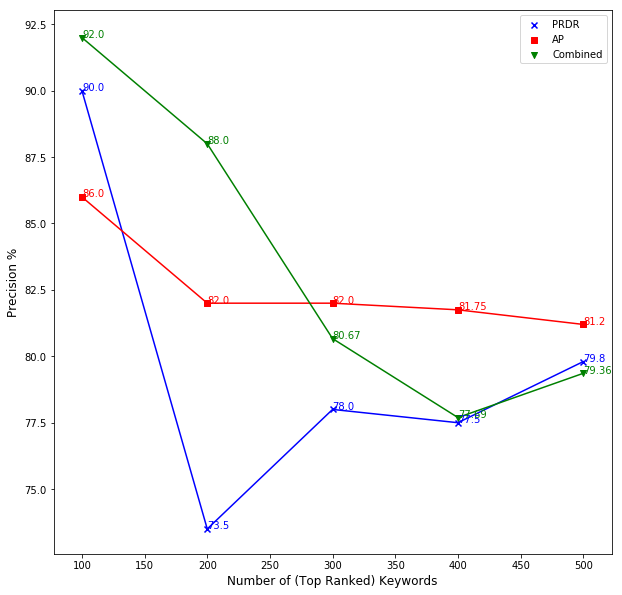

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

x = y

prdr_precision = p1
ap_precision = p2
combined_precision = p3

# old_precision = [86.0, 82.0, 82.0, 81.75, 81.2]
# old_recall = [49.43, 53.07, 51.57, 51.58, 50.69]
# old_f1 = [62.77, 64.44, 63.32, 63.25, 63.25]

plt.figure(figsize=(10,10))
plt.scatter(x, prdr_precision, c='b', marker='x', label='PRDR')
plt.plot(x, prdr_precision, c='b')
plt.scatter(x, ap_precision, c='r', marker='s', label='AP')
plt.plot(x, ap_precision, c='r')
plt.scatter(x, combined_precision, c='g', marker='v', label='Combined')
plt.plot(x, combined_precision, c='g')
plt.legend(loc='upper right')

plt.xlabel('Number of (Top Ranked) Keywords', fontsize=12)
plt.ylabel('Precision %', fontsize=12)

for i_x, i_y in zip(x, prdr_precision):
    plt.text(i_x, i_y, '{}'.format(round(i_y,2)), color = 'blue')

for i_x, i_y in zip(x, ap_precision):
    plt.text(i_x, i_y, '{}'.format(round(i_y,2)), color = 'red')

for i_x, i_y in zip(x, combined_precision):
    plt.text(i_x, i_y, '{}'.format(round(i_y,2)), color = 'green')

# plt.show()
plt.savefig('combined_precision_graph.png')

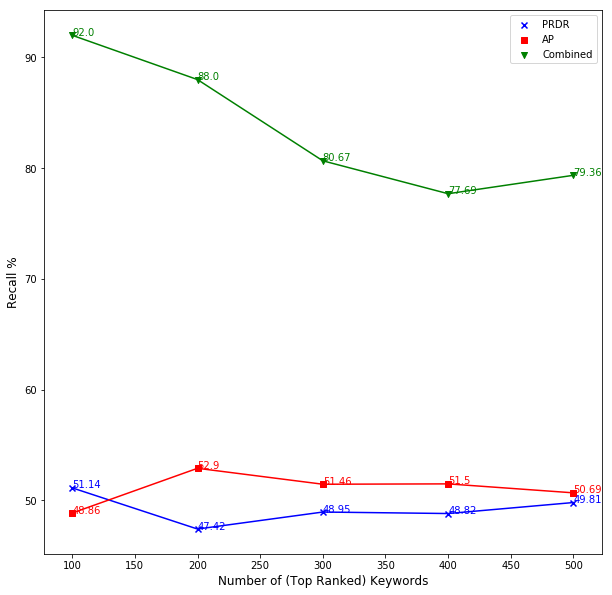

In [42]:
x = y

prdr_recall = r1
ap_recall = r2
combined_recall = r3

plt.figure(figsize=(10,10))

plt.scatter(x, prdr_recall, c='b', marker='x', label='PRDR')
plt.plot(x, prdr_recall, c='b')
plt.scatter(x, ap_recall, c='r', marker='s', label='AP')
plt.plot(x, ap_recall, c='r')
plt.scatter(x, combined_recall, c='g', marker='v', label='Combined')
plt.plot(x, combined_recall, c='g')

plt.legend(loc='upper right')

plt.xlabel('Number of (Top Ranked) Keywords', fontsize=12)
plt.ylabel('Recall %', fontsize=12)

for i_x, i_y in zip(x, prdr_recall):
    plt.text(i_x, i_y, '{}'.format(round(i_y,2)), color = 'blue')

for i_x, i_y in zip(x, ap_recall):
    plt.text(i_x, i_y, '{}'.format(round(i_y,2)), color = 'red')

for i_x, i_y in zip(x, combined_recall):
    plt.text(i_x, i_y, '{}'.format(round(i_y,2)), color = 'green')
    
# plt.show()
plt.savefig('combined_recall_graph.png')

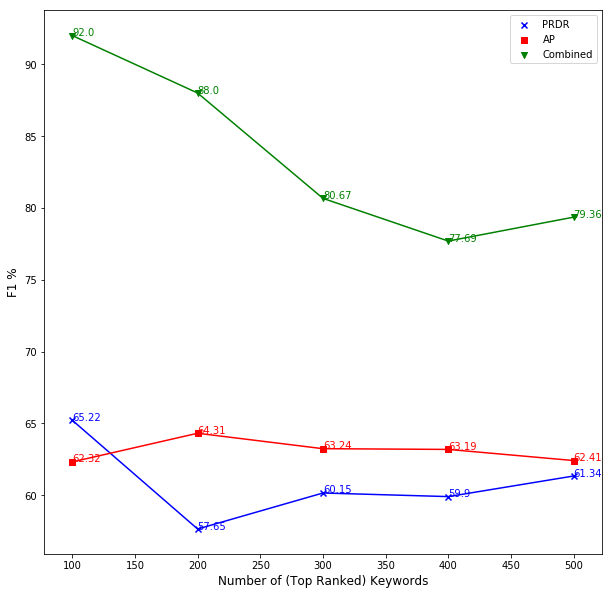

In [43]:
prdr_f1 = [(2*x*y/(x+y)) for x,y in zip(prdr_precision, prdr_recall)]
ap_f1 = [(2*x*y/(x+y)) for x,y in zip(ap_precision, ap_recall)]
combined_f1 = [(2*x*y/(x+y)) for x,y in zip(combined_precision, combined_recall)]

plt.figure(figsize=(10,10))

plt.scatter(x, prdr_f1, c='b', marker='x', label='PRDR')
plt.plot(x, prdr_f1, c='b')
plt.scatter(x, ap_f1, c='r', marker='s', label='AP')
plt.plot(x, ap_f1, c='r')
plt.scatter(x, combined_f1, c='g', marker='v', label='Combined')
plt.plot(x, combined_f1, c='g')

plt.legend(loc='upper right')

plt.xlabel('Number of (Top Ranked) Keywords', fontsize=12)
plt.ylabel('F1 %', fontsize=12)

for i_x, i_y in zip(x, prdr_f1):
    plt.text(i_x, i_y, '{}'.format(round(i_y,2)), color = 'blue')

for i_x, i_y in zip(x, ap_f1):
    plt.text(i_x, i_y, '{}'.format(round(i_y,2)), color = 'red')

for i_x, i_y in zip(x, combined_f1):
    plt.text(i_x, i_y, '{}'.format(round(i_y,2)), color = 'green')

# plt.show()
plt.savefig('combined_f1_graph.png')
